# 导入函数库

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import sys
sys.path.append(r'D:\Desktop\python\python codes\淄博')
from Zibo import *
# from kolzur_filter import *
import math
import statsmodels.api as sm
from pylab import rcParams
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import glob
from datetime import datetime, timedelta
import metpy.calc
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.font_manager as fm
from sklearn.decomposition import PCA  
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import palettable
import matplotlib.transforms as transforms
import ZiboV2
import xarray
from pandas_profiling import ProfileReport
import pymannkendall as mk
%matplotlib inline


def cal_RH(dew,tmp,method='method1'):

    if method == 'method1':
    # source:https://earthscience.stackexchange.com/questions/16570/how-to-calculate-relative-humidity-from-temperature-dew-point-and-pressure
        rh = 100*math.pow(10,(7.591386*(dew/(dew + 240.7263) - tmp/(tmp + 240.7263))))
    elif method == 'method2':
    # source:https://bmcnoldy.rsmas.miami.edu/Humidity.html
        rh = 100*(math.exp((17.625*dew)/(243.04 + dew))/math.exp((17.625*tmp)/(243.04 + tmp)))
    else:
        print('Wrong method!')
    return rh

def boxplotFilter(col):
    # 计算iqr：数据四分之三分位值与四分之一分位值的差
    iqr = col.quantile(0.75)-col.quantile(0.25)
    # 根据iqr计算异常值判断阈值
    u_th = col.quantile(0.75) + 1.5*iqr # 上界
    l_th = col.quantile(0.25) - 1.5*iqr # 下界
    # 定义转换函数：如果数字大于上界则用上界值填充，小于下界则用下界值填充。
    def box_filter(x):
        if x > u_th:
            return np.nan
        elif x < l_th:
            return np.nan
        else:
            return x
    return col.map(box_filter)

def boxplotFilterPro(col):
    # 计算iqr：数据四分之三分位值与四分之一分位值的差
    iqr = col.quantile(0.75)-col.quantile(0.25)
    # 根据iqr计算异常值判断阈值
    u_th = col.quantile(0.75) + 3*iqr # 上界
    l_th = col.quantile(0.25) - 3*iqr # 下界
    # 定义转换函数：如果数字大于上界则用上界值填充，小于下界则用下界值填充。
    def box_filter(x):
        if x > u_th:
            return np.nan
        elif x < l_th:
            return np.nan
        else:
            return x
    return col.map(box_filter)

def removeNegative(x):
    if x<0:
        return np.nan
    else:
        return x

def cleanTsData(data,timecolumn='datetime',pol=['NO2','NO','CO','O31'],groupbysite=True,sitecolumn='sitename'):
    data = data
    # pass
    data = data.set_index(timecolumn)
    for column in pol:
        data[column] = data[column].apply(lambda x:removeNegative(x))
    if groupbysite:
        data_groups = data.groupby(sitecolumn)
        data = pd.DataFrame()
        for sitename,group in data_groups:
            # group = group.set_index(timecolumn)
            group_groups = group.groupby([group.index.month,group.index.hour])
            for datetime,group in group_groups:
                for column in pol:
                    group[column] = boxplotFilter(group[column])
                    # print(group)
                data = data.append(group)
    else:
        data_groups = data.groupby(data.index.month,data.index.hour)
        data = pd.DataFrame()
        for key,group in data_groups:
            for column in pol:
                # print(group[column])
                group[column] = boxplotFilter(group[column])
                data = data.append(group)
    data = data.reset_index()
    return data

def cleanTsDataPro(data,timecolumn='datetime',pol=['NO2','NO','CO','O31'],groupbysite=True,sitecolumn='sitename'):
    data = data
    # pass
    data = data.set_index(timecolumn)
    for column in pol:
        data[column] = data[column].apply(lambda x:removeNegative(x))
    if groupbysite:
        data_groups = data.groupby(sitecolumn)
        data = pd.DataFrame()
        for sitename,group in data_groups:
            # group = group.set_index(timecolumn)
            group_groups = group.groupby([group.index.month,group.index.hour])
            for datetime,group in group_groups:
                for column in pol:
                    group[column] = boxplotFilterPro(group[column])
                    # print(group)
                data = data.append(group)
    else:
        data_groups = data.groupby(data.index.month,data.index.hour)
        data = pd.DataFrame()
        for key,group in data_groups:
            for column in pol:
                # print(group[column])
                group[column] = boxplotFilterPro(group[column])
                data = data.append(group)
    data = data.reset_index()
    return data

def trans_season(x):
    if x.month in [12,1,2]:
        return 'DJF'
    elif x.month in [3,4,5]:
        return 'MAM'
    elif x.month in [6,7,8]:
        return 'JJA'
    elif x.month in [9,10,11]:
        return 'SON'

pyproj unable to set database path.


# 0 气象数据下载

## 0.1 era5-single-levels数据

In [173]:
import cdsapi
import numpy as np
c = cdsapi.Client()
# for year in np.arange(2017,2021,1):
c.retrieve(
    # 'reanalysis-era5-land',
    'reanalysis-era5-single-levels',
    
    {
    'product_type': 'reanalysis',
    'format': 'netcdf',
    'variable': 'boundary_layer_height',
    'year': [
        # '1997','1998','1999',
        # '2000','2001','2002',
        # '2003','2004','2005',
        # '2006','2007','2008',
        # '2009','2010','2011',
        # '2012','2013','2014',
        # '2015','2016','2017', 
        # '2018','2019','2020',
        # '2021',
        '2011','2012','2013',
        '2014','2015','2016',
        '2017','2018','2019',
        '2020','2021',
    ],
    'month': [
        '01', '02', '03',
        '04', '05', '06',
        '07', '08', '09',
        '10', '11', '12',
    ],
    'day': [
        '01', '02', '03',
        '04', '05', '06',
        '07', '08', '09',
        '10', '11', '12',
        '13', '14', '15',
        '16', '17', '18',
        '19', '20', '21',
        '22', '23', '24',
        '25', '26', '27',
        '28', '29', '30',
        '31',
    ],
    'time': [
        '00:00', '01:00', '02:00',
        '03:00', '04:00', '05:00',
        '06:00', '07:00', '08:00',
        '09:00', '10:00', '11:00',
        '12:00', '13:00', '14:00',
        '15:00', '16:00', '17:00',
        '18:00', '19:00', '20:00',
        '21:00', '22:00', '23:00',
    ],
        'area': [
            31.8, 120.9, 30.7,121.9,
        ],
    },
    'D:\Desktop\SH_ERA5_LAND_2012_2020\BLH\ERA5_SGLVL_SH_BLH_2011_2021_new.nc')

2022-06-03 18:05:33,059 INFO Welcome to the CDS
2022-06-03 18:05:33,060 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-06-03 18:05:33,412 INFO Request is completed
2022-06-03 18:05:33,412 INFO Downloading https://download-0010-clone.nuist.love/cache-compute-0010/cache/data3/adaptor.mars.internal-1654243368.9137497-29191-6-7d7210d6-72cc-4498-89d6-fc28b91c9f30.nc to D:\Desktop\SH_ERA5_LAND_2012_2020\BLH\ERA5_SGLVL_SH_BLH_2011_2021_new.nc (5M)
2022-06-03 18:05:37,288 INFO Download rate 1.3M/s   


Result(content_length=5208440,content_type=application/x-netcdf,location=https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data3/adaptor.mars.internal-1654243368.9137497-29191-6-7d7210d6-72cc-4498-89d6-fc28b91c9f30.nc)

## 0.2 era5-land数据

In [ ]:
import cdsapi
import numpy as np
for year in [
            # '2012', 
            # '2013', 
            # '2014',
            # '2015',
            # '2016',
            # '2017',
            # '2018',
            # '2019',
            # '2020',
            '2021',
            ]:
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-land',
        {
            'format': 'netcdf',
            'variable': [
                '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
                '2m_temperature', 'surface_pressure',
                'surface_net_solar_radiation',
                'total_precipitation',
                'boundary_layer_height',
            ],
            'year': [
                year,            
                # '2013',
                # '2014',
                # '2015',
                # '2016',
                # '2017',
                # '2018',
                # '2019',
                # '2020',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                31.8, 120.9, 30.7,
                121.9,
            ],
        },
        'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\ERA5_all_%s.nc'%year)

2022-03-17 16:04:41,381 INFO Welcome to the CDS
2022-03-17 16:04:41,382 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2022-03-17 16:04:41,716 INFO Request is queued
2022-03-17 16:15:11,092 INFO Request is running
2022-03-17 18:12:04,329 WARNING Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 0 of 500
2022-03-17 18:12:04,330 WARNING Retrying in 120 seconds
2022-03-17 18:14:04,341 INFO Retrying now...
2022-03-17 19:11:58,386 INFO Request is completed
2022-03-17 19:11:58,387 INFO Downloading https://download-0002.nuist.love/cache-compute-0002/cache/data0/adaptor.mars.internal-1647515154.0468338-2775-17-b1ec7fb8-c3bf-4b99-87b2-2bce4138daa6.nc to D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\ERA5_all_2021.nc (15.5M)
2022-03-17 19:12:49,587 INFO Download rate 309.5K/s 


## 0.3 ERA5数据导出

In [2]:
import xarray as xr
import pandas as pd
import glob
import numpy as np
from math import atan2
def sumOfSquares(x,y):
    return np.sqrt((x)**2+(y)**2)

def nc2csv(variables,dirpath):

    sites = {'DSL':[121.0,31.1],'PDHN':[121.8,31.1],'PT':[121.4,31.2],'HKLC':[121.5,31.3],'MHPJ':[121.5,31.1],'HQ':[121.3,31.2]}
    paths = glob.glob('%s\*'%dirpath)
    print(paths)

    ds = xr.merge([xr.open_dataset(r'%s'%f) for f in paths])
    met_data = pd.DataFrame()
    for site,coords in sites.items():
        met = pd.DataFrame()
        for var in variables:
            temp = ds[var].sel(longitude=coords[0],latitude=coords[1],method='nearest')
            temp = temp.to_dataframe()
            met = pd.concat([met,temp],axis=1)
        met['sitename'] = site
        met_data = met_data.append(met)

    return met_data

met_blh = nc2csv([
        # 'u10',
        # 'v10',
        # 'd2m',
        # 't2m',
        # 'sp',
        'blh',
        ],
        r'D:\Desktop\SH_ERA5_LAND_2012_2020\BLH'
        )

met_tcc = nc2csv([
        # 'u10',
        # 'v10',
        # 'd2m',
        # 't2m',
        # 'sp',
        'tcc',
        ],
        r'D:\Desktop\SH_ERA5_LAND_2012_2020\TCC'
        )

met_data = nc2csv([
        'u10',
        'v10',
        'd2m',
        't2m',
        'tp',
        'sp',
        'ssr',
        # 'blh',
        ],
        r'D:\Desktop\SH_ERA5_LAND_2012_2020\normal'
        )

met_data = met_data.reset_index()
met_blh = met_blh.reset_index()
met_tcc = met_tcc.reset_index()


met_data = met_data.merge(met_blh,right_on=['time','sitename'],left_on=['time','sitename'],how='outer')
met_data = met_data.merge(met_tcc,right_on=['time','sitename'],left_on=['time','sitename'],how='outer')

met_data1 = met_data.copy()
# met_data0 = met_data0.loc[met_data0['expver']==1]

met_data1['date'] = met_data1['time'].dt.date
met_data1['hour'] = met_data1['time'].dt.hour

met_data1['time_-1'] = met_data1['time']
met_data1 = met_data1.set_index('time_-1').shift(-1,freq='h').reset_index()
met_data1['date_-1'] = met_data1['time_-1'].dt.date
met_data1['hour_-1'] = met_data1['time_-1'].dt.hour

met_data_sum = pd.DataFrame()
for key,group in met_data1.groupby(['sitename','date_-1']):

    group = group.reset_index()
    group_diff = group.copy()

    group_diff['ssr'] = group['ssr'].diff()
    group_diff['tp'] = group['tp'].diff()

    group_diff.loc[0,'ssr'] = list(group['ssr'])[0]
    group_diff.loc[0,'tp'] = list(group['tp'])[0]
    met_data_sum = met_data_sum.append(group_diff)
# met_data_sum

import matplotlib.pyplot as plt
met_data_test = met_data_sum.groupby(met_data_sum['time'].dt.hour).mean()
# met_data_test
plt.plot(met_data_test.index,met_data_test.t2m)
plt.show()
# met_data.to_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\SH_ERA5_LAND_2012_2020.csv')

['D:\\Desktop\\SH_ERA5_LAND_2012_2020\\BLH\\ERA5_SGLVL_SH_BLH_1997.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\BLH\\ERA5_SGLVL_SH_BLH_1998_2010.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\BLH\\ERA5_SGLVL_SH_BLH_2011_2021.nc']
['D:\\Desktop\\SH_ERA5_LAND_2012_2020\\TCC\\ERA5_SNGLVL_SH_TCC_1997_2008.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\TCC\\ERA5_SNGLVL_SH_TCC_2009_2021.nc']
['D:\\Desktop\\SH_ERA5_LAND_2012_2020\\normal\\ERA5_all_1997.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\normal\\ERA5_all_1998.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\normal\\ERA5_all_1999.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\normal\\ERA5_all_2000.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\normal\\ERA5_all_2001.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\normal\\ERA5_all_2002.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\normal\\ERA5_all_2003.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\normal\\ERA5_all_2004.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_2020\\normal\\ERA5_all_2005.nc', 'D:\\Desktop\\SH_ERA5_LAND_2012_202

KeyError: 'expver'

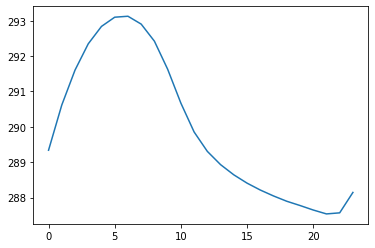

In [4]:
# met_data0 = met_data0.loc[met_data0['expver']==1]
met_data1 = met_data0.copy()

met_data1['date'] = met_data1['time'].dt.date
met_data1['hour'] = met_data1['time'].dt.hour

met_data1['time_-1'] = met_data1['time']
met_data1 = met_data1.set_index('time_-1').shift(-1,freq='h').reset_index()
met_data1['date_-1'] = met_data1['time_-1'].dt.date
met_data1['hour_-1'] = met_data1['time_-1'].dt.hour

met_data_sum = pd.DataFrame()
for key,group in met_data1.groupby(['sitename','date_-1']):

    group = group.reset_index()
    group_diff = group.copy()

    group_diff['ssr'] = group['ssr'].diff()
    group_diff['tp'] = group['tp'].diff()

    group_diff.loc[0,'ssr'] = list(group['ssr'])[0]
    group_diff.loc[0,'tp'] = list(group['tp'])[0]
    met_data_sum = met_data_sum.append(group_diff)
# met_data_sum

import matplotlib.pyplot as plt
met_data_test = met_data_sum.groupby(met_data_sum['time'].dt.hour).mean()
# met_data_test
plt.plot(met_data_test.index,met_data_test.t2m)
plt.show()

In [129]:
met_data0 = met_data.iloc[:,:]
met_data0 = met_data0.loc[met_data0['expver']==1]
met_data1 = met_data0.set_index('time').shift(-8,freq='h').reset_index()
met_data1['date'] = met_data1['time'].dt.date
met_data1['hour'] = met_data1['time'].dt.hour

met_data1['time_-1'] = met_data1['time']
met_data1 = met_data1.set_index('time_-1').shift(-1,freq='h').reset_index()
met_data1['date_-1'] = met_data1['time_-1'].dt.date
met_data1['hour_-1'] = met_data1['time_-1'].dt.hour

met_data_sum = pd.DataFrame()
for key,group in met_data1.groupby(['sitename','date_-1']):

    group = group.reset_index()
    group_diff = group.copy()

    group_diff['ssr'] = group['ssr'].diff()
    group_diff['tp'] = group['tp'].diff()

    # group_diff.loc[0,'ssr'] = group.loc[0,'ssr']
    # group_diff.loc[0,'tp'] = group.loc[0,'tp']
    # group_diff.loc[0,'ssr'] = group['ssr'].iloc[0]
    # group_diff.loc[0,'tp'] = group['tp'].iloc[0]
    group_diff.loc[0,'ssr'] = list(group['ssr'])[0]
    group_diff.loc[0,'tp'] = list(group['tp'])[0]
    met_data_sum = met_data_sum.append(group_diff)
met_data_sum

,index,time_-1,time,longitude_x,latitude_x,u10,longitude_x,latitude_x,v10,longitude_x,...,longitude_y,latitude_y,blh,longitude,latitude,tcc,date,hour,date_-1,hour_-1
0,0,1996-12-31 23:00:00,1997-01-01 00:00:00,121.000000,31.100000,4.154426,121.000000,31.100000,-3.921568,121.000000,...,120.900002,31.200001,749.568237,120.900002,31.200001,0.714424,1997-01-01,0,1996-12-31,23
0,1,1997-01-01 00:00:00,1997-01-01 01:00:00,121.000000,31.100000,4.473213,121.000000,31.100000,-4.495419,121.000000,...,120.900002,31.200001,860.528259,120.900002,31.200001,0.890718,1997-01-01,1,1997-01-01,0
1,2,1997-01-01 01:00:00,1997-01-01 02:00:00,121.000000,31.100000,4.206155,121.000000,31.100000,-4.248551,121.000000,...,120.900002,31.200001,924.998291,120.900002,31.200001,0.747675,1997-01-01,2,1997-01-01,1
2,3,1997-01-01 02:00:00,1997-01-01 03:00:00,121.000000,31.100000,4.263772,121.000000,31.100000,-4.045468,121.000000,...,120.900002,31.200001,1031.982666,120.900002,31.200001,0.392340,1997-01-01,3,1997-01-01,2
3,4,1997-01-01 03:00:00,1997-01-01 04:00:00,121.000000,31.100000,4.602746,121.000000,31.100000,-3.799066,121.000000,...,120.900002,31.200001,1229.619019,120.900002,31.200001,0.562194,1997-01-01,4,1997-01-01,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,657427,2021-12-31 18:00:00,2021-12-31 19:00:00,121.400002,31.200001,-1.838048,121.400002,31.200001,-0.027447,121.400002,...,121.400002,31.200001,NaN,121.400002,31.200001,0.704093,2021-12-31,19,2021-12-31,18
19,657428,2021-12-31 19:00:00,2021-12-31 20:00:00,121.400002,31.200001,-2.106041,121.400002,31.200001,-0.061794,121.400002,...,121.400002,31.200001,NaN,121.400002,31.200001,0.776546,2021-12-31,20,2021-12-31,19
20,657429,2021-12-31 20:00:00,2021-12-31 21:00:00,121.400002,31.200001,-2.189497,121.400002,31.200001,-0.093788,121.400002,...,121.400002,31.200001,NaN,121.400002,31.200001,0.589097,2021-12-31,21,2021-12-31,20
21,657430,2021-12-31 21:00:00,2021-12-31 22:00:00,121.400002,31.200001,-2.514511,121.400002,31.200001,-0.016625,121.400002,...,121.400002,31.200001,NaN,121.400002,31.200001,0.561248,2021-12-31,22,2021-12-31,21


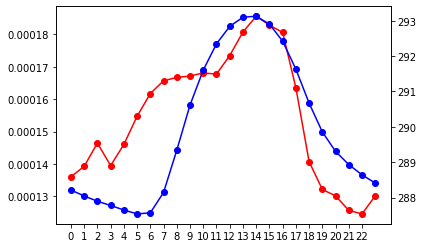

In [8]:
import matplotlib.pyplot as plt
met_data1 = met_data_sum.set_index('time').shift(8,freq='h').reset_index()

met_data_test = met_data1.groupby(met_data1['time'].dt.hour).mean()
# print(met_data_test[''])
fig,ax = plt.subplots()
ax1 = ax.twinx()
ax.plot(met_data_test.index,met_data_test.tp,marker='o',color='r')
ax1.plot(met_data_test.index,met_data_test.t2m,marker='o',color='blue')

ax.set_xticks(np.arange(0,23))
plt.show()

In [14]:
met_data1 = met_data_sum.set_index('time').shift(8,freq='h').reset_index()
met_data1 = met_data1[['time','sitename','ssr','tp','u10','v10','d2m','t2m','sp','tcc','blh']]
# met_data1 = met_data1.set_index(['time','sitename'])
# met_data1 = met_data1.iloc[:,14:].reset_index()
# met_data1
met_data1.to_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\SH_ERA5_1997_2021.csv',index=False)

In [7]:
met_data1.set_index('time').iloc[-40:,:]

,sitename,ssr,tp,u10,v10,d2m,t2m,sp,tcc,blh
time,,,,,,,,,,
2021-12-30 16:00:00,PT,684583.0,0.000000,1.036789,-2.898454,268.445801,281.860596,102952.687500,0.000000,966.766418
2021-12-30 17:00:00,PT,169250.0,0.000000,0.619508,-2.364904,269.424866,280.246826,103018.859375,0.005585,146.059814
2021-12-30 18:00:00,PT,0.0,0.000000,0.490436,-2.237868,270.219971,278.770386,103090.984375,0.039049,58.494995
2021-12-30 19:00:00,PT,0.0,0.000000,0.392983,-1.824296,271.075836,277.381042,103153.257812,0.026369,39.946533
2021-12-30 20:00:00,PT,0.0,0.000000,0.456223,-1.438484,271.428833,275.990997,103184.062500,0.002304,33.562622
2021-12-30 21:00:00,PT,0.0,0.000000,0.667197,-1.126541,270.839386,275.601807,103224.703125,0.000000,27.128418
2021-12-30 22:00:00,PT,0.0,0.000000,1.101066,-0.697913,270.604584,275.069244,103253.648438,0.000000,21.247192
2021-12-30 23:00:00,PT,0.0,0.000000,1.592474,-0.443842,270.245758,273.487610,103251.601562,0.000000,19.437622
2021-12-31 00:00:00,PT,0.0,0.000000,1.838696,-0.449958,269.869446,272.443268,103239.218750,0.000000,21.850464


In [167]:
ds = xr.open_dataset(r'D:\Desktop\SH_ERA5_LAND_2012_2020\BLH\ERA5_SGLVL_SH_BLH_2011_2021.nc')
BLH = ds['blh'].sel(expver=1,longitude=120.92,latitude=31.76,method='nearest')
BLH

<xarray.DataArray 'blh' (time: 96432)>
array([424.58838, 495.8164 , 601.22595, ...,       nan,       nan,       nan],
      dtype=float32)
Coordinates:
    longitude  float32 120.9
    latitude   float32 31.7
    expver     int32 1
  * time       (time) datetime64[ns] 2011-01-01 ... 2021-12-31T23:00:00
Attributes:
    units:      m
    long_name:  Boundary layer height

In [171]:
ds = xr.open_dataset(r'D:\Desktop\SH_ERA5_LAND_2012_2020\TCC\ERA5_SNGLVL_SH_TCC_2009_2021.nc')
# BLH = ds['tcc'].sel(longitude=120.92,latitude=31.76,method='nearest')
# BLH
ds

<xarray.Dataset>
Dimensions:    (latitude: 5, longitude: 5, time: 113952)
Coordinates:
  * longitude  (longitude) float32 120.9 121.2 121.4 121.7 121.9
  * latitude   (latitude) float32 31.7 31.45 31.2 30.95 30.7
  * time       (time) datetime64[ns] 2009-01-01 ... 2021-12-31T23:00:00
Data variables:
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-05-29 17:48:17 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

# 1 数据预处理

## 1.1 数据合并

In [ ]:
data_2site = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\SHdata_2sites.csv',encoding='gbk',parse_dates=['开始时间'])
columnsname = list(data_2site.columns)
columnsname = [name.split('(')[0] for name in columnsname]
data_2site.columns = columnsname
data_2site = data_2site[['站名','开始时间','NO2','NO','CO','O3']]
# data_PDHN = data_PDHN[['站名','开始时间','NO2','NO','CO','O3']]
data_2site = data_2site.set_index('开始时间')
data_2site = data_2site.loc['2013-01':]
data_2site = data_2site.reset_index()
# print(data_2site)

data_PDHN = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\PDhuinandata.xls',parse_dates=['开始时间'])
columnsname = list(data_PDHN.columns)
columnsname = [name.split('(')[0] for name in columnsname]
data_PDHN.columns = columnsname
data_PDHN = data_PDHN[['站名','开始时间','NO2','NO','CO','O3']]
data_PDHN = data_PDHN.set_index('开始时间')
data_PDHN = data_PDHN.loc[:'2020-05']
data_PDHN = data_PDHN.reset_index()
# print(data_PDHN)

data_PDHN2 = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\浦东惠南2020.6-12.xlsx',parse_dates=['开始时间'])
columnsname = list(data_PDHN2.columns)
columnsname = [name.split('(')[0] for name in columnsname]
data_PDHN2.columns = columnsname
data_PDHN2 = data_PDHN2[['站名','开始时间','NO2','NO','CO','O3']]
data_PDHN2 = data_PDHN2.set_index('开始时间')
data_PDHN2 = data_PDHN2.loc['2020-06':]
data_PDHN2 = data_PDHN2.reset_index()
# print(data_PDHN2)

'''2021年数据'''
paths = glob.glob(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\2021年三站点空气质量数据\2021*')
# paths
data2021 = pd.DataFrame()
for path in paths:
    temp = pd.read_csv(path,parse_dates=['开始时间'],encoding='utf_8_sig')
    temp.columns = [name.split('(')[0] for name in temp.columns]
    temp = temp[['站名','开始时间','NO2','NO','CO','O3']]
    # temp = temp.rename(columns={'站名':'sitename','开始时间':'datetime'})
    data2021 = data2021.append(temp)


'''增加闵行浦江和虹口凉城数据'''
data_new = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\空气质量原始数据\闵行浦江和虹口凉城2013_2021.csv',parse_dates=['开始时间'])
data_new.columns = [name.split('(')[0] for name in data_new.columns]
data_new = data_new[['站名','开始时间','NO2','NO','CO','O3']]
# data2021 = data2021.append(temp)

data = pd.concat([data_2site,data_PDHN,data_PDHN2,data2021,data_new],axis=0)
data.columns = ['datetime','sitename','NO2','NO','CO','O31']
data['sitename'] = data['sitename'].apply(lambda x:'DSL' if x=='青浦淀山湖' else ('PT' if x=='普陀监测站' else ('PDHN' if x=='浦东惠南' else ('MHPJ' if x=='闵行浦江' else 'HKLC'))))
data

## 1.2 剔除连续缺失量大的天

In [ ]:
data1 = data.copy()
data1 = data1.set_index('datetime')
data_new = pd.DataFrame()
for groupname,group in data1.groupby(['sitename',pd.Grouper(freq = 'D')]):
    group_count = group.count()
    # 缺失值超过6个就剔除
    if (group_count['NO2']<18)|(group_count['O31']<18)|(group_count['NO']<18):
        # print(groupname)
        # print(group)
        continue
    data_new = data_new.append(group)
data1 = data_new.reset_index()
data1

## 1.2 剔除异常值

In [ ]:
data2 = cleanTsDataPro(data1)
# data2[['NO2','NO','CO','O31']] = data2[['NO2','NO','CO','O31']].interpolate(method='linear')
data2 = data2.set_index('datetime')
data2 = data2.loc['2013':'2021']
data2 = data2.reset_index()
data2['NO2'] = data2['NO2'].apply(lambda x:x*22.4/46)
data2['NO'] = data2['NO'].apply(lambda x:x*22.4/30)
data2['CO'] = data2['CO'].apply(lambda x:x*22.4/28)
data2['O31'] = data2['O31'].apply(lambda x:x*22.4/48)
data2

## 1.3 数据缺失情况检查

In [ ]:
data_check0 = data2.copy()
sitename = 'PT'
data_check = data_check0.loc[(data_check0['O31'].isna())&(data_check0['sitename']==sitename)]
data_check = data_check.set_index('datetime')
# check = {}
rows = []
ts = []
for groupname,group in data_check.resample('D'):
    ts.append(groupname)
    rows.append(len(group))
    # print(groupname, len(group))
check = {'ts':ts,'rows':rows}
check = pd.DataFrame(check)
check = check.sort_values('rows',ascending=False)
print(sitename)
print(check)
# print(check.loc[check['rows']>15])
data_site = data_check0.loc[data_check0['sitename']==sitename]
data_site = data_site.set_index('datetime')
data_site.loc['2013-09-13']

## 1.4 数据填充
* 用KNN填充连续缺失值是无效的，仅能用于个别缺失值
* KNN填充的有问题
* 尝试用多重插补法插值 https://www.cnblogs.com/ljhdo/p/14193481.html

方法1： KNN填充

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=40)
data_imp = data2.copy()
data_fnl = pd.DataFrame()
for groupname,group in data_imp.groupby('sitename'):
    # print(group)
    imputed = imputer.fit_transform(group.iloc[:,2:])
    df_imputed = pd.DataFrame(imputed, columns=group.columns[2:])
    df_imputed['sitename'] = groupname
    df_imputed['datetime'] = group['datetime'].values
    data_fnl = data_fnl.append(df_imputed)
# data_fnl['datetime'] = data1['datetime']
data_fil = data_fnl.copy()

方法2： 线性插值并计算O38

In [ ]:
data_line = data2.copy()
data_fnl1 = pd.DataFrame()
for groupname,group in data_line.groupby('sitename'):
    df_imputed = group.iloc[:,2:]
    df_imputed = df_imputed.interpolate()
    df_imputed['sitename'] = groupname
    df_imputed['datetime'] = group['datetime'].values
    data_fnl1 = data_fnl1.append(df_imputed)
data3 = data_fnl1.copy()
# data3

data_groups = data3.groupby('sitename')
data3 = pd.DataFrame()
for key,group in data_groups:
    
    group = group.set_index('datetime')
    group = group.sort_index()
    group_day_groups = group.groupby(pd.Grouper(freq='D'))
    group_day = pd.DataFrame()
    # 重新计算O38
    for day,group_day_group in group_day_groups:
        group_day_group['O38'] = group_day_group['O31'].rolling(min_periods=6,window='8h').mean()
        group_day_group.O38[group_day_group.index.hour<7]=np.nan
        data3 = data3.append(group_day_group)
data3.index.name = 'datetime'
data3 = data3.reset_index()
data3 = data3[['datetime','sitename','NO2','NO','CO','O31','O38']]
data3

In [ ]:
data3.to_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\2013-2021空气质量数据_清洗填充后\2013-2021空气质量数据_清洗填充后.csv',index=False)

#### 数据校核

In [ ]:
data_check = data3.set_index('datetime')
data_check = data_check.loc[data_check['sitename']=='PT']
data_check = data_check.loc['2013-09-13']
data_check

## 1.5 数据质量报告

In [ ]:
profile = ProfileReport(data_fnl1, title="剔除超过18时缺失k3清洗线性插值填充2021", minimal=True)
profile.to_file("D:\Desktop\剔除超过18时缺失k3清洗线性插值填充2021_EDA.html")

## 1.6 补全气象数据

方法1： 基于ISD数据

In [ ]:
#填补缺失时间
# timeindex = pd.date_range(start='2013-01-01 00:00:00',end='2020-12-31 23:00:00',freq='H')
data_groups = data1.groupby('sitename')
data2 = pd.DataFrame()
for key,group in data_groups:
    
    group = group.set_index('datetime')
    group = group.sort_index()
    # print(group[group.index.duplicated()])
    # group = group.reindex(timeindex)
    group_day_groups = group.groupby(pd.Grouper(freq='D'))
    group_day = pd.DataFrame()
    # 重新计算O38
    for day,group_day_group in group_day_groups:
        group_day_group['O38'] = group_day_group['O31'].rolling(min_periods=6,window='8h').mean()
        group_day_group.O38[group_day_group.index.hour<7]=np.nan
        data2 = data2.append(group_day_group)
data2.index.name = 'datetime'
data2 = data2.reset_index()


# 处理气象数据
  # 徐家汇的数据
# data_meo = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\2638655.csv',encoding='utf_8_sig',parse_dates=['DATE'])
# data_meo = data_meo.loc[data_meo['STATION']==58367099999]  #只有徐家汇站是1小时分辨率
  # 虹桥的数据
data_meo = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\虹桥机场1997_2020.csv',encoding='utf_8_sig',parse_dates=['DATE'])
data_meo = data_meo[['STATION','DATE','CALL_SIGN','DEW','SLP','TMP','VIS','WND','MA1']]

data_meo = data_meo.set_index('DATE')
data_meo = data_meo.shift(8, freq='h')
data_meo = data_meo.loc['2013':'2020']
data_meo['DEW'] = data_meo['DEW'].str.split(',',n=-1,expand=False).apply(lambda x:float(x[0])/10 if x[1]=='1' else np.nan)
data_meo['SLP'] = data_meo['SLP'].str.split(',',n=-1,expand=False).apply(lambda x:x[0] if x[1]=='1' else np.nan)
data_meo['TMP'] = data_meo['TMP'].str.split(',',n=-1,expand=False).apply(lambda x:float(x[0])/10 if x[1]=='1' else np.nan)
data_meo['WD'] = data_meo['WND'].str.split(',',n=-1,expand=False).apply(lambda x:float(x[0]) if x[1]=='1' else np.nan)
data_meo['WS'] = data_meo['WND'].str.split(',',n=-1,expand=False).apply(lambda x:float(x[3])/10 if x[4]=='1' else np.nan)
data_meo['RH'] = data_meo.apply(lambda row:cal_RH(row.DEW,row.TMP,method='method2'),axis=1)

data_meo = data_meo.asfreq(freq='1h')
data_meo.index.name = 'datetime'
data_meo = data_meo.reset_index()
# meodata = pd.read_csv(r'D:\Desktop\SC&YRD_data\original data2\YRD\上海市气象数据2013_2020.csv',encoding='utf_8_sig')

# 气象数据和空气质量数据合并
data2 = pd.merge(data2,data_meo,left_on=['datetime'],right_on=['datetime'],how='outer')
data2 = data2[['datetime','sitename','NO2','NO','CO','O31','O38','SLP','TMP','WS','WD','RH']]
data2.columns = ['datetime','sitename','NO2','NO','CO','O31','O38','SLP','TMP','WS','WD','RH']

# # 对数据进行插值填充并补齐时间
# timeindex = pd.date_range(start='2013-01-01 00:00:00',end='2020-12-31 23:00:00',freq='H')
# data2 = data2.set_index('datetime')
# data_groups = data2.groupby('sitename')
# data2 = pd.DataFrame()
# for sitename,sitegroup in data_groups:
#     sitegroup = sitegroup.reindex(timeindex)
#     sitegroup_temp = sitegroup.copy() 
#     sitegroup = sitegroup.interpolate(method='linear')
#     sitegroup['O38'] = sitegroup_temp['O38']
#     sitegroup['sitename'] = sitename
#     data2 = data2.append(sitegroup)
# data2['NOx'] = data2['NO2'] + data2['NO']
# data2['Ox'] = data2['O31'] + data2['NO2']
# data2 = data2.reset_index()
# data2 = data2.rename(columns={'index':'datetime'})
data2.to_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\SHdata_cleaned.csv',index=False)
# data2

方法2： 基于ERA5数据

In [ ]:
# data4 = data3.copy()
data4 = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\2013-2021空气质量数据_清洗填充后\2013-2021空气质量数据_清洗填充后.csv',parse_dates=['datetime'])

data_era = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\SH_ERA5_LAND_2012_2021_7vars_5sites.csv',parse_dates=['time'])
data4 = data4.merge(data_era,how='left',left_on=['datetime','sitename'],right_on=['time','sitename'])
data4['t2m'] = data4['t2m'] - 273.15
del data4['time']
data = data4.copy()
data.loc[data['sitename']=='MHPJ']

## 1.7 导出数据

In [ ]:
'''
Date: 2021-09-28 15:47:03
LastEditors: XueJin
LastEditTime: 2022-01-12 21:29:39
FilePath: \python codes\长三角\上海臭氧文章.ipynb
'''
# profile = ProfileReport(data2, title="上海三站清洗后数据EDA",minimal=True)
# profile.to_file(r"D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据/上海三站点清洗后数据EDA.html")
data.to_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv',index=False)

# 2 臭氧及NOx整体分析

## 2.1 import data

In [ ]:
data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv',parse_dates=['datetime'])
data

## 2.2 Total Trends

In [ ]:
# site = data.loc[data['sitename']=='PT']
sites = data.copy()
sites = sites.set_index('datetime')
sites = sites.groupby([pd.Grouper(freq='d'),'sitename']).mean().reset_index()
sites

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(9,12))
for num,sitename in enumerate(['PT','DSL','PDHN']):  
    site = sites.loc[sites['sitename']==sitename]  
    # fig,ax = plt.subplots(figsize=(9,4))
    # ax[num].plot(site['datetime'],site['O31'],lw=0.5,color=colors3[num])
    ax[num].scatter(site['datetime'],site['O31'],color=colors3[num],marker='.')
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(site['datetime'])),site['O31'])
    fitted = slope*np.arange(len(site['datetime']))+intercept
    # unit = '$\mathregular{yr^{-1}}$'
    unit = 'ppb/yr'

    # site
    site_ROC = site.groupby(site['datetime'].dt.year).mean()
    # site_ROC.loc['2020']
    ROC = avg_ROC(list(site_ROC['O31']))
    delta = avg_delta(list(site_ROC['O31']))
    ax[num].plot(site['datetime'], fitted, color = 'black',lw=2,linestyle='-.',label='{:s}:{:.3f} {:s} p={:.2f}'.format(sitename,slope*365,unit,p_value))

    ax[num].legend(frameon=False,handlelength=0,loc='upper left',bbox_to_anchor=(0,1.05),prop={'size':'15'})
    ax[num].set_ylabel('$O_3$(ppbv)')
    ax[num].set_xlabel('Year')
plt.savefig(r'D:\Desktop\上海臭氧\图表\臭氧趋势_O31按天.png',dpi=400,bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(9,12))
for num,sitename in enumerate(['PT','DSL','PDHN']):  
    site = sites.loc[sites['sitename']==sitename]  
    # fig,ax = plt.subplots(figsize=(9,4))
    # ax[num].plot(site['datetime'],site['O38'],lw=0.5,color=colors3[num])
    ax[num].scatter(site['datetime'],site['O38'],color=colors3[num],marker='.')
    x = np.arange(len(site['datetime']))
    y = site['O38']
    mask = ~np.isnan(np.array(x)) & ~np.isnan(np.array(y))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    fitted = slope*np.arange(len(site['datetime']))+intercept
    # unit = '$\mathregular{yr^{-1}}$'
    unit = 'ppb/yr'
    

    # site
    site_ROC = site.groupby(site['datetime'].dt.year).mean()
    # site_ROC.loc['2020']
    ROC = avg_ROC(list(site_ROC['O38']))
    delta = avg_delta(list(site_ROC['O38']))
    ax[num].plot(site['datetime'], fitted, color = 'black',lw=2,linestyle='-.',label='{:s}:{:.3f} {:s} p={:.2f}'.format(sitename,slope*365,unit,p_value))

    ax[num].legend(frameon=False,handlelength=0,loc='upper left',bbox_to_anchor=(0,1.05),prop={'size':'15'})
    ax[num].set_ylabel('$O_3MDA8$(ppbv)')
    ax[num].set_xlabel('Year')
# plt.savefig(r'D:\Desktop\上海臭氧\图表\臭氧趋势_O38按天.png',dpi=400,bbox_inches='tight')
plt.show()

### 三个合在一起的MDA8

In [ ]:
fig,ax = plt.subplots(figsize=(16,5))
sns.set(font='Times New Roman',style='ticks',context='talk')
colors3 = ['#E73D1D','#FEC81A','#306AA7']
for num,sitename in enumerate(['PT','DSL','PDHN']):  
    site = sites.loc[sites['sitename']==sitename]  
    # site = site.groupby(site['datetime'].dt.month).mean()
    site = site.set_index('datetime')
    site = site.resample('M').mean()
    site = site.reset_index()
    # fig,ax = plt.subplots(figsize=(9,4))
    # ax[num].plot(site['datetime'],site['O38'],lw=0.5,color=colors3[num])
    ax.plot(site['datetime'],site['O38'],color=colors3[num],marker='.',label=sitename)
    x = np.arange(len(site['datetime']))
    y = site['O38']
    mask = ~np.isnan(np.array(x)) & ~np.isnan(np.array(y))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    fitted = slope*np.arange(len(site['datetime']))+intercept
    # unit = '$\mathregular{yr^{-1}}$'
    unit = 'ppb/yr'

    # site
    site_ROC = site.groupby(site['datetime'].dt.year).mean()
    # site_ROC.loc['2020']
    ROC = avg_ROC(list(site_ROC['O38']))
    delta = avg_delta(list(site_ROC['O38']))
    ax.plot(site['datetime'], fitted, color = colors3[num],lw=2,linestyle='-.',label='{:s}:{:.2f} {:s} p={:.2f}'.format(sitename,slope*12,unit,p_value))
ax.legend(frameon=False,
    # handlelength=0,
    loc='upper left',ncol=3,bbox_to_anchor=(0.1,1.01),prop={'size':'15'})
ax.set_ylabel('$O_3MDA8$(ppbv)')
ax.set_xlabel('Year')
ax.set_ylim(0,80)
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\臭氧污染特征\臭氧趋势_O38按天_三合一_2021.png',dpi=400,bbox_inches='tight')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(16,5))
sns.set(font='Times New Roman',style='ticks',context='talk')
colors3 = ['#E73D1D','#FEC81A','#306AA7']
for num,sitename in enumerate(['PT','DSL','PDHN']):  
    site = sites.loc[sites['sitename']==sitename]  
    # site = site.groupby(site['datetime'].dt.month).mean()
    site = site.set_index('datetime')
    site = site.resample('M').mean()
    site = site.reset_index()
    # fig,ax = plt.subplots(figsize=(9,4))
    # ax[num].plot(site['datetime'],site['NO2'],lw=0.5,color=colors3[num])
    ax.plot(site['datetime'],site['NO2'],color=colors3[num],marker='.',label=sitename)
    x = np.arange(len(site['datetime']))
    y = site['NO2']
    mask = ~np.isnan(np.array(x)) & ~np.isnan(np.array(y))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    fitted = slope*np.arange(len(site['datetime']))+intercept
    # unit = '$\mathregular{yr^{-1}}$'
    unit = 'ppb/yr'
    

    # site
    site_ROC = site.groupby(site['datetime'].dt.year).mean()
    # site_ROC.loc['2020']
    ROC = avg_ROC(list(site_ROC['NO2']))
    delta = avg_delta(list(site_ROC['NO2']))
    ax.plot(site['datetime'], fitted, color = colors3[num],lw=2,linestyle='-.',label='{:s}:{:.2f} {:s} p={:.2f}'.format(sitename,slope*12,unit,p_value))
ax.legend(frameon=False,
    # handlelength=0,
    loc='upper left',ncol=3,bbox_to_anchor=(0.1,1.01),prop={'size':'15'})
ax.set_ylabel('$NO_2$(ppbv)')
ax.set_xlabel('Year')
ax.set_ylim(0,55)
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\臭氧污染特征\NO2趋势_NO2按天_三合一_2021.png',dpi=400,bbox_inches='tight')
# plt.show()

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(9,12))
for num,sitename in enumerate(['PT','DSL','PDHN']):  
    site = sites.loc[sites['sitename']==sitename]  
    # fig,ax = plt.subplots(figsize=(9,4))
    # ax[num].plot(site['datetime'],site['NO2'],lw=0.5,color=colors3[num])
    ax[num].scatter(site['datetime'],site['NO2'],color=colors3[num],marker='.')
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(site['datetime'])),site['NO2'])
    fitted = slope*np.arange(len(site['datetime']))+intercept
    # unit = '$\mathregular{yr^{-1}}$'
    unit = 'ppb/yr'

    # site
    site_ROC = site.groupby(site['datetime'].dt.year).mean()
    ROC = avg_ROC(list(site_ROC['NO2']))
    delta = avg_delta(list(site_ROC['NO2']))
    ax[num].plot(site['datetime'], fitted, color = 'black',lw=2,linestyle='-.',label='{:s}:{:.3f}{:s} p={:.2f}'.format(sitename,slope*365,unit,p_value))

    ax[num].legend(frameon=False,handlelength=0,loc='upper right',bbox_to_anchor=(1,1.05),prop={'size':'15'})
    ax[num].set_ylabel('$NO_2$(ppbv)')
    ax[num].set_xlabel('Year')
plt.savefig(r'D:\Desktop\上海臭氧\图表\臭氧趋势_NO2按天.png',dpi=400,bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(9,12))
for num,sitename in enumerate(['PT','DSL','PDHN']):  
    site = sites.loc[sites['sitename']==sitename]  
    # fig,ax = plt.subplots(figsize=(9,4))
    # ax[num].plot(site['datetime'],site['NO'],lw=0.5,color=colors3[num])
    ax[num].scatter(site['datetime'],site['NO'],color=colors3[num],marker='.')
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(site['datetime'])),site['NO'])
    fitted = slope*np.arange(len(site['datetime']))+intercept
    # unit = '$\mathregular{yr^{-1}}$'
    unit = 'ppb/yr'

    # site
    site_ROC = site.groupby(site['datetime'].dt.year).mean()
    # site_ROC.loc['2020']
    ROC = avg_ROC(list(site_ROC['NO']))
    delta = avg_delta(list(site_ROC['NO']))
    ax[num].plot(site['datetime'], fitted, color = 'black',lw=2,linestyle='-.',label='{:s}:{:.3f} {:s} p={:.2f}'.format(sitename,slope*365,unit,p_value))

    ax[num].legend(frameon=False,handlelength=0,loc='upper left',bbox_to_anchor=(0,1.05),prop={'size':'15'})
    ax[num].set_ylabel('$NO$(ppbv)')
    ax[num].set_xlabel('Year')
plt.savefig(r'D:\Desktop\上海臭氧\图表\臭氧趋势_NO按天.png',dpi=400,bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(9,12))
for num,sitename in enumerate(['PT','DSL','PDHN']):  
    site = sites.loc[sites['sitename']==sitename]  
    # fig,ax = plt.subplots(figsize=(9,4))
    # ax[num].plot(site['datetime'],site['Ox'],lw=0.5,color=colors3[num])
    ax[num].scatter(site['datetime'],site['Ox'],color=colors3[num],marker='.')
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(site['datetime'])),site['Ox'])
    fitted = slope*np.arange(len(site['datetime']))+intercept
    # unit = '$\mathregular{yr^{-1}}$'
    unit = 'ppb/yr'

    site_ROC = site.groupby(site['datetime'].dt.year).mean()
    ROC = avg_ROC(list(site_ROC['Ox']))
    delta = avg_delta(list(site_ROC['Ox']))
    ax[num].plot(site['datetime'], fitted, color = 'black',lw=2,linestyle='-.',label='{:s}:{:.3f}{:s} p={:.2f}'.format(sitename,slope*365,unit,p_value))
    ax[num].legend(frameon=False,handlelength=0,loc='upper left',bbox_to_anchor=(0,1.05),prop={'size':'15'})
    ax[num].set_ylabel('$O_x$(ppbv)')
    ax[num].set_xlabel('Year')
plt.savefig(r'D:\Desktop\上海臭氧\图表\臭氧趋势_Ox按天.png',dpi=400,bbox_inches='tight')

## 1.3 Yearly Trends

In [ ]:
site = data.copy()
# site = data.loc[data['sitename']=='PT']
# site = site.set_index('datetime')
# site = site.groupby(pd.Grouper(freq='Y')).mean().reset_index()
site = site.set_index('datetime')
site_max = site.groupby([pd.Grouper(freq='D'),'sitename']).max()
site = site.groupby([pd.Grouper(freq='D'),'sitename']).mean()
site['O38'] = site_max['O38']
site = site.reset_index()
site['year'] = site['datetime'].dt.year
site = site.loc[site['sitename'].isin(['DSL','PDHN','PT'])]
# palettes=['red','green','blue']
# palettes = colors3
site

In [ ]:
sites = site.set_index('datetime')
sites = (sites
        # .groupby([pd.Grouper(freq='M'),'sitename'])
        # .mean()
        .reset_index())
colors = ['#0099e5','#ff4c4c','#34bf49']
for sitename in ['PT','DSL','PDHN',]:
    fig,ax = plt.subplots(figsize=(12,5))
    site_data = sites.loc[sites['sitename']==sitename]
    ax.plot(site_data['datetime'],site_data['O38'],marker='o',mfc='white',markersize=5,lw=0.5,color=colors[0],label='Ozone MDA8')
    ax.plot(site_data['datetime'],site_data['O31'],marker='o',mfc='white',markersize=5,lw=0.5,color=colors[1],label='Ozone')
    ax.plot(site_data['datetime'],site_data['NO2'],marker='^',mfc='white',markersize=5,lw=0.5,color=colors[2],label='NO2')
    ax.legend()
plt.show()

In [ ]:
sites = site.set_index('datetime')
sites_day = (sites
        # .groupby([pd.Grouper(freq='M'),'sitename'])
        # .mean()
        .reset_index())
sites_month = (sites
        .groupby([pd.Grouper(freq='M'),'sitename'])
        .mean()
        .reset_index()
        )

sites_rolling = (sites
                .groupby(['sitename'])
                .rolling(window='365d',min_periods=300,center=True)
                .mean()
                .reset_index()
                )



colors2 = ['#00699E','#992E2E','#268C35']
colors = ['#0099e5','#ff4c4c','#34bf49']
colors1 = ['#00AAFF','#FF4D4D','#41F25C']


fig,ax = plt.subplots(3,2,figsize=(20,15))
plt.subplots_adjust(wspace=0.12)
pols = ['O31',
        'O38',
        'NO2'
        ]
units = {'O31':'${O_3}$(ppbv)','O38':'${O_3}$ MDA8(ppbv)','NO2':'${NO_2}$(ppbv)'}

for num_pol,pol in enumerate(pols):
    for num_site,sitename in enumerate(['PT','DSL','PDHN']):
        # print(colors[num],sitename)
        color1 = colors1[num_site]
        color2 = colors2[num_site]
        color = colors[num_site]

        site_day = sites_day.loc[sites_day['sitename']==sitename]
        site_month = sites_month.loc[sites_month['sitename']==sitename]
        site_rolling = sites_rolling.loc[sites_rolling['sitename']==sitename]

        ax[num_pol,0].plot(site_day['datetime'],site_day[pol],lw=0.5,color=color1,alpha=0.5)
        # ax[num_pol,0].scatter(site_day['datetime'],site_day[pol],s=2,color=color1,alpha=0.5)

        ax[num_pol,0].plot(site_rolling['datetime'],site_rolling[pol],lw=2.5,color=color1,alpha=1,label=sitename)
        ax[num_pol,1].plot(site_month['datetime'],site_month[pol],marker='o',markerfacecolor='None',markersize=5,lw=1.5,color=color,label=sitename)
        ax[num_pol,0].xaxis.set_minor_locator(mdates.MonthLocator([1,3,5,7,9,11]))
        ax[num_pol,1].xaxis.set_minor_locator(mdates.MonthLocator([1,3,5,7,9,11]))
    ax[num_pol,1].set_ylabel(units[pol])
    ax[num_pol,0].set_ylabel(units[pol])
ax[0,0].legend(frameon=False,ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.15))
ax[0,1].legend(frameon=False,ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.15))
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\臭氧总体趋势.png',dpi=400,bbox_inches='tight')

In [ ]:
# sites
sites_rolling = sites.groupby([pd.Grouper(freq='D'),'sitename']).rolling(window='365d',min_periods=0).mean()
sites_rolling

In [ ]:
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(x='year',y='O31',hue='sitename',data=site,
            hue_order=['DSL','PDHN','PT'],
            palette=['#1255B3','#FF6500','#12B361'],
            style='sitename',dashes=False,markers=['o','o','o'],err_style='bars',err_kws={'capsize':3.0,'lw':1})
ax.set_ylabel('$O_3$(ppbv)')
ax.set_xlabel('Year')
ax.legend(frameon=False,ncol=3,loc='upper center')
ax.set_ylim(25,45)
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\臭氧年变化.png',dpi=400,bbox_inches='tight')

In [ ]:
site1 = site.set_index('datetime')
site1 = site1.groupby([pd.Grouper(freq='Y'),'sitename']).mean()
site1 = site1.unstack()
site1.to_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\污染物特征\各污染物年变化.xlsx')

In [ ]:
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(x='year',y='NO2',hue='sitename',data=site,lw=1,
            hue_order=['PT','DSL','PDHN'],
            palette=['#0099e5','#ff4c4c','#34bf49']
,
            style='sitename',dashes=False,markers=['o','o','o'],ci=95,err_style='band',
            # err_kws={'capsize':3.0,'lw':0.5}
            )
ax.set_ylabel('$NO_2$(ppbv)')
ax.set_xlabel('Year')
ax.legend(frameon=False,ncol=3,loc='upper center')
ax.set_ylim(10,30)
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\NOx年变化.png',dpi=400,bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(x='year',y='Ox',hue='sitename',data=site,palette=colors3,hue_order=['PT','DSL','PDHN'],style='sitename',dashes=False,markers=markers3,err_style='bars',err_kws={'capsize':3.0,'lw':1})
ax.set_ylabel('$O_x$(ppbv)')
ax.set_xlabel('Year')
ax.legend(frameon=False)
plt.savefig(r'D:\Desktop\上海臭氧\图表\总氧化剂年变化.png',dpi=400,bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(x='year',y='O38',hue='sitename',data=site,palette=colors3,hue_order=['PT','DSL','PDHN'],style='sitename',dashes=False,markers=markers3,err_style='bars',err_kws={'capsize':3.0,'lw':1})
ax.set_ylabel('$O_3$-MDA8(ppbv)')
ax.set_xlabel('Year')
ax.legend(frameon=False)
plt.savefig(r'D:\Desktop\上海臭氧\图表\O3MDA8年变化.png',dpi=400,bbox_inches='tight')

## 1.4 diural Trends

### 1.4.1 折线图 

In [ ]:
sites = data.copy()
fig,ax = plt.subplots(3,1,figsize=(9,12))
for num,sitename in enumerate(['DSL','PT','PDHN']):
    site = sites.loc[data['sitename']==sitename]
    site = site.set_index('datetime')
    site['hour'] = site.index.hour
    site['year'] = site.index.year
    site = site.groupby([site['year'],site['hour']]).mean().reset_index()
    sns.lineplot(x='hour',y='O31',hue='year',data=site,style='year',markers=True,dashes=False,palette='Set1',ax=ax[num])
    ax[num].set_ylabel('$O_3$(ppbv)')
    ax[num].set_xticks(np.arange(0,24,1))
    ax[num].set_xlim(0,23)
    ax[num].legend(frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.1),ncol=8)
    ax[num].set_ylim(15,60)
    trans = transforms.blended_transform_factory(ax[num].transData, ax[num].transAxes)
    ax[num].text(site['hour'].values[2], 0.85,'%s'%(sitename),transform=trans,ha='center',fontsize=25,fontdict={'size':'30','font':'Times New Roman','weight':'bold'})
plt.savefig(r'D:\Desktop\上海臭氧\图表\臭氧日变化.png',dpi=400,bbox_inches='tight')

In [ ]:
sites = data.copy()
fig,ax = plt.subplots(3,1,figsize=(9,12))
for num,sitename in enumerate(['DSL','PT','PDHN']):
    site = sites.loc[data['sitename']==sitename]
    site = site.set_index('datetime')
    site['hour'] = site.index.hour
    site['year'] = site.index.year
    site = site.groupby([site['year'],site['hour']]).mean().reset_index()
    sns.lineplot(x='hour',y='NO2',hue='year',data=site,style='year',markers=True,dashes=False,palette='Set1',ax=ax[num])
    ax[num].set_ylabel('$NO_2$(ppbv)')
    ax[num].set_xticks(np.arange(0,24,1))
    ax[num].set_xlim(0,23)
    ax[num].set_ylim(10,35)
    ax[num].legend(frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.1),ncol=8)
    trans = transforms.blended_transform_factory(ax[num].transData, ax[num].transAxes)
    ax[num].text(site['hour'].values[2], 0.85,'%s'%(sitename),ha='center',transform=trans,fontsize=25,fontdict={'size':'30','font':'Times New Roman','weight':'bold'})
    # ax[num].set_ylim(0,65)
plt.savefig(r'D:\Desktop\上海臭氧\图表\NO2日变化.png',dpi=400,bbox_inches='tight')

In [ ]:
sites = data.copy()
fig,ax = plt.subplots(3,1,figsize=(9,12))
for num,sitename in enumerate(['DSL','PT','PDHN']):
    site = sites.loc[data['sitename']==sitename]
    site = site.set_index('datetime')
    site['hour'] = site.index.hour
    site['year'] = site.index.year
    site = site.groupby([site['year'],site['hour']]).mean().reset_index()
    sns.lineplot(x='hour',y='Ox',hue='year',data=site,style='year',markers=True,dashes=False,palette='Set1',ax=ax[num])
    ax[num].set_ylabel('$O_x$(ppbv)')
    ax[num].set_xticks(np.arange(0,24,1))
    ax[num].set_xlim(0,23)
    ax[num].set_ylim(35,75)
    ax[num].legend(frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.1),ncol=8)
    trans = transforms.blended_transform_factory(ax[num].transData, ax[num].transAxes)
    ax[num].text(site['hour'].values[2], 0.85,'%s'%(sitename),ha='center',transform=trans,fontsize=30,fontdict={'size':'60','font':'Times New Roman','weight':'bold'})
plt.savefig(r'D:\Desktop\上海臭氧\图表\总氧化剂日变化.png',dpi=400,bbox_inches='tight')

In [ ]:
sites = data.copy()
fig,ax = plt.subplots(3,1,figsize=(9,12))
for num,sitename in enumerate(['DSL','PT','PDHN']):
    site = sites.loc[data['sitename']==sitename]
    site = site.set_index('datetime')
    site['hour'] = site.index.hour
    site['year'] = site.index.year
    site = site.groupby([site['year'],site['hour']]).mean().reset_index()
    sns.lineplot(x='hour',y='NO',hue='year',data=site,style='year',markers=True,dashes=False,palette='Set1',ax=ax[num])
    ax[num].set_ylabel('$NO$(ppbv)')
    ax[num].set_xticks(np.arange(0,24,1))
    ax[num].set_xlim(0,23)
    ax[num].set_ylim(0,25)
    ax[num].legend(frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.1),ncol=8)
    trans = transforms.blended_transform_factory(ax[num].transData, ax[num].transAxes)
    ax[num].text(site['hour'].values[2], 0.85,'%s'%(sitename),ha='center',transform=trans,fontsize=30,fontdict={'size':'60','font':'Times New Roman','weight':'bold'})
plt.savefig(r'D:\Desktop\上海臭氧\图表\NO日变化.png',dpi=400,bbox_inches='tight')
sites

### 1.4.1 热力图

In [ ]:
sitename = 'PT'
pol = 'O31'
# levels = np.arange(0,61,5)
sites = data.copy()
site = sites.loc[sites['sitename']==sitename]
site = site.groupby([site['datetime'].dt.hour,site['datetime'].dt.year]).mean()
site.index.names=['hour','year']
site = site.reset_index()
fig,ax = plt.subplots(figsize=(9,6))
sns.heatmap(site.pivot_table(index=site['year'],columns=site['hour'],values=pol),vmin=0,vmax=60,cbar_kws={'label': '%s(ppbv)'%pol},cmap='jet',annot=True,ax=ax)
ax.set_title(sitename,fontsize=20)
# plt.show()

plt.savefig(r'D:\Desktop\上海臭氧\图表\臭氧日变化热力图_%s.png'%sitename,bbox_inches='tight')

In [ ]:
sitename = 'PT'
pol = 'NO2'
# levels = np.arange(0,61,5)
sites = data.copy()
site = sites.loc[sites['sitename']==sitename]
site = site.groupby([site['datetime'].dt.hour,site['datetime'].dt.year]).mean()
site.index.names=['hour','year']
site = site.reset_index()
fig,ax = plt.subplots(figsize=(9,6))
sns.heatmap(site.pivot_table(index=site['year'],columns=site['hour'],values=pol),vmin=0,vmax=35,cbar_kws={'label': '%s(ppbv)'%pol},cmap='jet',annot=True,ax=ax)
ax.set_title(sitename,fontsize=20)
# plt.show()

plt.savefig(r'D:\Desktop\上海臭氧\图表\NO2日变化热力图_%s.png'%sitename,bbox_inches='tight')

In [ ]:
sitename = 'PDHN'
pol = 'Ox'
# levels = np.arange(0,61,5)
sites = data.copy()
site = sites.loc[sites['sitename']==sitename]
site = site.groupby([site['datetime'].dt.hour,site['datetime'].dt.year]).mean()
site.index.names=['hour','year']
site = site.reset_index()
fig,ax = plt.subplots(figsize=(9,6))
sns.heatmap(site.pivot_table(index=site['year'],columns=site['hour'],values=pol),vmin=0,vmax=75,cbar_kws={'label': '%s(ppbv)'%pol},cmap='jet',annot=True,ax=ax)
ax.set_title(sitename,fontsize=20)
# plt.show()

plt.savefig(r'D:\Desktop\上海臭氧\图表\Ox日变化热力图_%s.png'%sitename,bbox_inches='tight')

In [ ]:
sitename = 'PT'
pol = 'NO'
# levels = np.arange(0,61,5)
sites = data.copy()
site = sites.loc[sites['sitename']==sitename]
site = site.groupby([site['datetime'].dt.hour,site['datetime'].dt.year]).mean()
site.index.names=['hour','year']
site = site.reset_index()
fig,ax = plt.subplots(figsize=(9,6))
sns.heatmap(site.pivot_table(index=site['year'],columns=site['hour'],values=pol),vmin=0,vmax=25,cbar_kws={'label': '%s(ppbv)'%pol},cmap='jet',annot=True,ax=ax)
ax.set_title(sitename,fontsize=20)
# plt.show()

plt.savefig(r'D:\Desktop\上海臭氧\图表\NO日变化热力图_%s.png'%sitename,bbox_inches='tight')

## 1.4 monthly Trends

In [ ]:
sites = data.copy()
sites = sites.loc[sites['sitename'].isin(['PT','PDHN','DSL'])]
sites['NO2'] = sites['NO2']
# sites['NOx'] = sites['NO'] + sites['NO2']
fig,ax = plt.subplots(figsize=(9,4))

sites = sites.set_index('datetime')
sites = sites.groupby([pd.Grouper(freq='D'),'sitename']).mean().reset_index()
sites['datetime'] = sites['datetime'].apply(lambda x:pd.to_datetime(x.strftime('%Y-%m-15')))

sites['month'] = sites['datetime'].dt.month

# # sites = sites.groupby([sites['sitename'],sites['month']]).mean().reset_index()
colors = ['#0099e5','#ff4c4c','#34bf49']

sns.lineplot(x='month',y='NO2',data=sites,lw=1,
                ci=95,err_style='band',
                # err_kws={'capsize':3.0,'lw':1.5},
                hue='sitename',hue_order=['PT','DSL','PDHN'],style='sitename',
                markers=['o','o','o'],dashes=False,palette=colors,ax=ax)
# ax.set_ylabel('$NO_x$(ppbv)')
ax.set_ylabel('$NO_2$(ppbv)')

ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
# ax.set_ylim(0,80)

ax.legend(frameon=False,loc='upper center',ncol=3)

plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\NOx月变化.png',dpi=400,bbox_inches='tight')
# plt.show()


## 1.5 episodes

## 1.5.1 episodes - heatmap

In [ ]:
import matplotlib.colors as mcolors
levels = [0,100,160,215,265,800]
levels = [x*22.4/48 for x in levels]

sitename = 'PDHN'
site = data.copy()
site = site.loc[site['sitename']==sitename]
site = site.set_index('datetime')
site = site.groupby(pd.Grouper(freq='D')).max().reset_index()
site['year'] = site['datetime'].dt.year
site['day'] = site['datetime'].dt.dayofyear

cmap = mpl.colors.ListedColormap(['#01e400', '#ffff00', '#ff7e00', '#fe0000','#98004b'])
cmap.set_over('#7e0123')
norm = mpl.colors.BoundaryNorm(levels, cmap.N)

fig,ax = plt.subplots(figsize=(15,3))
sns.heatmap(data=site.pivot_table(index=site['year'],columns=site['day'],values='O38'),cbar_kws={'extend':'max','label': '${O_3}$-MDA8(ppbv)',"ticks":levels,},norm = norm,cmap=cmap,ax=ax)
ax.set_title(sitename,fontsize=20)
ax.set_xticks([0,31+1,59+1,90+1,120+1,151+1,181+1,212+1,243+1,273+1,304+1,334+1])
ax.set_xticklabels(['Jan.','Feb.','Mar.','Apr.','May.','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.'])
plt.savefig(r'D:\Desktop\上海臭氧\图表\臭氧热力图_%s.png'%sitename,dpi=400,bbox_inches='tight')

## 1.5.2 episodes - stacked bar plot

In [ ]:
def classify_O38(x):
    if (x>0)&(x<=46.7):
        return 'excellent'
    elif (x>46.7)&(x<=74.7):
        return 'good'
    elif (x>74.7)&(x<=100.3):
        return 'lightly polluted'
    elif (x>100.3)&(x<=123.7):
        return 'moderately polluted'
    elif (x>373.3):
        return 'heavily polluted'

# sitename = 'PDHN'
site = data.copy()
# site = site.loc[site['sitename']==sitename]
site = site.set_index('datetime')
site = site.groupby([pd.Grouper(freq='D'),'sitename']).max().reset_index()
site['year'] = site['datetime'].dt.year
site['day'] = site['datetime'].dt.dayofyear

site_class = site.copy()
site_class['year'] = site_class['datetime'].dt.year
site_class['classification'] = site_class['O38'].apply(lambda x:classify_O38(x))
site_class = site_class.groupby(['classification','sitename','year']).apply(lambda x:len(x)).to_frame('days')
site_class = site_class.unstack(level=0)
site_class
site_class.to_excel(r'D:\Desktop\上海臭氧\空气质量数据\污染事件统计.xlsx')
fig,ax = plt.subplots(figsize=(12,5))
cmap = mpl.colors.ListedColormap(['#01e400', '#ffff00', '#ff7e00', '#fe0000'])
bar = site_class['days'].plot(kind = 'barh',stacked='True',cmap=cmap,ax=ax)
ZiboV2.vbar_label(ax,bar,'%s')

ax.legend(frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.1),ncol=4,fontsize=10)
ax.set_xlabel('Days')
ax.set_ylabel('Year')
# plt.savefig(r'D:\Desktop\上海臭氧\图表\臭氧污染事件统计.png',dpi=400,bbox_inches='tight')
plt.show()
# # 2013-2017
# # 2017-2020
# # 这两个区间存在明显区别
# #按标准分

## 1.6 weekday and weekend

In [ ]:
def specify_week(x):
    if x<5:
        return 'weekday'
    elif (x>=5)&(x<=6):
        return 'weekend'

sites = data.copy()
fig,ax = plt.subplots(3,1,figsize=(8,12))
for num,sitename in enumerate(['PT','PDHN','DSL']):
    site = sites.loc[sites['sitename']==sitename]
    site = site.set_index('datetime')
    site = site.groupby(pd.Grouper(freq='D')).max().reset_index()
    site = site.set_index('datetime')
    site['dayofweek'] = site.index.dayofweek
    site['year'] = site.index.year
    site['week'] = site['dayofweek'].apply(lambda x:specify_week(x))
    # site = site.groupby(['week','year']).mean().reset_index()
    sns.lineplot(data = site,x='year',y='O38',hue='week',palette=['red','black'],marker='o',ax=ax[num])
    ax[num].set_ylabel('$O_3$-MDA8(ppbv)')
    ax[num].legend(frameon=False)
plt.savefig(r'D:\Desktop\上海臭氧\图表\臭氧周末效应图.png',dpi=400,bbox_inches='tight')

# site

In [ ]:
def specify_week(x):
    if x<5:
        return 'weekday'
    elif (x>=5)&(x<=6):
        return 'weekend'

sites = data.copy()
fig,ax = plt.subplots(3,1,figsize=(8,12))
for num,sitename in enumerate(['PT','PDHN','DSL']):
    site = sites.loc[sites['sitename']==sitename]
    site = site.set_index('datetime')
    site = site.groupby(pd.Grouper(freq='D')).max().reset_index()
    site = site.set_index('datetime')
    site['dayofweek'] = site.index.dayofweek
    site['year'] = site.index.year
    site['week'] = site['dayofweek'].apply(lambda x:specify_week(x))
    # site = site.groupby(['week','year']).mean().reset_index()
    sns.lineplot(data = site,x='year',y='NO2',hue='week',palette=['red','black'],marker='o',ax=ax[num])
    ax[num].set_ylabel('$NO_2$(ppbv)')
    ax[num].legend(frameon=False)
plt.savefig(r'D:\Desktop\上海臭氧\图表\NO2周末效应图.png',dpi=400,bbox_inches='tight')
# site

In [ ]:
def specify_week(x):
    if x<5:
        return 'weekday'
    elif (x>=5)&(x<=6):
        return 'weekend'

sites = data.copy()
fig,ax = plt.subplots(3,1,figsize=(8,12))
for num,sitename in enumerate(['PT','PDHN','DSL']):
    site = sites.loc[sites['sitename']==sitename]
    site = site.set_index('datetime')
    site = site.groupby(pd.Grouper(freq='D')).max().reset_index()
    site = site.set_index('datetime')
    site['dayofweek'] = site.index.dayofweek
    site['year'] = site.index.year
    site['week'] = site['dayofweek'].apply(lambda x:specify_week(x))
    # site = site.groupby(['week','year']).mean().reset_index()
    sns.lineplot(data = site,x='year',y='Ox',hue='week',palette=['red','black'],marker='o',ax=ax[num])
    ax[num].set_ylabel('$O_x$(ppbv)')
    ax[num].legend(frameon=False)
plt.savefig(r'D:\Desktop\上海臭氧\图表\总氧化剂周末效应图.png',dpi=400,bbox_inches='tight')
# site

In [ ]:
def specify_week(x):
    if x<5:
        return 'weekday'
    elif (x>=5)&(x<=6):
        return 'weekend'

sites = data.copy()
fig,ax = plt.subplots(3,1,figsize=(8,12))
for num,sitename in enumerate(['PT','PDHN','DSL']):
    site = sites.loc[sites['sitename']==sitename]
    site = site.set_index('datetime')
    site = site.groupby(pd.Grouper(freq='D')).max().reset_index()
    site = site.set_index('datetime')
    site['dayofweek'] = site.index.dayofweek
    site['year'] = site.index.year
    site['week'] = site['dayofweek'].apply(lambda x:specify_week(x))
    # site = site.groupby(['week','year']).mean().reset_index()
    sns.lineplot(data = site,x='year',y='NO',hue='week',palette=['red','black'],marker='o',ax=ax[num])
    ax[num].set_ylabel('$NO$(ppbv)')
    ax[num].legend(frameon=False)
plt.savefig(r'D:\Desktop\上海臭氧\图表\NO周末效应图.png',dpi=400,bbox_inches='tight')
# site

# 3 PCA数据处理

## 3.1 PCA数据前处理

方法1:处理成MDA8对应的8小时数据

In [ ]:
# data_day = data_rmw.copy()
# data_day = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv',parse_dates=['datetime'])
data_day = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv',parse_dates=['datetime'])
data_day_new = pd.DataFrame()
data_day = data_day.set_index('datetime')
for groupname,group in data_day.groupby([pd.Grouper(freq='D'),'sitename']):
    # temp = {}
    group = group.reset_index()
    idxmax = group['O38'].idxmax()
    temp = group.iloc[idxmax-7:idxmax+1]
    data_day_new = data_day_new.append(temp)
# data_day_new
data_day_new.to_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\剔除超过6小时缺值天线性插值的数据\SHdata_5sites_剔除超过6小时缺值天线性插值_MDA8.csv')

方法2：处理成MDA8的日数据

In [ ]:
data_day_new1 = data_day_new.groupby([data_day_new['datetime'].dt.date,'sitename']).mean()
data_day_new1.to_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\剔除超过6小时缺值天线性插值的数据\SHdata_5sites_剔除超过6小时缺值天线性插值_MDA8日数据.csv')

方法3：处理成三个站点平均浓度的每天的最大八小时

In [ ]:
data_pca = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\剔除超过6小时缺值天线性插值的数据\SHdata_剔除超过6小时缺值天线性插值.csv',parse_dates=['datetime'])
data_pca = data_pca.set_index(['datetime','sitename'])
data_pca = data_pca.unstack()['O31']
data_pca['avg'] = data_pca[['DSL','PDHN','PT','MHPJ','HKLC']].mean(axis=1)
data_pca_new = pd.DataFrame()
for key,group in data_pca.resample('D'):
    group = group.reset_index()
    group = group.set_index('datetime')
    group['O38'] = group['avg'].rolling('8h',min_periods=8).mean()
    group = group.reset_index()
    idxmax = group['O38'].idxmax()
    group = group.iloc[idxmax-7:idxmax+1]
    data_pca_new = data_pca_new.append(group)
# data_pca_new

data_pca = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\剔除超过6小时缺值天线性插值的数据\SHdata_剔除超过6小时缺值天线性插值.csv',parse_dates=['datetime'],index_col='datetime',)
# print(data_pca)
data_pca_new1 = data_pca_new.copy()
timerange = pd.date_range(start='2013-01-01 00:00:00',end='2020-12-31 23:59:59',freq='h')
timeindex = data_pca_new1['datetime']
data_pca_final = pd.DataFrame()
for key,group in data_pca.groupby('sitename'):
    group = group.reindex(timerange)
    # print(len(group))
    group['sitename'] = key
    group = group.loc[timeindex]
    data_pca_final = data_pca_final.append(group)
data_pca_final.to_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\剔除超过6小时缺值天线性插值的数据\SHdata_剔除超过6小时缺值天线性插值_三站点平均O38.xlsx')

In [ ]:
data_pca = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv',parse_dates=['datetime'])
data_pca = data_pca.loc[(data_pca['datetime'].dt.hour>9)&(data_pca['datetime'].dt.hour<19)]
data_pca.to_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\剔除超过6小时缺值天线性插值的数据\SHdata_剔除超过6小时缺值天线性插值_5sites_10点到18点.xlsx')


In [ ]:
data_pca = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv',parse_dates=['datetime'])
data_pca = data_pca.groupby(data['datetime'].dt.hour).mean()
data_pca

## 3.2 PCA结果后处理

In [ ]:
allPC = pd.DataFrame()
# for sitename in ['PT','DSL','PDHN']:
PT = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按全天数据\PCA总表.xlsx',sheet_name='PT',parse_dates=['datetime'])
DSL = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按全天数据\PCA总表.xlsx',sheet_name='DSL',parse_dates=['datetime'])
PDHN = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按全天数据\PCA总表.xlsx',sheet_name='PDHN',parse_dates=['datetime'])
MHPJ = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按全天数据\PCA总表.xlsx',sheet_name='MHPJ',parse_dates=['datetime'])
HKLC = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按全天数据\PCA总表.xlsx',sheet_name='HKLC',parse_dates=['datetime'])

# PT['date'] = PT.datetime.dt.date
# PDHN['date'] = PDHN.datetime.dt.date
# DSL['date'] = DSL.datetime.dt.date
# data = PT.merge(PDHN,left_on = ['date'],right_on=['date'])
# data
allPC = allPC.append(PT)
allPC = allPC.append(DSL)
allPC = allPC.append(PDHN)
allPC = allPC.append(MHPJ)
allPC = allPC.append(HKLC)
allPC

In [ ]:
allPC.to_csv(r'D:/desktop/总表.csv')

In [ ]:
allPC1 = allPC.set_index(['sitename','datetime'])
# allPC1 = allPC1.pivot_table(index=['datetime'],columns=['sitename'],values=['背景浓度'])
allPC1 = allPC1.unstack(level=0)
allPC1['BKGO3'].to_csv(r'D:/desktop/test5.csv')
# allPC1.to_csv(r'D:/desktop/test4.csv')

方法1：不根据时间合并

In [ ]:
allPC1 = allPC.copy()
allPC2 = pd.DataFrame()
allPC1['date'] = allPC1.datetime.dt.date
for key,group in allPC1.groupby(['sitename','date']):
    group['index'] = np.arange(8)
    allPC2 = allPC2.append(group)
# allPC1 = allPC1.set_index(['sitename','date'])
# allPC1 = allPC1.unstack()
allPC3 = allPC2.copy()
allPC3 = allPC3.set_index(['date','index','sitename'])
allPC3 = allPC3.iloc[:,1:]
allPC3 = allPC3.unstack()
allPC3
# allPC3.to_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充\常规五项\PCA成分合并.xlsx')

方法2：根据时间合并

In [ ]:
allPC1 = allPC.copy()
# allPC1 = allPC1.set_index(['datetime','sitename'])
# allPC1 = allPC1.groupby(['sitename']).count()
allPC1 = allPC1.pivot_table(columns=['sitename'],index='datetime')
# allPC1 = allPC1.unstack()
allPC1.to_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\PCA_按天结果汇总_剔除后_成分合并.xlsx')
# allPC1

# 4 气象标准化结果评估

## 4.1 模型性能优化

### 4.1.1 定义函数

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from multiprocessing.pool import ApplyResult
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import random
import multiprocessing 
from scipy import stats
import math
from chinese_calendar import is_workday, is_holiday
import shap
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score
import pickle

'''建立函数部分'''

def cal_RH(dew,tmp,method='method1'):

    if method == 'method1':
    # source:https://earthscience.stackexchange.com/questions/16570/how-to-calculate-relative-humidity-from-temperature-dew-point-and-pressure
        rh = 100*math.pow(10,(7.591386*(dew/(dew + 240.7263) - tmp/(tmp + 240.7263))))
    elif method == 'method2':
    # source:https://bmcnoldy.rsmas.miami.edu/Humidity.html
        rh = 100*(math.exp((17.625*dew)/(243.04 + dew))/math.exp((17.625*tmp)/(243.04 + tmp)))
    else:
        print('Wrong method!')
    return rh

# 数据前处理
def prep_data(aqData,metData,timevar):
    combinedData = pd.merge(aqData,metData,on=timevar)
    # aqData
    aqData['date'] = aqData[timevar].dt.date
    aqData['unix_time'] = aqData['date'].apply(lambda x:(pd.to_datetime(x) - pd.Timestamp("1970-01-01")) \
                                            // pd.Timedelta('1s'))
    aqData['dayofweek'] = aqData[timevar].dt.dayofweek
    aqData['dayofyear'] = aqData[timevar].dt.dayofyear
    aqData['hour'] = aqData[timevar].dt.hour
    aqData['month'] = aqData[timevar].dt.month
    # metData
    metData['date'] = metData[timevar].dt.date
    metData['unix_time'] = metData['date'].apply(lambda x:(pd.to_datetime(x) - pd.Timestamp("1970-01-01")) \
                                            // pd.Timedelta('1s'))
    metData['dayofweek'] = metData[timevar].dt.dayofweek
    metData['dayofyear'] = metData[timevar].dt.dayofyear
    metData['hour'] = metData[timevar].dt.hour
    metData['month'] = metData[timevar].dt.month
    # combinedData
    combinedData['date'] = combinedData[timevar].dt.date
    combinedData['unix_time'] = combinedData['date'].apply(lambda x:(pd.to_datetime(x) - pd.Timestamp("1970-01-01")) \
                                            // pd.Timedelta('1s'))
    combinedData['dayofweek'] = combinedData[timevar].dt.dayofweek
    combinedData['dayofyear'] = combinedData[timevar].dt.dayofyear
    combinedData['hour'] = combinedData[timevar].dt.hour
    combinedData['month'] = combinedData[timevar].dt.month

    return aqData,metData,combinedData

# 训练模型
def train_model(combinedData,pol,met,random_seed,test_size=0.2,maxFeatures=5,minSamplesLeaf=1):
    y = combinedData[[pol]]
    x = combinedData[['unix_time','dayofweek','dayofyear','hour','month']+met]
    train_x,test_x,train_y,test_y=train_test_split(x,y,test_size = test_size,random_state=random_seed)
    random_forest_model=RandomForestRegressor(n_estimators=300,n_jobs=-1,max_features=maxFeatures,min_samples_leaf=minSamplesLeaf,random_state=random_seed)
    random_forest_model = random_forest_model.fit(train_x.values,train_y.values.ravel())
    random_forest_predict=random_forest_model.predict(test_x.values)

    testDataset = pd.concat([test_x,test_y,pd.Series(random_forest_predict,index=test_y.index)],axis=1)
    testDataset = testDataset.rename(columns={0:'predicts'})
    random_forest_pearson_r=stats.pearsonr(test_y.values.ravel(),random_forest_predict)
    random_forest_R2=metrics.r2_score(test_y.values.ravel(),random_forest_predict)
    random_forest_RMSE=metrics.mean_squared_error(test_y.values.ravel(),random_forest_predict)**0.5
    modelPerformance = {'pol':pol,'pearsonR':random_forest_pearson_r[0],'random_forest_R2':random_forest_R2,'random_forest_RMSE':random_forest_RMSE}
    modelPerformance = pd.DataFrame(modelPerformance,index=[0])

    importances = random_forest_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
    forest_importances = pd.DataFrame([importances,std],columns=x.columns,index=['importance','std']).T

    return random_forest_model,modelPerformance,forest_importances,train_x,test_x,train_y,test_y

# 移除气象
def normalize_weather(pol,met,timevar,aqData,metData,model):
    variables = ['unix_time','dayofweek','dayofyear','hour','month'] + met
    aqData_groups = aqData.groupby(['dayofyear','hour'])
    data_sample = pd.DataFrame()
    for key,group in aqData_groups:
        if key[0]>14&key[0]<352:
            seed1 = random.randint(0,100000)
            temp = metData.loc[(metData['dayofyear']<(key[0]+14))
            &(metData['dayofyear']>(key[0]-14))
            &(metData['hour']==key[1])].sample(len(group),random_state=seed1)
        elif key[0]<=14:
            seed2 = random.randint(0,100000)
            temp = metData.loc[((metData['dayofyear']<=(key[0] + 14))
                |(metData['dayofyear']>=(365 + key[0] - 14)))
                &(metData['hour']==key[1])].sample(len(group),random_state=seed2)
        elif key[0]>=352:
            seed3 = random.randint(0,100000)
            temp = metData.loc[((metData['dayofyear']<=(key[0] + 14 - 365))
                |(metData['dayofyear']>=(key[0] - 14)))
                &(metData['hour']==key[1])].sample(len(group),random_state=seed3)
        temp = temp.reset_index()
        temp['unix_time'] = group['unix_time'].values
        temp['datetime'] = group[timevar].values
        temp['value'] = group[pol].values
        data_sample = data_sample.append(temp)
    data_sample = data_sample.sort_values(['datetime'])
    # data_sample = data_sample.interpolate(method='linear',axis=0)
    data_in = data_sample[variables]
    predict_result = model.predict(data_in.values)

    return predict_result,data_sample

# 多线程移除气象
def normalize_weather_mtp(pol,met,timevar,aqData,metData,model,times,number_of_processors):
    pool = multiprocessing.Pool(processes=number_of_processors)
    ApplyResult = []
    for num in range(times):
        print('NO.%s SUM:%s'%(num+1,times))
        ApplyResult.append(pool.apply_async(normalize_weather, (pol,met,timevar,aqData,metData,model)))
    pool.close()
    pool.join()
    data_predicts = np.array([res.get()[0] for res in ApplyResult])
    data_sample = ApplyResult[0].get()[1]
    data = pd.DataFrame(data_predicts.T)
    data['datetime'] = data_sample['datetime'].values
    data['observation'] = data_sample['value'].values
    return data,data_sample

def model_shap_values(x,model):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x)
    return shap_values

def model_shap_interaction_values(x,model):
    explainer = shap.TreeExplainer(model)
    shap_interaction_values = explainer.shap_interaction_values(x)
    return shap_interaction_values

def model_shap_values_mtp(x,model,number_of_processors):
    pool = multiprocessing.Pool(processes=number_of_processors)
    process = pool.apply_async(model_shap_values, (x,model))
    pool.close()
    pool.join()
    shap_values = process.get()
    return shap_values

def model_shap_interaction_values_mtp(x,model,number_of_processors):
    pool = multiprocessing.Pool(processes=number_of_processors)
    process = pool.apply_async(model_shap_interaction_values, (x,model))
    pool.close()
    pool.join()
    shap_interaction_values = process.get()
    return shap_interaction_values

### 4.1.2 准备数据

In [105]:
# '''数据清洗'''
# # data = pd.read_excel(r'/data/home/xuejin/code/deweather_ZB/ForTheLoveliest/给狗东西.xlsx',parse_dates=['时间'])
# data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv',parse_dates=['datetime'])
# data = data.loc[data['sitename']=='PT']
# # data = data.set_index('datetime')
# # data = (data.interpolate(method='linear').reset_index())
# aqData = data.loc[:,['datetime','O31']]
# '''气象数据前处理'''
# era_path = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\SH_ERA5_1997_2021.csv'
# metData = pd.read_csv(era_path,parse_dates=['time'])
# metData = metData.rename(columns={'time':'datetime'})
# metData = metData.loc[metData['sitename']=='PT']
# metData['t2m'] = metData['t2m'] - 273.15
# metData['d2m'] = metData['d2m'] - 273.15
# metData['rh'] = metData.apply(lambda row:cal_RH(row.d2m,row.t2m,method='method2'),axis=1)
# metData['wd'] = metData.apply(lambda x:(270-(180/np.pi)*math.atan2(x.v10,x.u10))%360,axis=1)
# metData['ws'] = metData.apply(lambda x:np.sqrt((x.u10)**2+(x.v10)**2),axis=1)

# metData = metData.rename(columns={'rh':'RH','t2m':'T','ws':'WS','wd':'WD','sp':'SP','blh':'BLH','tp':'TP','ssr':'SSR','tcc':'TCC'})
# metData

sitename = 'DSL'
pol = 'NOx'
timevar = 'datetime'
number_of_processors = 32
resultDir = '/data/home/xuejin/code/SH_OzoneTrend/results/remove_weather_shap_all_0527'

'''空气质量数据前处理'''
aqData_path = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv'
aqData = pd.read_csv(aqData_path,parse_dates=['datetime'])
aqData['NOx'] = aqData['NO'] + aqData['NO2']
aqData = aqData.loc[aqData['sitename']==sitename]
polData = aqData.loc[:,['datetime',pol]]

'''气象数据前处理'''
era_path = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\SH_ERA5_1997_2021.csv'
metData = pd.read_csv(era_path,parse_dates=['time'])
metData = metData.rename(columns={'time':'datetime'})
metData = metData.loc[metData['sitename']==sitename]
metData['rh'] = metData.apply(lambda x:cal_RH(x.d2m,x.t2m),axis=1)
metData['t2m'] = metData['t2m'] - 273.15
metData['d2m'] = metData['d2m'] - 273.15
metData['rh'] = metData.apply(lambda row:cal_RH(row.d2m,row.t2m,method='method2'),axis=1)
metData['wd'] = metData.apply(lambda x:(270-(180/np.pi)*math.atan2(x.v10,x.u10))%360,axis=1)
metData['ws'] = metData.apply(lambda x:np.sqrt((x.u10)**2+(x.v10)**2),axis=1)
metData = metData.rename(columns={'rh':'RH','t2m':'T','ws':'WS','wd':'WD','sp':'SP','blh':'BLH','tp':'TP','ssr':'SSR','tcc':'TCC'})

'''数据前处理'''
aqData1,metData1,combinedData = prep_data(aqData,metData,timevar='datetime')

# random_forest_seed=986
# pol = 'O31'
met = ['T','WD','WS','SSR','SP','BLH','TP','RH','TCC',
            # 'NO2','NO'
            ]


In [106]:
random_forest_seed=random.randint(0,100)
RFmodel,modelPerformance,forest_importances,train_x,test_x,train_y,test_y = train_model(combinedData,pol,met,random_forest_seed,maxFeatures=5,minSamplesLeaf=1)

print(modelPerformance)

   pol  pearsonR  random_forest_R2  random_forest_RMSE
0  NOx  0.900296          0.806863            9.540546


In [107]:
forest_importances

,importance,std
unix_time,0.047172,0.006052
dayofweek,0.015376,0.001962
dayofyear,0.137143,0.064420
hour,0.027587,0.003716
month,0.095590,0.066510
T,0.073104,0.037801
WD,0.070524,0.011857
WS,0.081072,0.046641
SSR,0.022022,0.005978
SP,0.055097,0.024573


In [85]:
metData.columns

Index(['datetime', 'sitename', 'SSR', 'TP', 'u10', 'v10', 'd2m', 'T', 'SP',
       'TCC', 'BLH', 'RH', 'WD', 'WS'],
      dtype='object')

In [86]:
'''数据前处理'''
aqData1,metData1,combinedData = prep_data(aqData,metData,timevar='datetime')

In [87]:
combinedData

,datetime,sitename_x,NO2,NO,CO,O31,O38,u10_x,v10_x,d2m_x,...,BLH,RH,WD,WS,date,unix_time,dayofweek,dayofyear,hour,month
0,2013-01-01 00:00:00,PT,41.878261,14.933333,0.72,3.733333,NaN,1.800332,2.616759,267.36435,...,158.375120,68.497651,214.528003,3.176260,2013-01-01,1356998400,1,1,0,1
1,2013-01-01 01:00:00,PT,39.930435,12.693333,0.64,3.266667,NaN,2.110029,2.302071,267.63920,...,144.803100,71.359254,222.507708,3.122780,2013-01-01,1356998400,1,1,1,1
2,2013-01-01 02:00:00,PT,39.930435,14.186667,0.56,3.266667,NaN,2.305024,1.981540,267.79883,...,127.008670,73.845965,229.315627,3.039677,2013-01-01,1356998400,1,1,2,1
3,2013-01-01 03:00:00,PT,39.930435,0.995556,0.64,2.800000,NaN,2.173864,1.558338,267.68160,...,107.454834,76.274736,234.365086,2.674715,2013-01-01,1356998400,1,1,3,1
4,2013-01-01 04:00:00,PT,39.443478,0.995556,0.64,3.266667,NaN,2.301533,1.149744,267.59473,...,93.933105,78.660050,243.455309,2.572735,2013-01-01,1356998400,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76506,2021-12-31 18:00:00,PT,20.452174,0.746667,0.48,28.466667,33.308333,-2.287986,-1.832295,271.57202,...,205.525510,62.742392,51.311100,2.931243,2021-12-31,1640908800,4,365,18,12
76507,2021-12-31 19:00:00,PT,18.504348,0.746667,0.48,29.866667,33.716667,-2.137661,-1.829472,271.81180,...,177.275510,68.209989,49.442136,2.813639,2021-12-31,1640908800,4,365,19,12
76508,2021-12-31 20:00:00,PT,16.556522,0.746667,0.48,30.800000,33.308333,-2.055760,-1.827120,271.94750,...,147.416990,73.011213,48.369928,2.750366,2021-12-31,1640908800,4,365,20,12
76509,2021-12-31 21:00:00,PT,19.478261,0.746667,0.48,28.000000,32.200000,-1.846860,-1.813475,272.03824,...,121.630130,76.188684,45.522568,2.588355,2021-12-31,1640908800,4,365,21,12


### 4.1.3 模型训练
*R语言和scikit-learn中`RF模型`的区别:*  

---
1. Set *ntree* in R equal to *n_estimators* in Python
2. Set *mtry* in R equal to *max_features* in Python
3. Set *nodesize* in R equal to *min_samples_leaf* in Python
4. Set class weight as default value in R and in Python. In R, the default value is NULL. In Python, the default value is None.
5. Set sample size in R equal to total number of rows in training data, which is the default setting in Python.
6. Set replace in R equal to bootstrap in Python, i.e. both are True or both are False.
---
source:
1. https://stackoverflow.com/questions/35578041/why-do-i-get-different-randomforest-outcomes-between-r-and-python
2. https://github.com/scikit-learn/scikit-learn/issues/6086

In [88]:
'''模型训练'''
'''
0.1 0.870 0.2 0.868 0.3 0.854
'''
# random_forest_seed=986
pol = 'O31'
met = ['T','WD','WS','SSR','SP','BLH','TP','RH','TCC','NO2']
random_forest_seed=random.randint(0,100)
RFmodel,modelPerformance,forest_importances,train_x,test_x,train_y,test_y = train_model(combinedData,pol,met,random_forest_seed,maxFeatures=5,minSamplesLeaf=1)

print(modelPerformance)

   pol  pearsonR  random_forest_R2  random_forest_RMSE
0  O31  0.933212          0.867636            7.756506


### 4.1.4 参数调优  
---
*最佳结果：*
* mf:5  ms:1  r2:0.872715  rmse:7.792082
---
* 网格搜索相关知识：
https://cloud.tencent.com/developer/article/1093324

In [5]:
pol = 'O31'
met = ['T','WD','WS','SSR','SP','BLH','TP','RH','TCC']
test_size = 0.1
y = combinedData[[pol]]
x = combinedData[['unix_time','dayofweek','dayofyear','hour','month']+met]
random_seed1=random.randint(0,100)
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size = test_size,random_state=random_seed1)

# 选择模型 
model = RandomForestRegressor(n_estimators=300,n_jobs=-1)
# 参数搜索空间
param_grid = {
    'max_features': np.arange(1,14,1),
    # 'n_estimators': np.arange(1, 50, 10),
    'min_samples_leaf': np.arange(1,10,1)
}

# 网格搜索模型参数
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
grid_search.fit(train_x.values, train_y.values.ravel())
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
results = pd.DataFrame(grid_search.cv_results_)
results1 = results.copy()
results1 = results1.set_index(['param_max_features','param_min_samples_leaf'])[['mean_test_score']].unstack()['mean_test_score']
fig,ax = plt.subplots(figsize=(10,10))
sns.set(font='Times New Roman')
sns.heatmap(data = results1,annot=True,cmap='RdYlBu_r',fmt='.4f')
plt.show()

KeyboardInterrupt: 

In [ ]:
results1.to_csv(r'D:/desktop/hahahah.csv')

NameError: name 'results1' is not defined

## 4.2 模型归因

### 4.2.1 导入数据

In [70]:
'''储存因果变量'''
import pickle
import shap
import pandas as pd
resultDir = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\data'
pol = 'O31'
sitename = 'PT'

x_explain = pd.read_csv(r'%s/x_explain_%s_%s.csv'%(resultDir,pol,sitename))

with open(r'%s/RFmodel_%s_%s.pkl'%(resultDir,pol,sitename), 'rb') as fp:
    RFmodel = pickle.load(fp)

explainer = shap.TreeExplainer(RFmodel)
# with open(r'%s/RFmodel_explainer_%s_%s.pkl'%(resultDir,pol,sitename), 'rb') as fp:
#     explainer = pickle.load(fp)

with open(r'%s/shap_values_%s_%s.pkl'%(resultDir,pol,sitename),'rb') as fp: # 把 t 对象存到文件中
    shap_values = pickle.load(fp)
    
with open(r'%s/shap_interaction_values_%s_%s.pkl'%(resultDir,pol,sitename),'rb') as fp: # 把 t 对象存到文件中
    shap_interaction_values = pickle.load(fp)

Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [100]:
explainer.expected_value

array([35.09317804])

### 4.2.2 因果变量模型绘图

交互总览图

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font='Times New Roman',context='talk',style='ticks')
shap.summary_plot(np.concatenate(shap_interaction_values,axis=0)[:,5:,5:],x_explain.iloc[:,5:],max_display=9,show=False,plot_size=(26,10),cmap='jet',plot_type='dot',dot_size=0.1)
plt.savefig(r'%s/summary_plot_relative_%s_%s.png'%(resultDir,pol,sitename),bbox_inches='tight',dpi=300)

非交互总览图

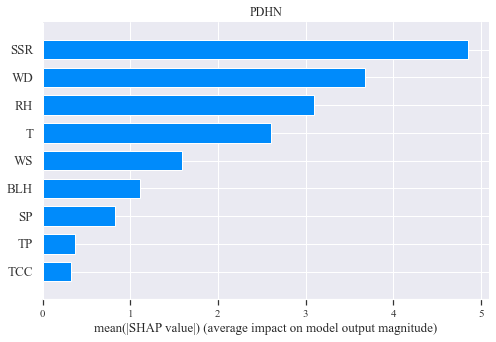

In [10]:
shp_values_marked = np.concatenate(shap_values,axis=0)[:,5:]
x_explain_marked = x_explain.iloc[:,5:]
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
type = 'bar'
plt.close()
sns.set(font='Times New Roman')
shap.summary_plot(shp_values_marked,x_explain_marked,show=False,cmap='jet',plot_type=type,dot_size=0.05)
plt.title('%s'%(sitename))
plt.savefig(r'%s/summary_plot_%s_%s_%s.png'%(resultDir,pol,type,sitename),dpi=300,bbox_inches='tight')

污染日总览图

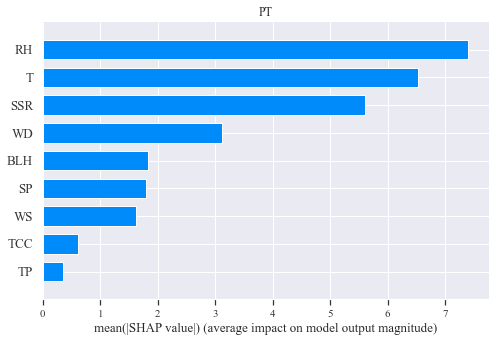

In [18]:
'''空气质量数据前处理'''
resultDir = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\summary\total'
aqData_path = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv'
aqData = pd.read_csv(aqData_path,parse_dates=['datetime'])
aqData = aqData.loc[aqData['sitename']==sitename]
# x_explain_marked
data1 = aqData.copy()
data1 = data1.loc[data1['datetime'].dt.date.isin(data1.loc[data1['O38']>(160/48*22.4)]['datetime'].dt.date.unique())]
data_new = pd.DataFrame()
for key,group in data1.groupby(data1['datetime'].dt.date):
    id = group['O38'].argmax()
    group = group.iloc[id-8:id,:]
    data_new = data_new.append(group)
data_new['date'] = data_new['datetime'].dt.strftime('%Y-%m-%d')

# rmwResult = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\%s_%s.csv'%(pol,sitename),parse_dates=['datetime'])
# rmwResult = rmwResult.set_index('datetime')
# rmwResult['contribution'] =  rmwResult['observation'] - rmwResult['predicts']
# rmwResult['date'] = rmwResult.index.strftime('%Y-%m-%d')
# rmwResult = rmwResult.loc[rmwResult['date'].isin(data_new['date'])]
# rmwResult = rmwResult.groupby(rmwResult.index.hour).mean()

x_explain_marked = x_explain.copy()
x_explain_marked['datetime'] = x_explain_marked.apply(lambda x:x['unix_time']*pd.Timedelta('1s') + pd.Timestamp("1970-01-01") + pd.Timedelta('%sh'%x['hour']),axis=1)
x_explain_marked = x_explain_marked.set_index('datetime')
x_explain_marked = x_explain_marked.iloc[:,5:]
x_explain_new = x_explain_marked.copy()
x_explain_new['date'] = x_explain_new.index.strftime('%Y-%m-%d')
x_explain_new = x_explain_new.loc[x_explain_new['date'].isin(data_new['date'])]
# x_explain_new = x_explain_new.groupby(x_explain_new.index.hour).mean()

shp_values_marked = np.concatenate(shap_values,axis=0)[:,5:]
shp_values_df = pd.DataFrame(shp_values_marked,columns = x_explain_marked.columns)
shp_values_df.index = x_explain_marked.index
shp_values_df['date'] = shp_values_df.index.strftime('%Y-%m-%d')
shp_values_df = shp_values_df.loc[shp_values_df['date'].isin(data_new['date'])]
# shp_values_df = shp_values_df.groupby(shp_values_df.index.hour).mean()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
type = 'bar'
plt.close()
sns.set(font='Times New Roman')
shap.summary_plot(shp_values_df.iloc[:,:-1].values,x_explain_new.iloc[:,:-1],show=False,cmap='jet',plot_type=type,dot_size=0.2)
plt.title('%s'%(sitename))
# plt.show()
plt.savefig(r'%s/summary_plot_pollutedDay_%s_%s_%s.png'%(resultDir,pol,type,sitename),dpi=300,bbox_inches='tight')

四季总览

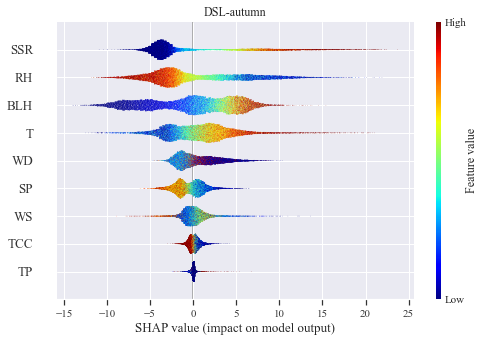

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
seasons = {'winter':[12,1,2],'spring':[3,4,5],'summer':[6,7,8],'autumn':[9,10,11]}
for key,months in seasons.items():
    shp_values_marked = np.concatenate(shap_values,axis=0)[:,5:]
    x_explain_marked = x_explain.iloc[:,5:]
    x_marked = x_explain.copy()
    x_marked['datetime'] = x_marked.apply(lambda x:x['unix_time']*pd.Timedelta('1s') + pd.Timestamp("1970-01-01") + pd.Timedelta('%sh'%x['hour']),axis=1)
    x_explain_marked = x_marked.set_index('datetime').iloc[:,5:]
    x_explain_new = x_explain_marked.loc[x_explain_marked.index.month.isin(months)]

    shp_values_df = pd.DataFrame(shp_values_marked)
    shp_values_df.columns = x_explain_marked.columns
    shp_values_df.index = x_explain_marked.index
    shp_values_df = shp_values_df.loc[shp_values_df.index.month.isin(months)]
    shp_values_new = np.array(shp_values_df)

    type = 'dot'
    plt.close()
    sns.set(font='Times New Roman')
    shap.summary_plot(shp_values_new,x_explain_new,show=False,cmap='jet',plot_type=type,dot_size=0.2)
    plt.title('%s-%s'%(sitename,key))
    plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\summary\DSL\summary_plot_%s_%s_%s_%s.png'%(type,pol,sitename,key),dpi=400,bbox_inches='tight')

四季气象贡献日变化

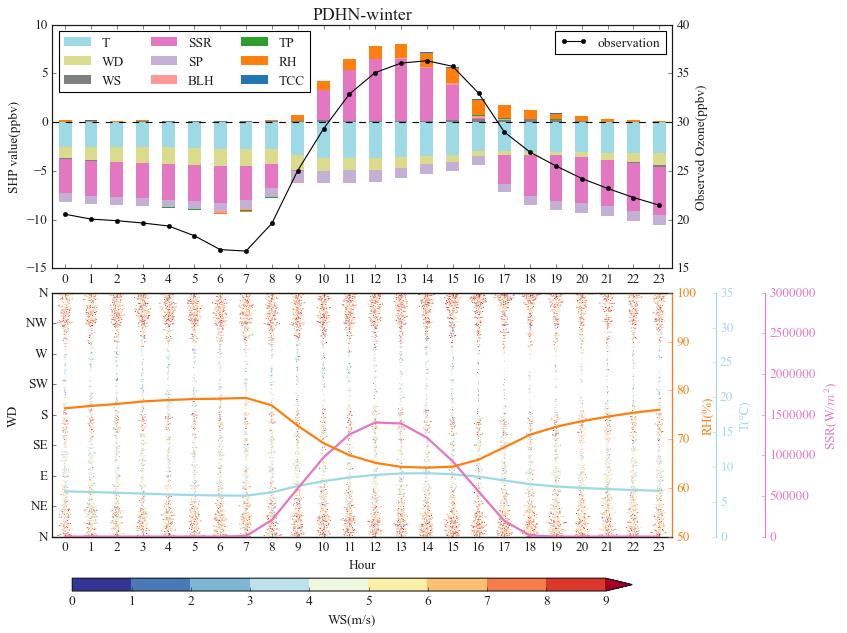

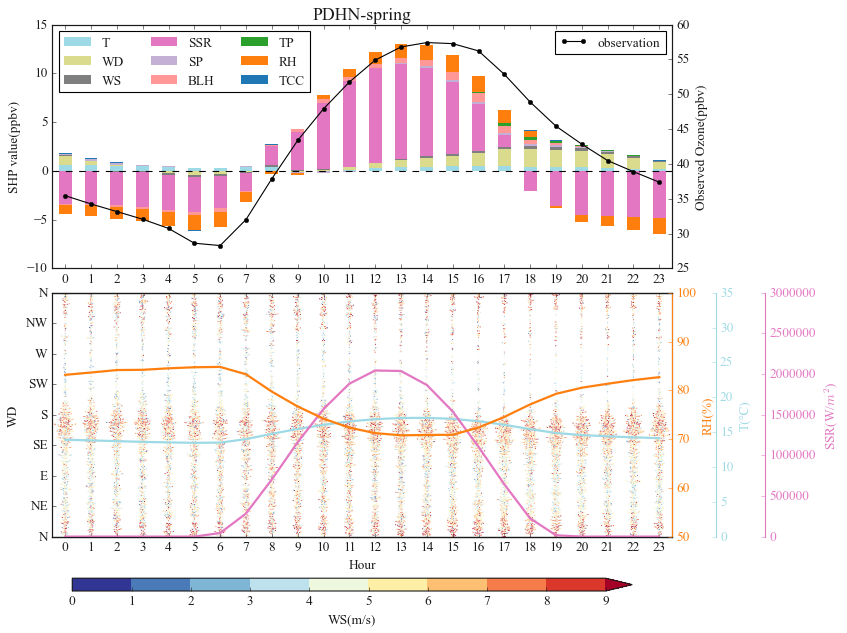

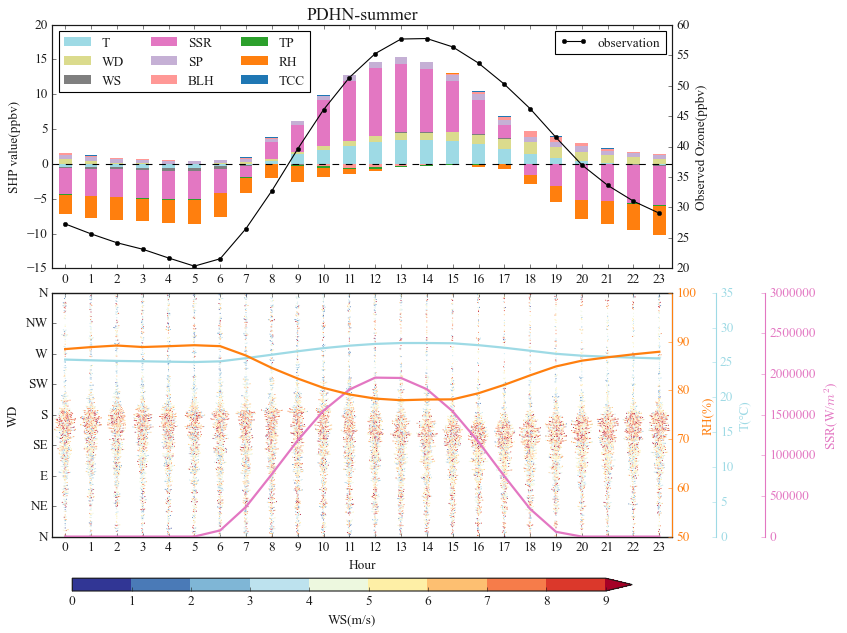

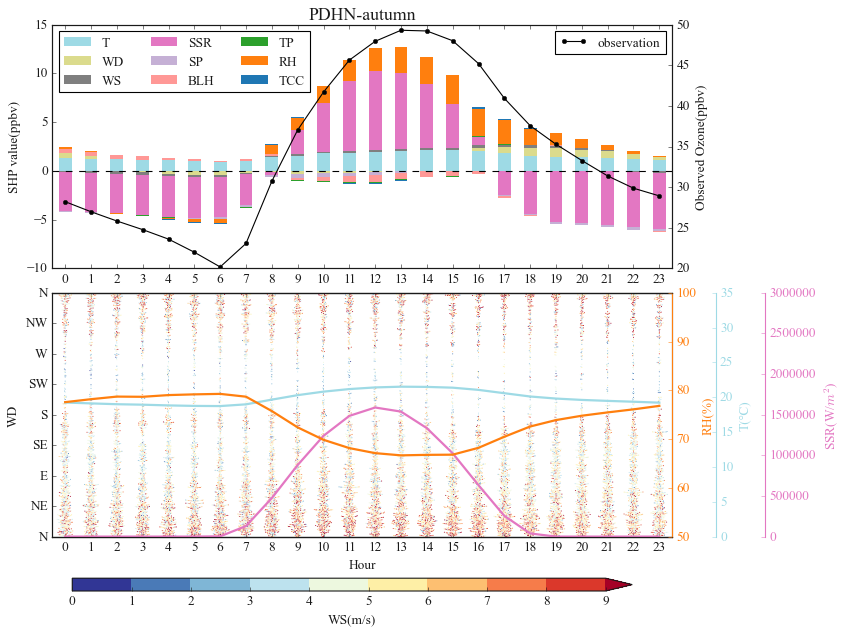

In [54]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
seasons = {'winter':[12,1,2],'spring':[3,4,5],'summer':[6,7,8],'autumn':[9,10,11]}
# for key,seasons[key] in seasons.items():
shp_values_marked = np.concatenate(shap_values,axis=0)[:,5:]
x_explain_marked = x_explain.iloc[:,5:]
x_marked = x_explain.copy()
x_marked['datetime'] = x_marked.apply(lambda x:x['unix_time']*pd.Timedelta('1s') + pd.Timestamp("1970-01-01") + pd.Timedelta('%sh'%x['hour']),axis=1)
x_explain_marked = x_marked.set_index('datetime').iloc[:,5:]
x_explain_new = x_explain_marked.copy()

shp_values_df = pd.DataFrame(shp_values_marked)
shp_values_df.columns = x_explain_marked.columns
shp_values_df.index = x_explain_marked.index

rmwResult = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\data\%s_%s.csv'%(pol,sitename),parse_dates=['datetime'])
rmwResult = rmwResult.set_index('datetime')
for key,season in seasons.items():

    x_explain_polluted = x_explain_new.loc[x_explain_new.index.month.isin(seasons[key])]
    x_explain_diurnal = x_explain_polluted.groupby(x_explain_polluted.index.hour).mean()

    x_explain_polluted1 = x_explain_polluted.copy()
    x_explain_polluted1['WD'] = x_explain_polluted1['WD'].apply(lambda x:round(x,0))
    x_explain_dirunalWD = x_explain_polluted1.groupby([x_explain_polluted1.index.hour,'WD']).size().unstack(level='WD')

    shp_values_df0 = shp_values_df.loc[shp_values_df.index.month.isin(seasons[key])]
    shp_values_new = np.array(shp_values_df0)

    rmwResult1 = rmwResult.loc[rmwResult.index.month.isin(seasons[key])]
    rmwResult1 = rmwResult1.groupby(rmwResult1.index.hour).mean()
    rmwResult1['contribution'] =  rmwResult1['observation'] - rmwResult1['predicts']

    # rmwResult
    shp_values_df1 = shp_values_df0.copy()
    # shp_values_sorted = shp_values_df1.apply(lambda x:np.mean(abs(x)),axis=0).sort_values(ascending=False)
    # shp_values_df1 = shp_values_df1[shp_values_sorted.index]
    shp_values_df1 = shp_values_df1.groupby(shp_values_df1.index.hour).mean()

    mpl.style.use('classic')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['font.sans-serif']=['Times New Roman']

    fig,ax = plt.subplots(2,1,figsize=(10,8))
    plt.subplots_adjust(hspace=0.1)
    ax_t = ax[0].twinx()
    ax_t1 = ax[1].twinx()
    ax_t2 = ax[1].twinx()
    ax_t3 = ax[1].twinx()
    ax2 = fig.add_axes([0.15,0.015,0.7,0.02])

    cmap = 'tab20_r'
    shp_values_df1.plot(kind='bar',stacked=True,lw=0,edgecolor=None,ax=ax[0],cmap=cmap)
    ax[0].axhline(0,color='black',lw=1,ls='--')
    ax[0].set_xticks(np.arange(0,24))
    # ax[0].set_
    ax[0].set_xticklabels(np.arange(0,24),rotation=0)
    ax[0].set_ylabel('SHP value(ppbv)')
    ax[0].set_xlabel(None)
    ax[0].legend(loc='upper left',edgecolor='black',shadow=False,frameon=True,ncol=3,fontsize= 12)
    ax[0].set_title('%s-%s'%(sitename,key),fontsize=16)

    ax_t.plot(rmwResult1.index,rmwResult1['observation'],color='black',lw=1,marker='o',markersize=4,label='observation')
    ax_t.set_ylabel('Observed Ozone(ppbv)')
    ax_t.legend(loc='upper right',edgecolor='black',shadow=False,frameon=True,fontsize=12)

    x_explain_polluted1 = x_explain_polluted.copy()
    x_explain_polluted1['WS'] = x_explain_polluted1['WS'].apply(lambda x:round(x,0))
    # x_explain_dirunalWD = x_explain_polluted1.groupby([x_explain_polluted1.index.hour,'WD']).size().unstack(level='WD')
    x_explain_polluted1['Hour'] = x_explain_polluted1.index.hour

    cmap = sns.color_palette("RdYlBu_r", as_cmap=True)
    norm = mpl.colors.BoundaryNorm(boundaries=np.arange(0,10,1), ncolors=256, extend='max')
    colors = {}
    for cval in x_explain_polluted1["WS"]:
        colors.update({cval : cmap(norm(cval))})

    sns.swarmplot(data = x_explain_polluted1,x='Hour',y='WD',hue='WS',s=0.9,\
        # cmap='tab20',
        palette = colors,
        alpha=1,
        ax=ax[1],
        )

    ax[1].get_legend().remove()
    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cb1.set_label('WS(m/s)')

    ax[1].set_yticks(np.arange(0,361,45))
    ax[1].set_ylim(0,360)
    ax[1].set_yticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
    ax[1].set_xticks(np.arange(0,24))
    ax[1].set_xticklabels(np.arange(0,24))
    ax[1].set_xlim(-0.5,23.5)
    ax[1].set_xlabel('Hour')

    ax_t3.plot(x_explain_diurnal.index,x_explain_diurnal['RH'],color='#ff7f0e',label='RH',lw=2,zorder=10)
    ax_t3.spines['right'].set_color('#ff7f0e')
    ax_t3.tick_params(axis='y', colors='#ff7f0e')
    ax_t3.set_ylabel('RH(%)',color='#ff7f0e')
    ax_t3.set_ylim(50,100)

    ax_t1.plot(x_explain_diurnal.index,x_explain_diurnal['T'],color='#9edae5',lw=2,label='T',zorder=10)
    ax_t1.tick_params(axis='y', colors='#9edae5')
    ax_t1.set_ylabel('T(℃)',color='#9edae5')
    ax_t1.spines['right'].set_position(("axes", 1.07))
    ax_t1.spines['left'].set_visible(False)
    ax_t1.spines['right'].set_color('#9edae5')
    ax_t1.set_ylim(0,35)

    ax_t2.plot(x_explain_diurnal.index,x_explain_diurnal['SSR'],color='#e377c2',lw=2,label='SSR',zorder=10)
    ax_t2.tick_params(axis='y', colors='#e377c2')
    ax_t2.set_ylabel('SSR(W/${m^2}$)',color='#e377c2')
    ax_t2.spines['right'].set_position(("axes", 1.15))
    ax_t2.spines['left'].set_visible(False)
    ax_t2.spines['right'].set_color('#e377c2')
    ax_t2.set_ylim(0,3000000)

    # plt.show()
    plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\diurnal\season\diurnal_contribution_%s_%s_%s.png'%(pol,sitename,key),dpi=400,bbox_inches='tight')

    # plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\diurnal_contribution_%s_%s_%s.png'%(pol,sitename,key),dpi=400,bbox_inches='tight')

某日气象贡献变化

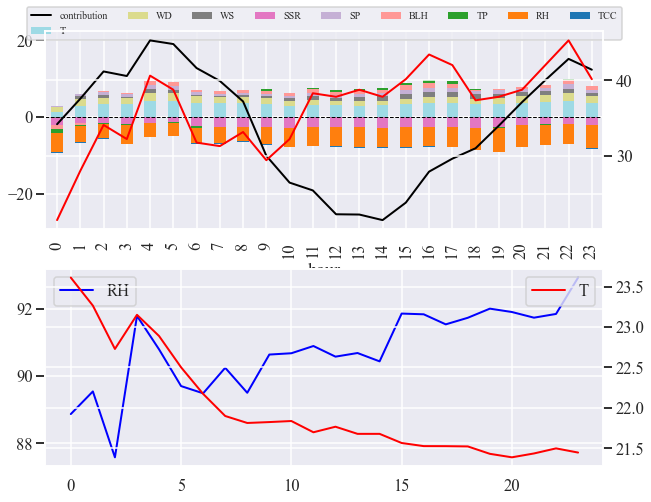

In [66]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

start = '2020-07-15 00:00:00'
end = '2020-07-15 23:00:00'
pol = 'O31'
sitename = 'PT'
rmwResult = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\%s_%s.csv'%(pol,sitename),parse_dates=['datetime'])
rmwResult = rmwResult.set_index('datetime')
rmwResult['contribution'] =  rmwResult['observation'] - rmwResult['predicts']
rmwResult = rmwResult.loc[start:end]
rmwResult['hour'] = rmwResult.index.hour
rmwResult = rmwResult.set_index('hour')
# print(rmwResult)

x_explain_marked = x_explain.copy()
x_explain_marked['datetime'] = x_explain_marked.apply(lambda x:x['unix_time']*pd.Timedelta('1s') + pd.Timestamp("1970-01-01") + pd.Timedelta('%sh'%x['hour']),axis=1)
# x_explain_marked['datetime'] = pd.to_datetime(x_explain_marked['datetime'])
x_explain_marked = x_explain_marked.set_index('datetime')
x_explain_marked = x_explain_marked.iloc[:,5:]
x_explain_new = x_explain_marked.loc[start:end]
x_explain_new.index = rmwResult.index

shp_values_marked = np.concatenate(shap_values,axis=0)[:,5:]
shp_values_df = pd.DataFrame(shp_values_marked,columns = x_explain_marked.columns)
shp_values_df.index = x_explain_marked.index
shp_values_df = shp_values_df.loc[start:end]
shp_values_df.index = rmwResult.index

sns.set(font='Times New Roman',context='talk')
fig,ax = plt.subplots(2,1,figsize=(10,8))
ax_t = ax[0].twinx()
ax_t1 = ax[1].twinx()


cmap = 'tab20_r'
# 前面深后面浅
shp_values_df.plot(kind='bar',stacked=True,lw=0,edgecolor=None,ax=ax[0],cmap=cmap)
# ax_t.plot(rmwResult.index,rmwResult['observation'],color='black',lw=2,label='observation',zorder=10)
ax[0].plot(rmwResult.index,rmwResult['contribution'],color='black',lw=2,label='contribution',zorder=10)

ax_t.plot(rmwResult.index,rmwResult['observation'],color='red',lw=2,label='predicts',zorder=10)

ax[1].plot(x_explain_new.index,x_explain_new['RH'],color='blue',lw=2,label='RH',zorder=10)
ax_t1.plot(x_explain_new.index,x_explain_new['T'],color='red',lw=2,label='T',zorder=10)
# ax.set_ylim(-14,14)
ax[0].axhline(0,lw=1,color='black',ls='--')
ax[0].legend(loc='upper center',bbox_to_anchor=(0.5,1.15),ncol=9,fontsize=10)
ax[1].legend(loc='upper left')
ax_t1.legend(loc='upper right')
plt.show()

污染日气象贡献-仅气象

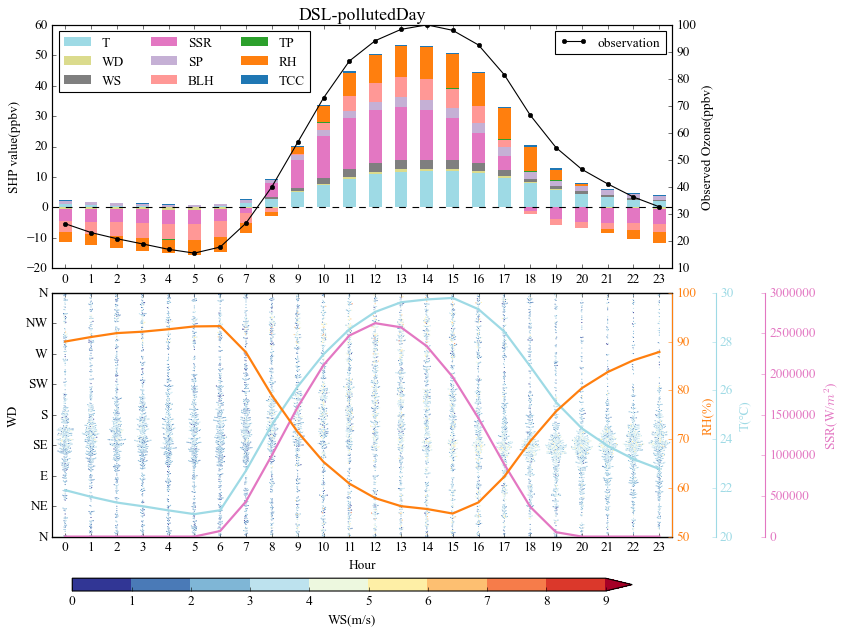

In [21]:
'''空气质量数据前处理'''
aqData_path = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv'
aqData = pd.read_csv(aqData_path,parse_dates=['datetime'])
aqData = aqData.loc[aqData['sitename']==sitename]
# x_explain_marked
data1 = aqData.copy()
data1 = data1.loc[data1['datetime'].dt.date.isin(data1.loc[data1['O38']>(160/48*22.4)]['datetime'].dt.date.unique())]
data_new = pd.DataFrame()
for key,group in data1.groupby(data1['datetime'].dt.date):
    id = group['O38'].argmax()
    group = group.iloc[id-8:id,:]
    data_new = data_new.append(group)
data_new['date'] = data_new['datetime'].dt.strftime('%Y-%m-%d')
# pollutedDay = combinedData.copy()
# pollutedDay['date'] = pollutedDay['datetime'].dt.strftime('%Y-%m-%d')
# pollutedDay = pollutedDay.loc[pollutedDay['date'].isin(data_new['date'])]

rmwResult = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\data\%s_%s.csv'%(pol,sitename),parse_dates=['datetime'])
rmwResult = rmwResult.set_index('datetime')
rmwResult['contribution'] =  rmwResult['observation'] - rmwResult['predicts']
rmwResult['date'] = rmwResult.index.strftime('%Y-%m-%d')
rmwResult = rmwResult.loc[rmwResult['date'].isin(data_new['date'])]
rmwResult = rmwResult.groupby(rmwResult.index.hour).mean()

x_explain_marked = x_explain.copy()
x_explain_marked['datetime'] = x_explain_marked.apply(lambda x:x['unix_time']*pd.Timedelta('1s') + pd.Timestamp("1970-01-01") + pd.Timedelta('%sh'%x['hour']),axis=1)
x_explain_marked = x_explain_marked.set_index('datetime')
x_explain_marked = x_explain_marked.iloc[:,5:]
# x_explain_new = x_explain_marked.copy()
x_explain_new['date'] = x_explain_new.index.strftime('%Y-%m-%d')
x_explain_polluted = x_explain_new.loc[x_explain_new['date'].isin(data_new['date'])]
x_explain_diurnal = x_explain_polluted.groupby(x_explain_polluted.index.hour).mean()

x_explain_polluted1 = x_explain_polluted.copy()
x_explain_polluted1['WD'] = x_explain_polluted1['WD'].apply(lambda x:round(x,0))
x_explain_dirunalWD = x_explain_polluted1.groupby([x_explain_polluted1.index.hour,'WD']).size().unstack(level='WD')

shp_values_marked = np.concatenate(shap_values,axis=0)[:,5:]
# shp_values_marked = np.concatenate(shap_values,axis=0)

shp_values_df = pd.DataFrame(shp_values_marked,columns = x_explain_marked.columns)
shp_values_df.index = x_explain_marked.index
shp_values_df['date'] = shp_values_df.index.strftime('%Y-%m-%d')
shp_values_df = shp_values_df.loc[shp_values_df['date'].isin(data_new['date'])]
shp_values_df = shp_values_df.groupby(shp_values_df.index.hour).mean()

mpl.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['Times New Roman']

fig,ax = plt.subplots(2,1,figsize=(10,8))
plt.subplots_adjust(hspace=0.1)
ax_t = ax[0].twinx()
ax_t1 = ax[1].twinx()
ax_t2 = ax[1].twinx()
ax_t3 = ax[1].twinx()
ax2 = fig.add_axes([0.15,0.015,0.7,0.02])

cmap = 'tab20_r'
shp_values_df.plot(kind='bar',stacked=True,lw=0,edgecolor=None,ax=ax[0],cmap=cmap)
ax[0].axhline(0,color='black',lw=1,ls='--')
ax[0].set_xticks(np.arange(0,24))
ax[0].set_xticklabels(np.arange(0,24),rotation=0)
ax[0].set_ylabel('SHP value(ppbv)')
ax[0].set_xlabel(None)
ax[0].legend(loc='upper left',edgecolor='black',shadow=False,frameon=True,ncol=3,fontsize= 12)
ax[0].set_title('%s-%s'%(sitename,'pollutedDay'),fontsize=16)
# ax[0].set_ylim(-20,70)
# ax_t.plot(rmwResult.index,rmwResult['observation']-explainer.expected_value,color='black',lw=1,marker='o',markersize=4,label='observation')
# ax_t.set_ylabel('Ozone Increment(ppbv)')
# ax_t.set_ylim(-20,70)

ax_t.plot(rmwResult.index,rmwResult['observation'],color='black',lw=1,marker='o',markersize=4,label='observation')
ax_t.set_ylabel('Observed Ozone(ppbv)')

ax_t.legend(loc='upper right',edgecolor='black',shadow=False,frameon=True,fontsize=12)

x_explain_polluted1 = x_explain_polluted.copy()
x_explain_polluted1['WS'] = x_explain_polluted1['WS'].apply(lambda x:round(x,0))
# x_explain_dirunalWD = x_explain_polluted1.groupby([x_explain_polluted1.index.hour,'WD']).size().unstack(level='WD')
x_explain_polluted1['Hour'] = x_explain_polluted1.index.hour

cmap = sns.color_palette("RdYlBu_r", as_cmap=True)
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(0,10,1), ncolors=256, extend='max')
colors = {}
for cval in x_explain_polluted1["WS"]:
    colors.update({cval : cmap(norm(cval))})

sns.swarmplot(data = x_explain_polluted1,x='Hour',y='WD',hue='WS',s=1,\
    # cmap='tab20',
    palette = colors,
    alpha=1,
    ax=ax[1],
    )

ax[1].get_legend().remove()
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('WS(m/s)')

ax[1].set_yticks(np.arange(0,361,45))
ax[1].set_ylim(0,360)
ax[1].set_yticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
ax[1].set_xticks(np.arange(0,24))
ax[1].set_xticklabels(np.arange(0,24))
ax[1].set_xlim(-0.5,23.5)
ax[1].set_xlabel('Hour')

ax_t3.plot(x_explain_diurnal.index,x_explain_diurnal['RH'],color='#ff7f0e',label='RH',lw=2,zorder=10)
ax_t3.spines['right'].set_color('#ff7f0e')
ax_t3.tick_params(axis='y', colors='#ff7f0e')
ax_t3.set_ylabel('RH(%)',color='#ff7f0e')
ax_t3.set_ylim(50,100)

ax_t1.plot(x_explain_diurnal.index,x_explain_diurnal['T'],color='#9edae5',lw=2,label='T',zorder=10)
ax_t1.tick_params(axis='y', colors='#9edae5')
ax_t1.set_ylabel('T(℃)',color='#9edae5')
ax_t1.spines['right'].set_position(("axes", 1.07))
ax_t1.spines['left'].set_visible(False)
ax_t1.spines['right'].set_color('#9edae5')
ax_t1.set_ylim(20,30)

ax_t2.plot(x_explain_diurnal.index,x_explain_diurnal['SSR'],color='#e377c2',lw=2,label='SSR',zorder=10)
ax_t2.tick_params(axis='y', colors='#e377c2')
ax_t2.set_ylabel('SSR(W/${m^2}$)',color='#e377c2')
ax_t2.spines['right'].set_position(("axes", 1.15))
ax_t2.spines['left'].set_visible(False)
ax_t2.spines['right'].set_color('#e377c2')
ax_t2.set_ylim(0,3000000)

# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\diurnal\pollutedDay\diurnal_contribution_%s_%s_%s.png'%(pol,sitename,'polluted'),dpi=400,bbox_inches='tight')

# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\diurnal_contribution_%s_%s_%s.png'%(pol,sitename,'polluted'),dpi=400,bbox_inches='tight')

污染日气象日变化-所有变量

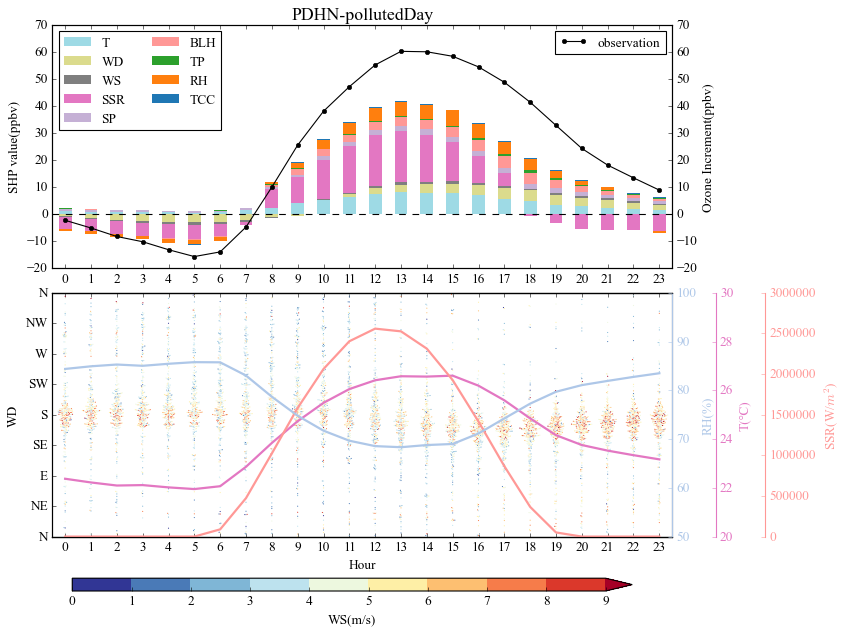

In [32]:
'''空气质量数据前处理'''
aqData_path = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv'
aqData = pd.read_csv(aqData_path,parse_dates=['datetime'])
aqData = aqData.loc[aqData['sitename']==sitename]
# x_explain_marked
data1 = aqData.copy()
data1 = data1.loc[data1['datetime'].dt.date.isin(data1.loc[data1['O38']>(160/48*22.4)]['datetime'].dt.date.unique())]
data_new = pd.DataFrame()
for key,group in data1.groupby(data1['datetime'].dt.date):
    id = group['O38'].argmax()
    group = group.iloc[id-8:id,:]
    data_new = data_new.append(group)
data_new['date'] = data_new['datetime'].dt.strftime('%Y-%m-%d')
# pollutedDay = combinedData.copy()
# pollutedDay['date'] = pollutedDay['datetime'].dt.strftime('%Y-%m-%d')
# pollutedDay = pollutedDay.loc[pollutedDay['date'].isin(data_new['date'])]

rmwResult = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\data\%s_%s.csv'%(pol,sitename),parse_dates=['datetime'])
rmwResult = rmwResult.set_index('datetime')
rmwResult['contribution'] =  rmwResult['observation'] - rmwResult['predicts']
rmwResult['date'] = rmwResult.index.strftime('%Y-%m-%d')
rmwResult = rmwResult.loc[rmwResult['date'].isin(data_new['date'])]
rmwResult = rmwResult.groupby(rmwResult.index.hour).mean()

x_explain_marked = x_explain.copy()
x_explain_marked['datetime'] = x_explain_marked.apply(lambda x:x['unix_time']*pd.Timedelta('1s') + pd.Timestamp("1970-01-01") + pd.Timedelta('%sh'%x['hour']),axis=1)
x_explain_marked = x_explain_marked.set_index('datetime')
x_explain_marked = x_explain_marked.iloc[:,5:]
x_explain_new = x_explain_marked.copy()
x_explain_new['date'] = x_explain_new.index.strftime('%Y-%m-%d')
x_explain_polluted = x_explain_new.loc[x_explain_new['date'].isin(data_new['date'])]
x_explain_diurnal = x_explain_polluted.groupby(x_explain_polluted.index.hour).mean()

x_explain_polluted1 = x_explain_polluted.copy()
x_explain_polluted1['WD'] = x_explain_polluted1['WD'].apply(lambda x:round(x,0))
x_explain_dirunalWD = x_explain_polluted1.groupby([x_explain_polluted1.index.hour,'WD']).size().unstack(level='WD')

shp_values_marked = np.concatenate(shap_values,axis=0)[:,5:]
# shp_values_marked = np.concatenate(shap_values,axis=0)

shp_values_df = pd.DataFrame(shp_values_marked,columns = x_explain_marked.columns)
shp_values_df.index = x_explain_marked.index
shp_values_df['date'] = shp_values_df.index.strftime('%Y-%m-%d')
shp_values_df = shp_values_df.loc[shp_values_df['date'].isin(data_new['date'])]
shp_values_df = shp_values_df.groupby(shp_values_df.index.hour).mean()

mpl.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['Times New Roman']

fig,ax = plt.subplots(2,1,figsize=(10,8))
plt.subplots_adjust(hspace=0.1)
ax_t = ax[0].twinx()
ax_t1 = ax[1].twinx()
ax_t2 = ax[1].twinx()
ax_t3 = ax[1].twinx()
ax2 = fig.add_axes([0.15,0.015,0.7,0.02])

cmap = 'tab20_r'
shp_values_df.plot(kind='bar',stacked=True,lw=0,edgecolor=None,ax=ax[0],cmap=cmap)
ax[0].axhline(0,color='black',lw=1,ls='--')
ax[0].set_xticks(np.arange(0,24))
ax[0].set_xticklabels(np.arange(0,24),rotation=0)
ax[0].set_ylabel('SHP value(ppbv)')
ax[0].set_xlabel(None)
ax[0].legend(loc='upper left',edgecolor='black',shadow=False,frameon=True,ncol=2,fontsize= 12)
ax[0].set_title('%s-%s'%(sitename,'pollutedDay'),fontsize=16)
ax[0].set_ylim(-20,70)
ax_t.plot(rmwResult.index,rmwResult['observation']-explainer.expected_value,color='black',lw=1,marker='o',markersize=4,label='observation')
ax_t.set_ylabel('Ozone Increment(ppbv)')
ax_t.set_ylim(-20,70)

# ax_t.plot(rmwResult.index,rmwResult['observation'],color='black',lw=1,marker='o',markersize=4,label='observation')
# ax_t.set_ylabel('Observed Ozone(ppbv)')

ax_t.legend(loc='upper right',edgecolor='black',shadow=False,frameon=True,fontsize=12)

x_explain_polluted1 = x_explain_polluted.copy()
x_explain_polluted1['WS'] = x_explain_polluted1['WS'].apply(lambda x:round(x,0))
# x_explain_dirunalWD = x_explain_polluted1.groupby([x_explain_polluted1.index.hour,'WD']).size().unstack(level='WD')
x_explain_polluted1['Hour'] = x_explain_polluted1.index.hour

cmap = sns.color_palette("RdYlBu_r", as_cmap=True)
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(0,10,1), ncolors=256, extend='max')
colors = {}
for cval in x_explain_polluted1["WS"]:
    colors.update({cval : cmap(norm(cval))})

sns.swarmplot(data = x_explain_polluted1,x='Hour',y='WD',hue='WS',s=1,\
    # cmap='tab20',
    palette = colors,
    alpha=1,
    ax=ax[1],
    )

ax[1].get_legend().remove()
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('WS(m/s)')

ax[1].set_yticks(np.arange(0,361,45))
ax[1].set_ylim(0,360)
ax[1].set_yticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
ax[1].set_xticks(np.arange(0,24))
ax[1].set_xticklabels(np.arange(0,24))
ax[1].set_xlim(-0.5,23.5)
ax[1].set_xlabel('Hour')

ax_t3.plot(x_explain_diurnal.index,x_explain_diurnal['RH'],color='#aec7e8',label='RH',lw=2,zorder=10)
ax_t3.spines['right'].set_color('#aec7e8')
ax_t3.tick_params(axis='y', colors='#aec7e8')
ax_t3.set_ylabel('RH(%)',color='#aec7e8')
ax_t3.set_ylim(50,100)

ax_t1.plot(x_explain_diurnal.index,x_explain_diurnal['T'],color='#e377c2',lw=2,label='T',zorder=10)
ax_t1.tick_params(axis='y', colors='#e377c2')
ax_t1.set_ylabel('T(℃)',color='#e377c2')
ax_t1.spines['right'].set_position(("axes", 1.07))
ax_t1.spines['left'].set_visible(False)
ax_t1.spines['right'].set_color('#e377c2')
ax_t1.set_ylim(20,30)

ax_t2.plot(x_explain_diurnal.index,x_explain_diurnal['SSR'],color='#ff9896',lw=2,label='SSR',zorder=10)
ax_t2.tick_params(axis='y', colors='#ff9896')
ax_t2.set_ylabel('SSR(W/${m^2}$)',color='#ff9896')
ax_t2.spines['right'].set_position(("axes", 1.15))
ax_t2.spines['left'].set_visible(False)
ax_t2.spines['right'].set_color('#ff9896')
ax_t2.set_ylim(0,3000000)

# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\diurnal\pollutedDayNotime\diurnal_contribution_%s_%s_%s.png'%(pol,sitename,'polluted'),dpi=400,bbox_inches='tight')

# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\diurnal_contribution_%s_%s_%s.png'%(pol,sitename,'polluted'),dpi=400,bbox_inches='tight')

非污染日气象日变化-仅气象变量

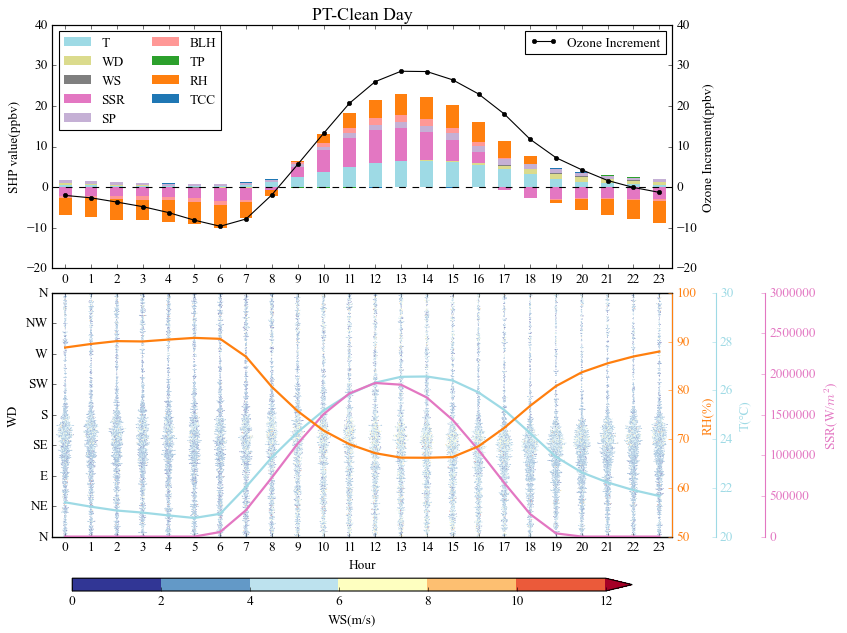

In [71]:
'''空气质量数据前处理'''
aqData_path = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv'
aqData = pd.read_csv(aqData_path,parse_dates=['datetime'])
aqData = aqData.loc[aqData['sitename']==sitename]
# x_explain_marked
data1 = aqData.copy()
data1 = data1.loc[data1['datetime'].dt.date.isin(data1.loc[data1['O38']<(160/48*22.4)]['datetime'].dt.date.unique())]
data1 = data1.loc[(data1['datetime'].dt.month>3)&(data1['datetime'].dt.month<10)]
data1['date'] = data1['datetime'].dt.strftime('%Y-%m-%d')

rmwResult = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\data\%s_%s.csv'%(pol,sitename),parse_dates=['datetime'])
rmwResult = rmwResult.set_index('datetime')
rmwResult['contribution'] =  rmwResult['observation'] - rmwResult['predicts']
rmwResult['date'] = rmwResult.index.strftime('%Y-%m-%d')
rmwResult = rmwResult.loc[rmwResult['date'].isin(data1['date'])]
rmwResult = rmwResult.groupby(rmwResult.index.hour).mean()

x_explain_marked = x_explain.copy()
x_explain_marked['datetime'] = x_explain_marked.apply(lambda x:x['unix_time']*pd.Timedelta('1s') + pd.Timestamp("1970-01-01") + pd.Timedelta('%sh'%x['hour']),axis=1)
x_explain_marked = x_explain_marked.set_index('datetime')
x_explain_marked = x_explain_marked.iloc[:,5:]
x_explain_new = x_explain_marked.copy()
x_explain_new['date'] = x_explain_new.index.strftime('%Y-%m-%d')
x_explain_polluted = x_explain_new.loc[x_explain_new['date'].isin(data1['date'])]
x_explain_diurnal = x_explain_polluted.groupby(x_explain_polluted.index.hour).mean()

x_explain_polluted1 = x_explain_polluted.copy()
x_explain_polluted1['WD'] = x_explain_polluted1['WD'].apply(lambda x:round(x,0))
x_explain_dirunalWD = x_explain_polluted1.groupby([x_explain_polluted1.index.hour,'WD']).size().unstack(level='WD')

shp_values_marked = np.concatenate(shap_values,axis=0)[:,5:]
# shp_values_marked = np.concatenate(shap_values,axis=0)

shp_values_df = pd.DataFrame(shp_values_marked,columns = x_explain_marked.columns)
shp_values_df.index = x_explain_marked.index
shp_values_df['date'] = shp_values_df.index.strftime('%Y-%m-%d')
shp_values_df = shp_values_df.loc[shp_values_df['date'].isin(data1['date'])]
shp_values_df = shp_values_df.groupby(shp_values_df.index.hour).mean()

mpl.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['Times New Roman']

fig,ax = plt.subplots(2,1,figsize=(10,8))
plt.subplots_adjust(hspace=0.1)
ax_t = ax[0].twinx()
ax_t1 = ax[1].twinx()
ax_t2 = ax[1].twinx()
ax_t3 = ax[1].twinx()
ax2 = fig.add_axes([0.15,0.015,0.7,0.02])

cmap = 'tab20_r'
shp_values_df.plot(kind='bar',stacked=True,lw=0,edgecolor=None,ax=ax[0],cmap=cmap)
ax[0].axhline(0,color='black',lw=1,ls='--')
ax[0].set_xticks(np.arange(0,24))
ax[0].set_xticklabels(np.arange(0,24),rotation=0)
ax[0].set_ylabel('SHP value(ppbv)')
ax[0].set_xlabel(None)
ax[0].legend(loc='upper left',edgecolor='black',shadow=False,frameon=True,ncol=2,fontsize= 12)
ax[0].set_title('%s-%s'%(sitename,'Clean Day'),fontsize=16)
ax[0].set_ylim(-20,40)
ax_t.plot(rmwResult.index,rmwResult['observation']-explainer.expected_value,color='black',lw=1,marker='o',markersize=4,label='Ozone Increment')
ax_t.set_ylabel('Ozone Increment(ppbv)')
ax_t.set_ylim(-20,40)

# ax_t.plot(rmwResult.index,rmwResult['observation'],color='black',lw=1,marker='o',markersize=4,label='observation')
# ax_t.set_ylabel('Observed Ozone(ppbv)')

ax_t.legend(loc='upper right',edgecolor='black',shadow=False,frameon=True,fontsize=12)

x_explain_polluted1 = x_explain_polluted.copy()
x_explain_polluted1['WS'] = x_explain_polluted1['WS'].apply(lambda x:round(x,0))
# x_explain_dirunalWD = x_explain_polluted1.groupby([x_explain_polluted1.index.hour,'WD']).size().unstack(level='WD')
x_explain_polluted1['Hour'] = x_explain_polluted1.index.hour

cmap = sns.color_palette("RdYlBu_r", as_cmap=True)
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(0,14,2), ncolors=256, extend='max')
colors = {}
for cval in x_explain_polluted1["WS"]:
    colors.update({cval : cmap(norm(cval))})

sns.swarmplot(data = x_explain_polluted1,x='Hour',y='WD',hue='WS',s=0.6,\
    # cmap='tab20',
    palette = colors,
    alpha=1,
    ax=ax[1],
    )

ax[1].get_legend().remove()
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('WS(m/s)')

ax[1].set_yticks(np.arange(0,361,45))
ax[1].set_ylim(0,360)
ax[1].set_yticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
ax[1].set_xticks(np.arange(0,24))
ax[1].set_xticklabels(np.arange(0,24))
ax[1].set_xlim(-0.5,23.5)
ax[1].set_xlabel('Hour')

ax_t3.plot(x_explain_diurnal.index,x_explain_diurnal['RH'],color='#ff7f0e',label='RH',lw=2,zorder=10)
ax_t3.spines['right'].set_color('#ff7f0e')
ax_t3.tick_params(axis='y', colors='#ff7f0e')
ax_t3.set_ylabel('RH(%)',color='#ff7f0e')
ax_t3.set_ylim(50,100)

ax_t1.plot(x_explain_diurnal.index,x_explain_diurnal['T'],color='#9edae5',lw=2,label='T',zorder=10)
ax_t1.tick_params(axis='y', colors='#9edae5')
ax_t1.set_ylabel('T(℃)',color='#9edae5')
ax_t1.spines['right'].set_position(("axes", 1.07))
ax_t1.spines['left'].set_visible(False)
ax_t1.spines['right'].set_color('#9edae5')
ax_t1.set_ylim(20,30)

ax_t2.plot(x_explain_diurnal.index,x_explain_diurnal['SSR'],color='#e377c2',lw=2,label='SSR',zorder=10)
ax_t2.tick_params(axis='y', colors='#e377c2')
ax_t2.set_ylabel('SSR(W/${m^2}$)',color='#e377c2')
ax_t2.spines['right'].set_position(("axes", 1.15))
ax_t2.spines['left'].set_visible(False)
ax_t2.spines['right'].set_color('#e377c2')
ax_t2.set_ylim(0,3000000)

# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\diurnal\CleanDay\diurnal_contribution_%s_%s_%s.png'%(pol,sitename,'polluted'),dpi=400,bbox_inches='tight')

# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\diurnal_contribution_%s_%s_%s.png'%(pol,sitename,'polluted'),dpi=400,bbox_inches='tight')

非污染日气象日变化-所有变量

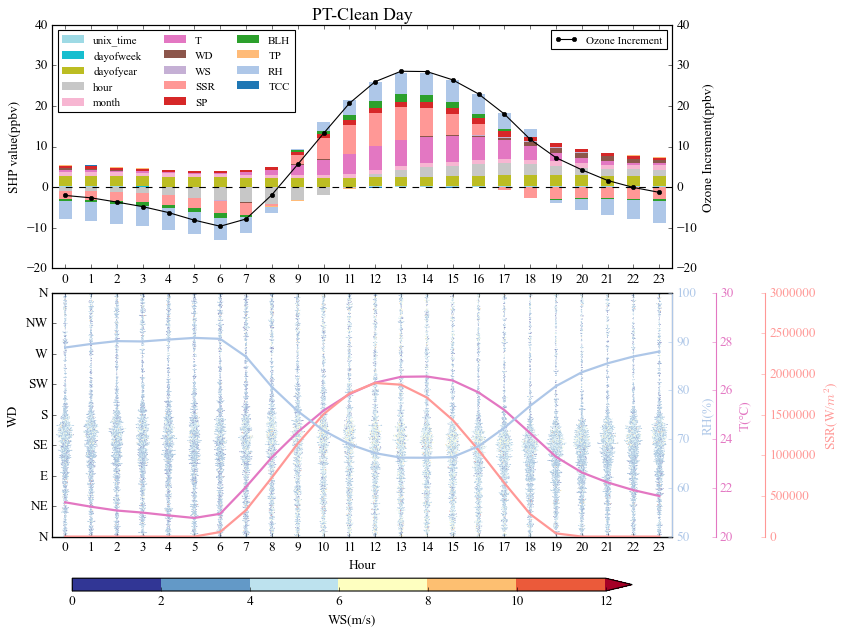

In [72]:
'''空气质量数据前处理'''
aqData_path = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv'
aqData = pd.read_csv(aqData_path,parse_dates=['datetime'])
aqData = aqData.loc[aqData['sitename']==sitename]
# x_explain_marked
data1 = aqData.copy()
data1 = data1.loc[data1['datetime'].dt.date.isin(data1.loc[data1['O38']<(160/48*22.4)]['datetime'].dt.date.unique())]
data1 = data1.loc[(data1['datetime'].dt.month>3)&(data1['datetime'].dt.month<10)]
data1['date'] = data1['datetime'].dt.strftime('%Y-%m-%d')

rmwResult = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\data\%s_%s.csv'%(pol,sitename),parse_dates=['datetime'])
rmwResult = rmwResult.set_index('datetime')
rmwResult['contribution'] =  rmwResult['observation'] - rmwResult['predicts']
rmwResult['date'] = rmwResult.index.strftime('%Y-%m-%d')
rmwResult = rmwResult.loc[rmwResult['date'].isin(data1['date'])]
rmwResult = rmwResult.groupby(rmwResult.index.hour).mean()

x_explain_marked = x_explain.copy()
x_explain_marked['datetime'] = x_explain_marked.apply(lambda x:x['unix_time']*pd.Timedelta('1s') + pd.Timestamp("1970-01-01") + pd.Timedelta('%sh'%x['hour']),axis=1)
x_explain_marked = x_explain_marked.set_index('datetime')
# x_explain_marked = x_explain_marked.iloc[:,5:]
x_explain_new = x_explain_marked.copy()
x_explain_new['date'] = x_explain_new.index.strftime('%Y-%m-%d')
x_explain_polluted = x_explain_new.loc[x_explain_new['date'].isin(data1['date'])]
x_explain_diurnal = x_explain_polluted.groupby(x_explain_polluted.index.hour).mean()

x_explain_polluted1 = x_explain_polluted.copy()
x_explain_polluted1['WD'] = x_explain_polluted1['WD'].apply(lambda x:round(x,0))
x_explain_dirunalWD = x_explain_polluted1.groupby([x_explain_polluted1.index.hour,'WD']).size().unstack(level='WD')

# shp_values_marked = np.concatenate(shap_values,axis=0)[:,5:]
shp_values_marked = np.concatenate(shap_values,axis=0)

shp_values_df = pd.DataFrame(shp_values_marked,columns = x_explain_marked.columns)
shp_values_df.index = x_explain_marked.index
shp_values_df['date'] = shp_values_df.index.strftime('%Y-%m-%d')
shp_values_df = shp_values_df.loc[shp_values_df['date'].isin(data1['date'])]
shp_values_df = shp_values_df.groupby(shp_values_df.index.hour).mean()

mpl.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['Times New Roman']

fig,ax = plt.subplots(2,1,figsize=(10,8))
plt.subplots_adjust(hspace=0.1)
ax_t = ax[0].twinx()
ax_t1 = ax[1].twinx()
ax_t2 = ax[1].twinx()
ax_t3 = ax[1].twinx()
ax2 = fig.add_axes([0.15,0.015,0.7,0.02])

cmap = 'tab20_r'
shp_values_df.plot(kind='bar',stacked=True,lw=0,edgecolor=None,ax=ax[0],cmap=cmap)
ax[0].axhline(0,color='black',lw=1,ls='--')
ax[0].set_xticks(np.arange(0,24))
ax[0].set_xticklabels(np.arange(0,24),rotation=0)
ax[0].set_ylabel('SHP value(ppbv)')
ax[0].set_xlabel(None)
ax[0].legend(loc='upper left',edgecolor='black',shadow=False,frameon=True,ncol=3,fontsize= 10)
ax[0].set_title('%s-%s'%(sitename,'Clean Day'),fontsize=16)
ax[0].set_ylim(-20,40)
ax_t.plot(rmwResult.index,rmwResult['observation']-explainer.expected_value,color='black',lw=1,marker='o',markersize=4,label='Ozone Increment')
ax_t.set_ylabel('Ozone Increment(ppbv)')
ax_t.set_ylim(-20,40)

# ax_t.plot(rmwResult.index,rmwResult['observation'],color='black',lw=1,marker='o',markersize=4,label='observation')
# ax_t.set_ylabel('Observed Ozone(ppbv)')

ax_t.legend(loc='upper right',edgecolor='black',shadow=False,frameon=True,fontsize=10)

x_explain_polluted1 = x_explain_polluted.copy()
x_explain_polluted1['WS'] = x_explain_polluted1['WS'].apply(lambda x:round(x,0))
# x_explain_dirunalWD = x_explain_polluted1.groupby([x_explain_polluted1.index.hour,'WD']).size().unstack(level='WD')
x_explain_polluted1['Hour'] = x_explain_polluted1.index.hour

cmap = sns.color_palette("RdYlBu_r", as_cmap=True)
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(0,14,2), ncolors=256, extend='max')
colors = {}
for cval in x_explain_polluted1["WS"]:
    colors.update({cval : cmap(norm(cval))})

sns.swarmplot(data = x_explain_polluted1,x='Hour',y='WD',hue='WS',s=0.6,\
    # cmap='tab20',
    palette = colors,
    alpha=1,
    ax=ax[1],
    )

ax[1].get_legend().remove()
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('WS(m/s)')

ax[1].set_yticks(np.arange(0,361,45))
ax[1].set_ylim(0,360)
ax[1].set_yticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
ax[1].set_xticks(np.arange(0,24))
ax[1].set_xticklabels(np.arange(0,24))
ax[1].set_xlim(-0.5,23.5)
ax[1].set_xlabel('Hour')

ax_t3.plot(x_explain_diurnal.index,x_explain_diurnal['RH'],color='#aec7e8',label='RH',lw=2,zorder=10)
ax_t3.spines['right'].set_color('#aec7e8')
ax_t3.tick_params(axis='y', colors='#aec7e8')
ax_t3.set_ylabel('RH(%)',color='#aec7e8')
ax_t3.set_ylim(50,100)

ax_t1.plot(x_explain_diurnal.index,x_explain_diurnal['T'],color='#e377c2',lw=2,label='T',zorder=10)
ax_t1.tick_params(axis='y', colors='#e377c2')
ax_t1.set_ylabel('T(℃)',color='#e377c2')
ax_t1.spines['right'].set_position(("axes", 1.07))
ax_t1.spines['left'].set_visible(False)
ax_t1.spines['right'].set_color('#e377c2')
ax_t1.set_ylim(20,30)

ax_t2.plot(x_explain_diurnal.index,x_explain_diurnal['SSR'],color='#ff9896',lw=2,label='SSR',zorder=10)
ax_t2.tick_params(axis='y', colors='#ff9896')
ax_t2.set_ylabel('SSR(W/${m^2}$)',color='#ff9896')
ax_t2.spines['right'].set_position(("axes", 1.15))
ax_t2.spines['left'].set_visible(False)
ax_t2.spines['right'].set_color('#ff9896')
ax_t2.set_ylim(0,3000000)

# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\diurnal\cleanDaywithtime\diurnal_contribution_%s_%s_%s.png'%(pol,sitename,'polluted'),dpi=400,bbox_inches='tight')

# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\diurnal_contribution_%s_%s_%s.png'%(pol,sitename,'polluted'),dpi=400,bbox_inches='tight')

#### 污染日依赖图

In [84]:
'''空气质量数据前处理'''
aqData_path = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv'
aqData = pd.read_csv(aqData_path,parse_dates=['datetime'])
aqData = aqData.loc[aqData['sitename']==sitename]
# x_explain_marked
data1 = aqData.copy()
data1 = data1.loc[data1['datetime'].dt.date.isin(data1.loc[data1['O38']>(160/48*22.4)]['datetime'].dt.date.unique())]
data_new = pd.DataFrame()
for key,group in data1.groupby(data1['datetime'].dt.date):
    id = group['O38'].argmax()
    group = group.iloc[id-8:id,:]
    data_new = data_new.append(group)
data_new['date'] = data_new['datetime'].dt.strftime('%Y-%m-%d')
# pollutedDay = combinedData.copy()
# pollutedDay['date'] = pollutedDay['datetime'].dt.strftime('%Y-%m-%d')
# pollutedDay = pollutedDay.loc[pollutedDay['date'].isin(data_new['date'])]

rmwResult = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\data\%s_%s.csv'%(pol,sitename),parse_dates=['datetime'])
rmwResult = rmwResult.set_index('datetime')
rmwResult['contribution'] =  rmwResult['observation'] - rmwResult['predicts']
rmwResult['date'] = rmwResult.index.strftime('%Y-%m-%d')
rmwResult = rmwResult.loc[rmwResult['date'].isin(data_new['date'])]
rmwResult = rmwResult.groupby(rmwResult.index.hour).mean()

x_explain_marked = x_explain.copy()
x_explain_marked['datetime'] = x_explain_marked.apply(lambda x:x['unix_time']*pd.Timedelta('1s') + pd.Timestamp("1970-01-01") + pd.Timedelta('%sh'%x['hour']),axis=1)
x_explain_marked = x_explain_marked.set_index('datetime')
x_explain_marked = x_explain_marked.iloc[:,5:]
x_explain_new = x_explain_marked.copy()
x_explain_new['date'] = x_explain_new.index.strftime('%Y-%m-%d')
x_explain_polluted = x_explain_new.loc[x_explain_new['date'].isin(data_new['date'])].iloc[:,:-1]
x_explain_polluted

,T,WD,WS,SSR,SP,BLH,TP,RH,TCC
datetime,,,,,,,,,
2013-03-06 00:00:00,10.23380,180.160125,5.234193,0.0,102343.76,177.22522,0.0,64.707652,0.0
2013-03-06 01:00:00,10.12963,181.286170,5.365697,0.0,102315.06,175.46594,0.0,63.864760,0.0
2013-03-06 02:00:00,9.96414,182.824841,5.454301,0.0,102259.34,171.44458,0.0,63.677213,0.0
2013-03-06 03:00:00,9.94845,184.010669,5.635590,0.0,102153.32,168.73010,0.0,62.791969,0.0
2013-03-06 04:00:00,9.78225,185.901396,5.560052,0.0,102105.24,164.96008,0.0,62.870779,0.0
...,...,...,...,...,...,...,...,...,...
2021-10-02 19:00:00,24.76928,143.290747,6.656384,0.0,101325.46,497.27417,0.0,75.951751,0.0
2021-10-02 20:00:00,24.63732,145.662343,6.704689,0.0,101406.55,520.49744,0.0,76.821278,0.0
2021-10-02 21:00:00,24.51672,147.902062,6.616856,0.0,101438.62,508.43347,0.0,77.644417,0.0


交互依赖图

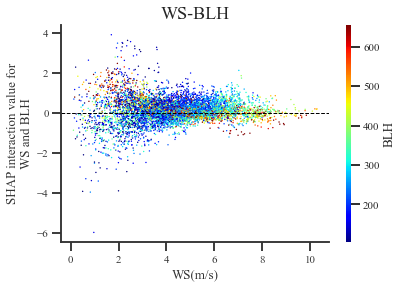

In [85]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
resultDir = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\interactiveplot\polluted\%s'%sitename
if not os.path.exists(resultDir):
    os.mkdir(resultDir)
unit = {'T':'℃','RH':'%','WD':'°','WS':'m/s','BLH':'m','SSR':'$J/{m^2}$','TP':'m','SP':'Pa'}
for factor1 in [
                'RH',
                'T',
                'SSR',
                'WD',
                'BLH',
                'WS',
                ]:
    for factor2 in [
                    'RH',
                    'T',
                    'SSR',
                    'WD',
                    'BLH',
                    'WS',
                    ]:
        factorDir = r'%s\%s'%(resultDir,factor1)
        if not os.path.exists(factorDir):
            os.mkdir(factorDir)
        if factor1==factor2:
            continue
        plt.close()
        sns.set(font='Times New Roman',context='talk',style='ticks')
        fig,ax = plt.subplots(figsize=(6,4))
        shap.dependence_plot(
            (factor1, factor2),
            np.concatenate(shap_interaction_values,axis=0)[x_explain_new['date'].isin(data_new['date']),5:,5:], 
            x_explain_polluted,
            dot_size=2,show=False,ax=ax,alpha=1,
            display_features=x_explain_polluted,
            cmap='jet'
        )
        ax.axhline(0,color='black',linestyle='--',lw=1)
        ax.set_title('%s-%s'%(factor1,factor2))

        if factor1 == 'WD':
            ax.set_xticks(np.arange(0,361,45))
            ax.set_xticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
            ax.set_xlim(0,360)
        if factor1=='TCC':
            ax.set_xlabel('%s'%factor1)
        else:
            ax.set_xlabel('%s(%s)'%(factor1,unit[factor1]))
        plt.savefig(r'%s/dependence_plot_interactive_%s_%s_%s_%s.png'%(factorDir,pol,sitename,factor1,factor2),dpi=300,bbox_inches='tight')

多变量依赖图

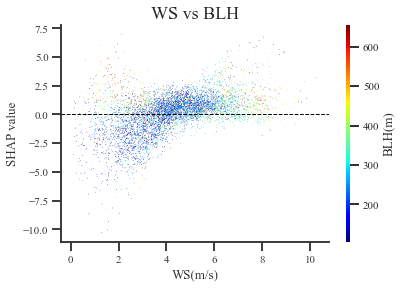

In [86]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
dir = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\pairplot\polluted\%s'%sitename
if not os.path.exists(dir):
    os.mkdir(dir)
unit = {'T':'℃','RH':'%','WD':'°','WS':'m/s','BLH':'m','SSR':'$J/{m^2}$','TP':'m','SP':'Pa'}
for factor1 in [
                'RH',
                'T',
                'SSR',
                'WD',
                'BLH',
                'WS',
                ]:
    for factor2 in [
                    'RH',
                    'T',
                    'SSR',
                    'WD',
                    'BLH',
                    'WS',
                    ]:
        dirFactor = r'%s\%s'%(dir,factor1)
        if not os.path.exists(dirFactor):
            os.makedirs(dirFactor)
        if factor1==factor2:
            continue
        plt.close()
        sns.set(font='Times New Roman',context='talk',style='ticks')
        # for feature in X.columns:
        fig,ax = plt.subplots(figsize=(6,4))
        dp = shap.dependence_plot(factor1, np.concatenate(shap_values,axis=0)[x_explain_new['date'].isin(data_new['date']),5:], 
            x_explain_polluted,cmap='jet',interaction_index=factor2,show=False,ax=ax,dot_size=0.5)
        ax.set_title('%s vs %s'%(factor1,factor2))
        ax.axhline(0,color='black',linestyle='--',lw=1)
        ax.set_ylabel('SHAP value')
        if factor1 == 'WD':
            ax.set_xticks(np.arange(0,361,45))
            ax.set_xticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
            ax.set_xlim(0,360)
        if factor1=='TCC':
            ax.set_xlabel('%s'%facotr1)
        else:
            ax.set_xlabel('%s(%s)'%(factor1,unit[factor1]))
        
        if factor2=='TCC':
            fig.axes[1].set_ylabel('%s'%(factor2))
        else:
            fig.axes[1].set_ylabel('%s(%s)'%(factor2,unit[factor2]))
        plt.savefig(r'%s/dependence_plot_%s_%s_%s_%s.png'%(dirFactor,pol,sitename,factor1,factor2),dpi=300,bbox_inches='tight')
        # plt.show()


单变量依赖图

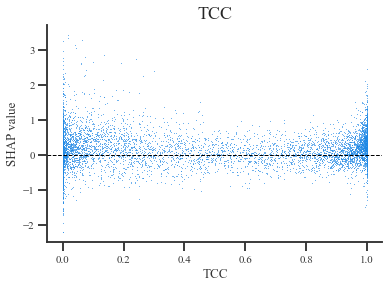

In [87]:
unit = {'T':'℃','RH':'%','WD':'°','WS':'m/s','BLH':'m','SSR':'$J/{m^2}$','TP':'m','SP':'Pa'}
resultDir = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\singleplot\polluted\%s'%sitename
if not os.path.exists(resultDir):
    os.mkdir(resultDir)
for factor1 in ['T','WD','WS','SSR','SP','BLH','TP','RH','TCC']:
    plt.close()
    sns.set(font='Times New Roman',context='talk',style='ticks')
    # for feature in X.columns:
    fig,ax = plt.subplots(figsize=(6,4))
    shap.dependence_plot(factor1, np.concatenate(shap_values,axis=0)[x_explain_new['date'].isin(data_new['date']),5:], 
            x_explain_polluted,cmap='jet',interaction_index=None,show=False,ax=ax,dot_size=0.5)
    ax.set_title('%s'%(factor1))
    ax.axhline(0,color='black',linestyle='--',lw=1)
    ax.set_ylabel('SHAP value')
    if factor1 == 'WD':
        ax.set_xticks(np.arange(0,361,45))
        ax.set_xlim(0,360)
        ax.set_xticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
    if factor1=='TCC':
        ax.set_xlabel('%s'%factor1)
    else:
        ax.set_xlabel('%s(%s)'%(factor1,unit[factor1]))
    plt.savefig(r'%s/dependence_plot_single_%s_%s_%s.png'%(resultDir,pol,sitename,factor1),dpi=300,bbox_inches='tight')

#### 全天交互依赖图

多变量依赖图

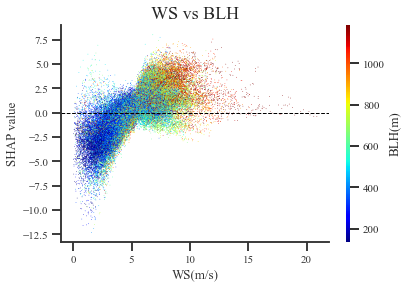

In [88]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
dir = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\pairplot\allDay\%s'%sitename
if not os.path.exists(dir):
    os.mkdir(dir)
unit = {'T':'℃','RH':'%','WD':'°','WS':'m/s','BLH':'m','SSR':'$J/{m^2}$','TP':'m','SP':'Pa'}
for factor1 in [
                'RH',
                'T',
                'SSR',
                'WD',
                'BLH',
                'WS',
                ]:
    for factor2 in [
                    'RH',
                    'T',
                    'SSR',
                    'WD',
                    'BLH',
                    'WS',
                    ]:
        dirFactor = r'%s\%s'%(dir,factor1)
        if not os.path.exists(dirFactor):
            os.makedirs(dirFactor)
        if factor1==factor2:
            continue
        plt.close()
        sns.set(font='Times New Roman',context='talk',style='ticks')
        # for feature in X.columns:
        fig,ax = plt.subplots(figsize=(6,4))
        dp = shap.dependence_plot(factor1, np.concatenate(shap_values,axis=0), x_explain,cmap='jet',interaction_index=factor2,show=False,ax=ax,dot_size=0.5)
        ax.set_title('%s vs %s'%(factor1,factor2))
        ax.axhline(0,color='black',linestyle='--',lw=1)
        ax.set_ylabel('SHAP value')
        if factor1 == 'WD':
            ax.set_xticks(np.arange(0,361,45))
            ax.set_xticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
            ax.set_xlim(0,360)
        if factor1=='TCC':
            ax.set_xlabel('%s'%facotr1)
        else:
            ax.set_xlabel('%s(%s)'%(factor1,unit[factor1]))
        
        if factor2=='TCC':
            fig.axes[1].set_ylabel('%s'%(factor2))
        else:
            fig.axes[1].set_ylabel('%s(%s)'%(factor2,unit[factor2]))
        plt.savefig(r'%s/dependence_plot_%s_%s_%s_%s.png'%(dirFactor,pol,sitename,factor1,factor2),dpi=300,bbox_inches='tight')
        # plt.show()


单变量依赖图

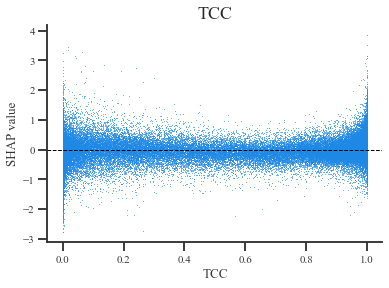

In [89]:
unit = {'T':'℃','RH':'%','WD':'°','WS':'m/s','BLH':'m','SSR':'$J/{m^2}$','TP':'m','SP':'Pa'}
resultDir = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\singleplot\allDay\%s'%sitename
if not os.path.exists(resultDir):
    os.mkdir(resultDir)
for factor1 in ['T','WD','WS','SSR','SP','BLH','TP','RH','TCC']:
    plt.close()
    sns.set(font='Times New Roman',context='talk',style='ticks')
    # for feature in X.columns:
    fig,ax = plt.subplots(figsize=(6,4))
    shap.dependence_plot(factor1, np.concatenate(shap_values,axis=0), x_explain,cmap='jet',interaction_index=None,show=False,ax=ax,dot_size=0.5)
    ax.set_title('%s'%(factor1))
    ax.axhline(0,color='black',linestyle='--',lw=1)
    ax.set_ylabel('SHAP value')
    if factor1 == 'WD':
        ax.set_xticks(np.arange(0,361,45))
        ax.set_xlim(0,360)
        ax.set_xticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
    if factor1=='TCC':
        ax.set_xlabel('%s'%factor1)
    else:
        ax.set_xlabel('%s(%s)'%(factor1,unit[factor1]))
    plt.savefig(r'%s/dependence_plot_single_%s_%s_%s.png'%(resultDir,pol,sitename,factor1),dpi=300,bbox_inches='tight')

交互依赖图

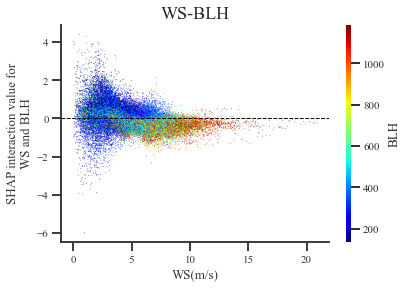

In [90]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
resultDir = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\模型解释\0609\interactiveplot\allDay\%s'%sitename
if not os.path.exists(resultDir):
    os.mkdir(resultDir)
unit = {'T':'℃','RH':'%','WD':'°','WS':'m/s','BLH':'m','SSR':'$J/{m^2}$','TP':'m','SP':'Pa'}
for factor1 in [
                'RH',
                'T',
                'SSR',
                'WD',
                'BLH',
                'WS',
                ]:
    for factor2 in [
                    'RH',
                    'T',
                    'SSR',
                    'WD',
                    'BLH',
                    'WS',
                    ]:
        factorDir = r'%s\%s'%(resultDir,factor1)
        if not os.path.exists(factorDir):
            os.mkdir(factorDir)
        if factor1==factor2:
            continue
        plt.close()
        sns.set(font='Times New Roman',context='talk',style='ticks')
        fig,ax = plt.subplots(figsize=(6,4))
        shap.dependence_plot(
            (factor1, factor2),
            np.concatenate(shap_interaction_values,axis=0), x_explain,dot_size=0.5,show=False,ax=ax,alpha=1,
            display_features=x_explain,cmap='jet'
        )
        ax.axhline(0,color='black',linestyle='--',lw=1)
        ax.set_title('%s-%s'%(factor1,factor2))

        if factor1 == 'WD':
            ax.set_xticks(np.arange(0,361,45))
            ax.set_xticklabels(['N','NE','E','SE','S','SW','W','NW','N'])
            ax.set_xlim(0,360)
        if factor1=='TCC':
            ax.set_xlabel('%s'%factor1)
        else:
            ax.set_xlabel('%s(%s)'%(factor1,unit[factor1]))
        plt.savefig(r'%s/dependence_plot_interactive_%s_%s_%s_%s.png'%(factorDir,pol,sitename,factor1,factor2),dpi=300,bbox_inches='tight')

### 4.3.3 其他绘图

In [44]:
shap.initjs()
plt.close()
sns.set(font='Times New Roman')
shap.force_plot(explainer.expected_value, np.concatenate(shap_values,axis=0), x_explain)
plt.show()

shap.plots.force is slow for many thousands of rows, try subsampling your data.


KeyboardInterrupt: 

In [20]:
shap.force_plot(explainer.expected_value, shap_values, X)

## 4.4 模型性能评估

### 4.4.1 定义一些函数

In [48]:
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
from scipy.stats import kendalltau


def filter_nan(s,o):
    """
    this functions removed the data  from simulated and observed data
    whereever the observed data contains nan
    
    this is used by all other functions, otherwise they will produce nan as 
    output
    """
    if np.sum(~np.isnan(s*o))>=1:
        data = np.array([s.flatten(),o.flatten()])
        data = np.transpose(data)
        data = data[~np.isnan(data).any(1)]
        s = data[:,0]
        o = data[:,1]
    return s, o

def rmse(s,o):
    """
    Root Mean Squared Error
    input:
        s: simulated
        o: observed
    output:
        rmses: root mean squared error
    """
    s,o = filter_nan(s,o)
    return np.sqrt(np.mean((s-o)**2))

def mae(s,o):
    """
    Mean Absolute Error
    input:
        s: simulated
        o: observed
    output:
        maes: mean absolute error
    """
    s,o = filter_nan(s,o)
    return np.mean(abs(s-o))

def bias(s,o):
    """
    Bias
    input:
        s: simulated
        o: observed
    output:
        bias: bias
    """
    s,o = filter_nan(s,o)
    return np.mean(s-o)

def correlation(s,o):
    """
    correlation coefficient
    input:
        s: simulated
        o: observed
    output:
        correlation: correlation coefficient
    """
    s,o = filter_nan(s,o)
    if s.size == 0:
        corr = np.NaN
    else:
        corr = np.corrcoef(o, s)[0,1]
    return corr

def index_agreement(s, o):
    """
	index of agreement
	
	Willmott (1981, 1982) 
	input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    s,o = filter_nan(s,o)
    ia = 1 -(np.sum((o-s)**2))/(np.sum(
    			(np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

def mean_gross_error(s,o):
    s,o = filter_nan(s,o)
    mge = np.sum(np.abs(s-o))/len(o)
    return mge

def mean_normalized_gross_error(s,o):
    s,o = filter_nan(s,o)
    mge = np.sum(np.abs(s-o)/o)/len(o)
    return mge

def normalized_mean_bias(s,o):
    s,o = filter_nan(s,o)
    nmb = np.sum(s-o)/np.sum(o)
    return nmb

def fractional_bias(s,o):
    s,o = filter_nan(s,o)
    fb = np.sum((s-o)/(0.5*(s+o)))/len(o)
    return fb

def fractional_error(s,o):
    s,o = filter_nan(s,o)
    fe = np.sum(np.abs((s-o))/(0.5*(s+o)))/len(o)
    return fe

def cal_fac2(s,o):
    s,o = filter_nan(s,o)
    new = s/o
    new = new[new<2]
    new = new[new>0.5]
    # new
    return len(new)/len(o)
    

### 4.4.2 计算模型性能

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,median_absolute_error,\
                    mean_absolute_error,explained_variance_score
# paths = glob.glob()
metrics = {}
for sitename in ['PT','DSL','PDHN']:
    metric = {}
    data_train = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\训练数据\trainDataset_cleaned_1000_%s_O31.csv'%sitename)
    true = data_train.value.values
    pred = data_train.predicts.values
    rmse = mean_squared_error(true,pred)**0.5
    # rmse2 = rmse(true,pred)
    r2 = r2_score(true,pred)
    mae = mean_absolute_error(true,pred)
    ioa = index_agreement(true,pred)
    mb = bias(true,pred)
    mge = mean_gross_error(true,pred)
    mnge = mean_normalized_gross_error(true,pred)
    nmb = normalized_mean_bias(true,pred)
    fb = fractional_bias(true,pred)
    fe = fractional_error(true,pred)
    fac2 = cal_fac2(true,pred)
    metric['RMSE'] = rmse
    metric['R2'] = r2
    metric['MAE'] = mae
    metric['IOA'] = ioa
    metric['MB'] = mb
    metric['MGE'] = mge
    metric['MNGE'] = mnge
    metric['NMB'] = nmb
    # metric['FB'] = fb
    # metric['FE'] = fe
    metric['FAC2'] = fac2
    # print(metric)
    metrics[sitename] = metric
metrics = pd.DataFrame(metrics)
metrics = metrics.T
metrics.to_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\metrics_rmwNormal_O31.xlsx')

### 4.4.3 模型性能散点图

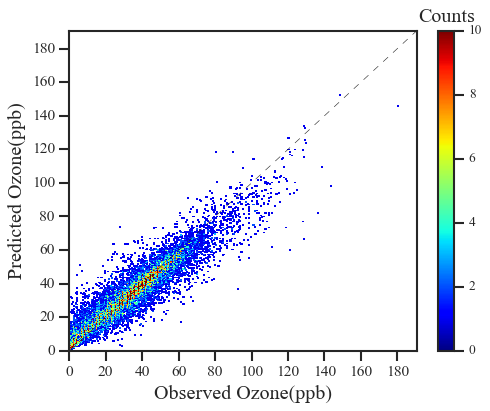

In [50]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# data = pd.read_csv(r'/data/home/xuejin/code/SH_OzoneTrend/results/1.13rmwNormal/trainDataset_cleaned_1000_PT_O31.csv')
data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\训练数据\trainDataset_cleaned_1000_%s_O31.csv'%sitename)

# data2 = pd.read_csv(r'/data/home/xuejin/code/SH_OzoneTrend/results/trainDataset_cleaned_1000_MHPJ_BKGO3.csv')

nbins = 300
H, xedges, yedges = np.histogram2d(data['value'], data['predicts'], bins=nbins)
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
#开始绘图
sns.set(font='times new roman',style='ticks',context='talk')
fig,ax = plt.subplots(figsize=(7,5))
max = np.max(data[['value','predicts']].values) + 10
plt.xticks(np.arange(0,max,20))
plt.yticks(np.arange(0,max,20))

plt.xlim(0,max)
plt.ylim(0,max)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=0.5, scalex=False, scaley=False)
plt.pcolormesh(xedges, yedges, Hmasked, cmap=cm.get_cmap('jet'), vmin=0, vmax=10)
plt.tick_params(labelsize=14,direction='out')
plt.xlabel('Observed Ozone(ppb)')
plt.ylabel('Predicted Ozone(ppb)')
cbar = plt.colorbar(ax=ax,ticks=[0,2,4,6,8,10],drawedges=False)
cbar.ax.set_title('Counts',pad=8)
cbar.ax.tick_params(labelsize=12,direction='out')
plt.show()
# plt.savefig(r'/data/home/xuejin/code/SH_OzoneTrend/figure/polData/PT.png',dpi=400,bbox_inches='tight')

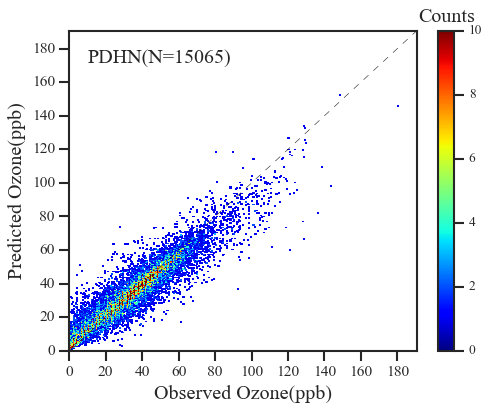

In [51]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

sitename = 'PDHN'
# data = pd.read_csv(r'/data/home/xuejin/code/SH_OzoneTrend/results/1.13rmwNormal/trainDataset_cleaned_1000_PT_O31.csv')
data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\训练数据\trainDataset_cleaned_1000_%s_O31.csv'%sitename)

# data2 = pd.read_csv(r'/data/home/xuejin/code/SH_OzoneTrend/results/trainDataset_cleaned_1000_MHPJ_BKGO3.csv')

nbins = 300
H, xedges, yedges = np.histogram2d(data['value'], data['predicts'], bins=nbins)
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
#开始绘图
sns.set(font='times new roman',style='ticks',context='talk')
fig,ax = plt.subplots(figsize=(7,5))
max = np.max(data[['value','predicts']].values) + 10
plt.xticks(np.arange(0,max,20))
plt.yticks(np.arange(0,max,20))

plt.xlim(0,max)
plt.ylim(0,max)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=0.5, scalex=False, scaley=False)
plt.pcolormesh(xedges, yedges, Hmasked, cmap=cm.get_cmap('jet'), vmin=0, vmax=10)
plt.tick_params(labelsize=14,direction='out')
plt.xlabel('Observed Ozone(ppb)')
plt.ylabel('Predicted Ozone(ppb)')
plt.text(10,max*0.9,'%s(N=%s)'%(sitename,len(data['value'])),fontsize=18)
cbar = plt.colorbar(ax=ax,ticks=[0,2,4,6,8,10],drawedges=False)
cbar.ax.set_title('Counts',pad=8)
cbar.ax.tick_params(labelsize=12,direction='out')
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\模型性能评估%s.png'%sitename,dpi=400,bbox_inches='tight')

# 4 气象标准化及背景浓度结果可视化

## 4.1 气象标准化结果可视化

### 4.1.1 按月

***!!!两条趋势线+气象标准化+观测浓度***

In [ ]:
sitename = 'DSL'
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,parse_dates=['datetime'])

data = data_rmw.copy()
data['difference'] = data['predicts'] - data['observation']
data = data.set_index('datetime')
data = data.resample('D').mean()
# data = data.reset_index()
# data = data.resample('M').mean()
data2013 = data.loc[:'2018']
data2018 = data.loc['2018':]
data = data.reset_index()

mk_result2013 = mk.seasonal_sens_slope(data2013.predicts.values,period=12)
data2013 = data2013.resample('Y',loffset='-180d').mean()

data2013['year'] = data2013.index.year
data2013['MK trends'] = data2013['year'].apply(lambda x:(x-2013)*mk_result2013.slope+mk_result2013.intercept)
data2013 = data2013.reset_index()

mk_result2018 = mk.seasonal_sens_slope(data2018.predicts.values,period=12)
data2018 = data2018.resample('Y',loffset='-180d').mean()

data2018['year'] = data2018.index.year
data2018['MK trends'] = data2018['year'].apply(lambda x:(x-2018)*mk_result2018.slope+mk_result2018.intercept)
data2018 = data2018.reset_index()

sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))

ax.plot(data['datetime'],data['observation'],lw=0.3,c='#12B361',label='observed ozone')
ax.plot(data['datetime'],data['predicts'],lw=2,c='#1255B3',label='weather-removed ozone')
ax.plot(data2013['datetime'],data2013['MK trends'],c='#FF6500',ls='--',label='MK trends')
ax.plot(data2018['datetime'],data2018['MK trends'],c='#FF6500',ls='--')



ax.set_xlabel('year')
ax.set_ylim(0,101)
ax.set_yticks(np.arange(0,101,10))
ax.set_ylabel('$O_3$(ppbv)')
ax.set_title('%s-$O_3$'%sitename)
# ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=3,frameon=False,fontsize=14)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\观测移除气象\PCA按天结果_趋势_%s_month.png'%sitename,dpi=400,bbox_inches='tight')

***柱状图+MK趋势+观测浓度+气象标准化 (O3)-PT
* 对于MK趋势参数的解释 https://www.jianshu.com/p/eae362946ea9

In [ ]:
sitename = 'PT'
# data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s_剔除201902数据.csv'%sitename,parse_dates=['datetime'])

data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,parse_dates=['datetime'])
data['weather contribution'] = data['observation'] - data['predicts']
data1 = data.melt(id_vars=['datetime'],value_vars=['observation','weather contribution','predicts'],var_name='type',value_name='concentration')
data1['type'] = data1['type'].apply(lambda x:'observed ozone' if x=='observation' \
                else('weather-removed ozone' if x=='predicts' else 'weather contribution'))

colors = ['#0099e5','#ff4c4c','#34bf49']

# 计算日均值
data2 = (data1.set_index('datetime')
            .groupby([pd.Grouper(freq='D'),'type']).mean()
            # .reset_index(drop=True).set_index('datetime')
            # .groupby(['datetime','type']).max()
            .reset_index()
        )
data2 = data2.set_index('datetime').sort_index().reset_index()

data3 = data2.set_index(['datetime','type']).unstack()['concentration']
data2013 = data3.loc[:'2019']
data2019 = data3.loc['2019':]
# data = data.reset_index()

'''要改下周期'''
mk_result2013 = mk.seasonal_test(data2013['weather-removed ozone'].values,period=365)
data2013 = data2013.resample('Y',loffset='-180d').mean()

data2013['year'] = data2013.index.year
data2013['MK trends'] = data2013['year'].apply(lambda x:(x-2013)*mk_result2013.slope+mk_result2013.intercept)
data2013 = data2013.reset_index()

mk_result2019 = mk.seasonal_test(data2019['weather-removed ozone'].values,period=365)
data2019 = data2019.resample('Y',loffset='-180d').mean()

data2019['year'] = data2019.index.year
data2019['MK trends'] = data2019['year'].apply(lambda x:(x-2019)*mk_result2019.slope+mk_result2019.intercept)
data2019 = data2019.reset_index()

print('%.5f'%mk_result2019.p)

sns.set(context='talk',style='ticks',font='Times New Roman')

fig = plt.figure(figsize=(18,12))
grid = plt.GridSpec(3,3,wspace=0.2,hspace=0.24)
ax1 = fig.add_subplot(grid[:2,:])
ax2 = fig.add_subplot(grid[2,0])
ax3 = fig.add_subplot(grid[2,1])
ax4 = fig.add_subplot(grid[2,2])

# ax1_1 = ax1.twinx()

data_obs = data2.loc[data2['type']=='observed ozone']
data_sim = data2.loc[data2['type']=='weather-removed ozone']
data_dif = data2.loc[data2['type']=='weather contribution']
data_dif_day = data_dif.set_index('datetime').groupby(pd.Grouper(freq='M')).mean().reset_index()

ax1.plot(data_dif_day['datetime'],data_dif_day['concentration'],
        c=colors[2],marker='o',mec='black',mfc=colors[2],lw=2,label='weather contribution')
# ax1.plot(data_obs['datetime'],data_obs['concentration'],marker='o',markersize=5,lw=0.5,c='#4c72b0',label='observed ozone')
ax1.scatter(data_obs['datetime'],data_obs['concentration'],s=5,c=colors[0],label='observed ozone')
ax1.plot(data_sim['datetime'],data_sim['concentration'],lw=2,c=colors[1],label='weather-removed ozone')

ax1.plot(data2013['datetime'],data2013['MK trends'],c='red',ls=':',
                    label='$O_3$(2013-2019) = %.2fx(years after 2013) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result2013.slope,mk_result2013.intercept,mk_result2013.z)
                        )
ax1.plot(data2019['datetime'],data2019['MK trends'],c='red',ls='--',
                    label='$O_3$(2019-2021) = %.2fx(years after 2019) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result2019.slope,mk_result2019.intercept,mk_result2019.z)
                        )

ax1.axhline(0,color='black',ls='--',lw=1.5)

ax1.set_ylim(-15,np.max(data2['concentration'])*1.1)
ax1.legend(ncol=3,frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.15))
ax1.set_ylabel('$O_3$(ppbv)')
ax1.set_xlabel(None)
ax1.set_xlim(data2['datetime'].min(),data2['datetime'].max())
ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))

bar1 = sns.barplot(x=data_obs['datetime'].dt.year,y=data_obs['concentration'],color = colors[0],ax=ax2,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax2 = bar_labels(bar1,offset=0.4,fontsize=11,where='center',color='black')
ax2.set_ylim(0,45)
ax2.set_ylabel('observed $O_3$(ppbv)')
ax2.set_xlabel('year')
ax2.tick_params(axis='x',rotation=90)


bar2 = sns.barplot(x=data_sim['datetime'].dt.year,y=data_sim['concentration'],color = colors[1],ax=ax3,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax3 = bar_labels(bar2,offset=0.4,fontsize=11,where='center',color='black')
ax3.set_ylim(0,45)
ax3.set_ylabel('weather-removed $O_3$(ppbv)')
ax3.set_xlabel('year')
ax3.tick_params(axis='x',rotation=90)

bar3 = sns.barplot(x=data_dif['datetime'].dt.year,y=data_dif['concentration'],color = colors[2],ax=ax4,
                    capsize=0.4,errwidth=1.5,zorder=1,errcolor='black')
ax4 = bar_labels(bar3,offset=0.4,fontsize=11,where='top',color='black')
ax4.axhline(0,color='black',lw=1.5)
ax4.set_ylim(-7,7)
ax4.set_ylabel('weather contribution(ppbv)')
ax4.set_xlabel('year')
ax4.tick_params(axis='x',rotation=90)

# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\柱状图+MK趋势+观测浓度+气象标准化_O31_%s'%sitename,bbox_inches='tight')

***柱状图+MK趋势+观测浓度+气象标准化 (O3)-DSL

In [ ]:
sitename = 'DSL'
# data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s_剔除201902数据.csv'%sitename,parse_dates=['datetime'])

data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,parse_dates=['datetime'])
data['weather contribution'] = data['observation'] - data['predicts']
data1 = data.melt(id_vars=['datetime'],value_vars=['observation','weather contribution','predicts'],var_name='type',value_name='concentration')
data1['type'] = data1['type'].apply(lambda x:'observed ozone' if x=='observation' \
                else('weather-removed ozone' if x=='predicts' else 'weather contribution'))

colors = ['#0099e5','#ff4c4c','#34bf49']

# 计算日均值
data2 = (data1.set_index('datetime')
            .groupby([pd.Grouper(freq='D'),'type']).mean()
            # .reset_index(drop=True).set_index('datetime')
            # .groupby(['datetime','type']).max()
            .reset_index()
        )
data2 = data2.set_index('datetime').sort_index().reset_index()

data3 = data2.set_index(['datetime','type']).unstack()['concentration']
data2013 = data3.loc[:'2018']
data2018 = data3.loc['2018':]
# data = data.reset_index()

'''要改下周期'''
mk_result2013 = mk.seasonal_test(data2013['weather-removed ozone'].values,period=365)
data2013 = data2013.resample('Y',loffset='-180d').mean()

data2013['year'] = data2013.index.year
data2013['MK trends'] = data2013['year'].apply(lambda x:(x-2013)*mk_result2013.slope+mk_result2013.intercept)
data2013 = data2013.reset_index()

mk_result2018 = mk.seasonal_test(data2018['weather-removed ozone'].values,period=365)
data2018 = data2018.resample('Y',loffset='-180d').mean()

data2018['year'] = data2018.index.year
data2018['MK trends'] = data2018['year'].apply(lambda x:(x-2018)*mk_result2018.slope+mk_result2018.intercept)
data2018 = data2018.reset_index()
print('%.5f'%mk_result2018.p)


sns.set(context='talk',style='ticks',font='Times New Roman')

fig = plt.figure(figsize=(18,12))
grid = plt.GridSpec(3,3,wspace=0.2,hspace=0.24)
ax1 = fig.add_subplot(grid[:2,:])
ax2 = fig.add_subplot(grid[2,0])
ax3 = fig.add_subplot(grid[2,1])
ax4 = fig.add_subplot(grid[2,2])

# ax1_1 = ax1.twinx()

data_obs = data2.loc[data2['type']=='observed ozone']
data_sim = data2.loc[data2['type']=='weather-removed ozone']
data_dif = data2.loc[data2['type']=='weather contribution']
data_dif_day = data_dif.set_index('datetime').groupby(pd.Grouper(freq='M')).mean().reset_index()

ax1.plot(data_dif_day['datetime'],data_dif_day['concentration'],
        c=colors[2],marker='o',mec='black',mfc=colors[2],lw=2,label='weather contribution')
# ax1.plot(data_obs['datetime'],data_obs['concentration'],marker='o',markersize=5,lw=0.5,c='#4c72b0',label='observed ozone')
ax1.scatter(data_obs['datetime'],data_obs['concentration'],s=5,c=colors[0],label='observed ozone')
ax1.plot(data_sim['datetime'],data_sim['concentration'],lw=2,c=colors[1],label='weather-removed ozone')

ax1.plot(data2013['datetime'],data2013['MK trends'],c='red',ls=':',
                    label='$O_3$(2013-2018) = %.2fx(years after 2013) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result2013.slope,mk_result2013.intercept,mk_result2013.z)
                        )
ax1.plot(data2018['datetime'],data2018['MK trends'],c='red',ls='--',
                    label='$O_3$(2018-2021) = %.2fx(years after 2018) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result2018.slope,mk_result2018.intercept,mk_result2018.z)
                        )

ax1.axhline(0,color='black',ls='--',lw=1.5)

ax1.set_ylim(-15,np.max(data2['concentration'])*1.1)
ax1.legend(ncol=3,frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.15))
ax1.set_ylabel('$O_3$(ppbv)')
ax1.set_xlabel(None)
ax1.set_xlim(data2['datetime'].min(),data2['datetime'].max())
ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))

bar1 = sns.barplot(x=data_obs['datetime'].dt.year,y=data_obs['concentration'],color = colors[0],ax=ax2,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax2 = bar_labels(bar1,offset=0.4,fontsize=11,where='center',color='black')
ax2.set_ylim(0,45)
ax2.set_ylabel('observed $O_3$(ppbv)')
ax2.set_xlabel('year')
ax2.tick_params(axis='x',rotation=90)


bar2 = sns.barplot(x=data_sim['datetime'].dt.year,y=data_sim['concentration'],color = colors[1],ax=ax3,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax3 = bar_labels(bar2,offset=0.4,fontsize=11,where='center',color='black')
ax3.set_ylim(0,45)
ax3.set_ylabel('weather-removed $O_3$(ppbv)')
ax3.set_xlabel('year')
ax3.tick_params(axis='x',rotation=90)

bar3 = sns.barplot(x=data_dif['datetime'].dt.year,y=data_dif['concentration'],color = colors[2],ax=ax4,
                    capsize=0.4,errwidth=1.5,zorder=1,errcolor='black')
ax4 = bar_labels(bar3,offset=0.4,fontsize=11,where='top',color='black')
ax4.axhline(0,color='black',lw=1.5)
ax4.set_ylim(-7,7)
ax4.set_ylabel('weather contribution(ppbv)')
ax4.set_xlabel('year')
ax4.tick_params(axis='x',rotation=90)

# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\柱状图+MK趋势+观测浓度+气象标准化_O31_%s'%sitename,bbox_inches='tight')

***柱状图+MK趋势+观测浓度+气象标准化 (O3)-PDHN

In [ ]:
sitename = 'PDHN'
# data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s_剔除201902数据.csv'%sitename,parse_dates=['datetime'])

data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,parse_dates=['datetime'])
data['weather contribution'] = data['observation'] - data['predicts']
data1 = data.melt(id_vars=['datetime'],value_vars=['observation','weather contribution','predicts'],var_name='type',value_name='concentration')
data1['type'] = data1['type'].apply(lambda x:'observed ozone' if x=='observation' \
                else('weather-removed ozone' if x=='predicts' else 'weather contribution'))

colors = ['#0099e5','#ff4c4c','#34bf49']

# 计算日均值
data2 = (data1.set_index('datetime')
            .groupby([pd.Grouper(freq='D'),'type']).mean()
            # .reset_index(drop=True).set_index('datetime')
            # .groupby(['datetime','type']).max()
            .reset_index()
        )
data2 = data2.set_index('datetime').sort_index().reset_index()

data3 = data2.set_index(['datetime','type']).unstack()['concentration']
data2013 = data3.copy()
# data2018 = data3.loc['2018':]
# data = data.reset_index()

'''要改下周期'''
mk_result2013 = mk.seasonal_test(data2013['weather-removed ozone'].values,period=365)
data2013 = data2013.resample('Y',loffset='-180d').mean()

data2013['year'] = data2013.index.year
data2013['MK trends'] = data2013['year'].apply(lambda x:(x-2013)*mk_result2013.slope+mk_result2013.intercept)
data2013 = data2013.reset_index()

# mk_result2018 = mk.seasonal_test(data2018['weather-removed ozone'].values,period=365)
# data2018 = data2018.resample('Y',loffset='-180d').mean()

# data2018['year'] = data2018.index.year
# data2018['MK trends'] = data2018['year'].apply(lambda x:(x-2018)*mk_result2018.slope+mk_result2018.intercept)
# data2018 = data2018.reset_index()
print('%.5f'%mk_result2013.p)


sns.set(context='talk',style='ticks',font='Times New Roman')

fig = plt.figure(figsize=(18,12))
grid = plt.GridSpec(3,3,wspace=0.2,hspace=0.24)
ax1 = fig.add_subplot(grid[:2,:])
ax2 = fig.add_subplot(grid[2,0])
ax3 = fig.add_subplot(grid[2,1])
ax4 = fig.add_subplot(grid[2,2])

# ax1_1 = ax1.twinx()

data_obs = data2.loc[data2['type']=='observed ozone']
data_sim = data2.loc[data2['type']=='weather-removed ozone']
data_dif = data2.loc[data2['type']=='weather contribution']
data_dif_day = data_dif.set_index('datetime').groupby(pd.Grouper(freq='M')).mean().reset_index()

ax1.plot(data_dif_day['datetime'],data_dif_day['concentration'],
        c=colors[2],marker='o',mec='black',mfc=colors[2],lw=2,label='weather contribution')
# ax1.plot(data_obs['datetime'],data_obs['concentration'],marker='o',markersize=5,lw=0.5,c='#4c72b0',label='observed ozone')
ax1.scatter(data_obs['datetime'],data_obs['concentration'],s=5,c=colors[0],label='observed ozone')
ax1.plot(data_sim['datetime'],data_sim['concentration'],lw=2,c=colors[1],label='weather-removed ozone')

ax1.plot(data2013['datetime'],data2013['MK trends'],c='red',ls=':',
                    label='$O_3$ = %.2fx(years after 2013) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result2013.slope,mk_result2013.intercept,mk_result2013.z)
                        )
# ax1.plot(data2018['datetime'],data2018['MK trends'],c='red',ls='--',
#                     label='$O_3$(2018-2021) = %.2fx(years after 2018) + %.2f  p<0.05  z:%.2f'\
#                         %(mk_result2018.slope,mk_result2018.intercept,mk_result2018.z)
#                         )

ax1.axhline(0,color='black',ls='--',lw=1.5)

ax1.set_ylim(-15,np.max(data2['concentration'])*1.1)
ax1.legend(ncol=2,frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.15))
ax1.set_ylabel('$O_3$(ppbv)')
ax1.set_xlabel(None)
ax1.set_xlim(data2['datetime'].min(),data2['datetime'].max())
ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))

bar1 = sns.barplot(x=data_obs['datetime'].dt.year,y=data_obs['concentration'],color = colors[0],ax=ax2,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax2 = bar_labels(bar1,offset=0.4,fontsize=11,where='center',color='black')
ax2.set_ylim(0,45)
ax2.set_ylabel('observed $O_3$(ppbv)')
ax2.set_xlabel('year')
ax2.tick_params(axis='x',rotation=90)


bar2 = sns.barplot(x=data_sim['datetime'].dt.year,y=data_sim['concentration'],color = colors[1],ax=ax3,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax3 = bar_labels(bar2,offset=0.4,fontsize=11,where='center',color='black')
ax3.set_ylim(0,45)
ax3.set_ylabel('weather-removed $O_3$(ppbv)')
ax3.set_xlabel('year')
ax3.tick_params(axis='x',rotation=90)

bar3 = sns.barplot(x=data_dif['datetime'].dt.year,y=data_dif['concentration'],color = colors[2],ax=ax4,
                    capsize=0.4,errwidth=1.5,zorder=1,errcolor='black')
ax4 = bar_labels(bar3,offset=0.4,fontsize=11,where='top',color='black')
ax4.axhline(0,color='black',lw=1.5)
ax4.set_ylim(-7,7)
ax4.set_ylabel('weather contribution(ppbv)')
ax4.set_xlabel('year')
ax4.tick_params(axis='x',rotation=90)

# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\柱状图+MK趋势+观测浓度+气象标准化_O31_%s'%sitename,bbox_inches='tight')

***柱状图+MK趋势+观测浓度+气象标准化 (MDA8)-PT

In [ ]:
sitename = 'PT'
data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,parse_dates=['datetime'])

# data['weather contribution'] = data['observation'] - data['predicts']
data1 = data.melt(id_vars=['datetime'],value_vars=['observation','predicts'],var_name='type',value_name='concentration')
data1['type'] = data1['type'].apply(lambda x:'observed ozone' if x=='observation' \
                else('weather-removed ozone' if x=='predicts' else 'weather contribution'))
colors = ['#0099e5','#ff4c4c','#34bf49']
# 计算MDA8
data2 = (data1.set_index('datetime')
            .groupby([pd.Grouper(freq='D'),'type'],as_index=False).rolling(window=8,min_periods=8).mean()
            .reset_index(drop=True).set_index('datetime')
            .groupby(['datetime','type']).max()
            .reset_index()
        )
# data2.to_excel(r'D:/desktop/test.xlsx')

data2 = data2.pivot_table(index='datetime',columns='type',values='concentration').reset_index()
data2['weather contribution'] = data2['weather-removed ozone'] - data2['observed ozone']
data2 = data2.melt(id_vars=['datetime'],value_vars=['observed ozone','weather-removed ozone','weather contribution'],var_name='type',value_name='concentration')

data2 = data2.set_index('datetime').sort_index().reset_index()

data3 = data2.set_index(['datetime','type']).unstack()['concentration']
data2013 = data3.loc[:'2019']
data2019 = data3.loc['2019':]

mk_result2013 = mk.seasonal_test(data2013['weather-removed ozone'].values,period=365)
data2013 = data2013.resample('Y',loffset='-180d').mean()


data2013['year'] = data2013.index.year
data2013['MK trends'] = data2013['year'].apply(lambda x:(x-2013)*mk_result2013.slope+mk_result2013.intercept)
data2013 = data2013.reset_index()

mk_result2019 = mk.seasonal_test(data2019['weather-removed ozone'].values,period=365)
data2019 = data2019.resample('Y',loffset='-180d').mean()

data2019['year'] = data2019.index.year
data2019['MK trends'] = data2019['year'].apply(lambda x:(x-2019)*mk_result2019.slope+mk_result2019.intercept)
data2019 = data2019.reset_index()


sns.set(context='talk',style='ticks',font='Times New Roman')

fig = plt.figure(figsize=(18,12))
grid = plt.GridSpec(3,3,wspace=0.22,hspace=0.24)
ax1 = fig.add_subplot(grid[:2,:])
ax2 = fig.add_subplot(grid[2,0])
ax3 = fig.add_subplot(grid[2,1])
ax4 = fig.add_subplot(grid[2,2])

data_obs = data2.loc[data2['type']=='observed ozone']
data_sim = data2.loc[data2['type']=='weather-removed ozone']
data_dif = data2.loc[data2['type']=='weather contribution']
data_dif_day = (data_dif.set_index('datetime')
                .groupby(pd.Grouper(freq='M')).mean()
                .reset_index())

ax1.plot(data_dif_day['datetime'],data_dif_day['concentration'],
        c=colors[2],marker='o',mec='black',mfc=colors[2],lw=2,label='weather contribution')
# ax1.plot(data_obs['datetime'],data_obs['concentration'],marker='o',markersize=5,lw=0.5,c='#4c72b0',label='observed ozone')
ax1.scatter(data_obs['datetime'],data_obs['concentration'],s=5,c=colors[0],label='observed ozone')
ax1.plot(data_sim['datetime'],data_sim['concentration'],lw=2,c=colors[1],label='weather-removed ozone')

ax1.plot(data2013['datetime'],data2013['MK trends'],c='red',ls=':',
                    label='$O_3$ MDA8(2013-2019) = %.2fx(years after 2013) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result2013.slope,mk_result2013.intercept,mk_result2013.z)
                        )
ax1.plot(data2019['datetime'],data2019['MK trends'],c='red',ls='--',
                    label='$O_3$ MDA8(2019-2021) = %.2fx(years after 2019) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result2019.slope,mk_result2019.intercept,mk_result2019.z)
                        )

ax1.axhline(0,color='black',ls='--',lw=1.5)
ax1.set_ylim(-30,np.max(data2['concentration'])*1.1)
ax1.legend(ncol=3,frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.14))
ax1.set_ylabel('$O_3$-MDA8(ppbv)')
# ax1.set_xlabel('datetime')
ax1.set_xlim(data2['datetime'].min(),data2['datetime'].max())
ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=6))

bar1 = sns.barplot(x=data_obs['datetime'].dt.year,y=data_obs['concentration'],color = colors[0],ax=ax2,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax2 = bar_labels(bar1,offset=0.4,fontsize=11,where='center',color='black')
ax2.set_ylim(0,66)
ax2.set_ylabel('observed $O_3$-MDA8(ppbv)')
ax2.set_xlabel('year')
ax2.tick_params(axis='x',rotation=90)

bar2 = sns.barplot(x=data_sim['datetime'].dt.year,y=data_sim['concentration'],color = colors[1],ax=ax3,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax3 = bar_labels(bar2,offset=0.4,fontsize=11,where='center',color='black')
ax3.set_ylim(0,66)
ax3.set_ylabel('weather-removed $O_3$-MDA8(ppbv)')
ax3.set_xlabel('year')
ax3.tick_params(axis='x',rotation=90)


bar3 = sns.barplot(x=data_dif['datetime'].dt.year,y=data_dif['concentration'],color = colors[2],ax=ax4,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax4 = bar_labels(bar3,offset=0.4,fontsize=11,where='top',color='black')
ax4.axhline(0,color='black',lw=1.5)

ax4.set_ylim(-10,6)
ax4.set_ylabel('weather contribution(ppbv)')
ax4.set_xlabel('year')
ax4.tick_params(axis='x',rotation=90)

# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\柱状图+MK趋势+观测浓度+气象标准化_%s_MDA8'%sitename,dpi=400,bbox_inches='tight')

***柱状图+MK趋势+观测浓度+气象标准化 (MDA8)-DSL

In [ ]:
sitename = 'DSL'
data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,parse_dates=['datetime'])

# data['weather contribution'] = data['observation'] - data['predicts']
data1 = data.melt(id_vars=['datetime'],value_vars=['observation','predicts'],var_name='type',value_name='concentration')
data1['type'] = data1['type'].apply(lambda x:'observed ozone' if x=='observation' \
                else('weather-removed ozone' if x=='predicts' else 'weather contribution'))
colors = ['#0099e5','#ff4c4c','#34bf49']
# 计算MDA8
data2 = (data1.set_index('datetime')
            .groupby([pd.Grouper(freq='D'),'type'],as_index=False).rolling(window=8,min_periods=8).mean()
            .reset_index(drop=True).set_index('datetime')
            .groupby(['datetime','type']).max()
            .reset_index()
        )
# data2.to_excel(r'D:/desktop/test.xlsx')

data2 = data2.pivot_table(index='datetime',columns='type',values='concentration').reset_index()
data2['weather contribution'] = data2['weather-removed ozone'] - data2['observed ozone']
data2 = data2.melt(id_vars=['datetime'],value_vars=['observed ozone','weather-removed ozone','weather contribution'],var_name='type',value_name='concentration')

data2 = data2.set_index('datetime').sort_index().reset_index()

data3 = data2.set_index(['datetime','type']).unstack()['concentration']
data2013 = data3.loc[:'2018']
data2018 = data3.loc['2018':]

mk_result2013 = mk.seasonal_test(data2013['weather-removed ozone'].values,period=365)
data2013 = data2013.resample('Y',loffset='-180d').mean()


data2013['year'] = data2013.index.year
data2013['MK trends'] = data2013['year'].apply(lambda x:(x-2013)*mk_result2013.slope+mk_result2013.intercept)
data2013 = data2013.reset_index()

mk_result2018 = mk.seasonal_test(data2018['weather-removed ozone'].values,period=365)
data2018 = data2018.resample('Y',loffset='-180d').mean()

data2018['year'] = data2018.index.year
data2018['MK trends'] = data2018['year'].apply(lambda x:(x-2018)*mk_result2018.slope+mk_result2018.intercept)
data2018 = data2018.reset_index()
print(mk_result2018.p)

sns.set(context='talk',style='ticks',font='Times New Roman')

fig = plt.figure(figsize=(18,12))
grid = plt.GridSpec(3,3,wspace=0.22,hspace=0.24)
ax1 = fig.add_subplot(grid[:2,:])
ax2 = fig.add_subplot(grid[2,0])
ax3 = fig.add_subplot(grid[2,1])
ax4 = fig.add_subplot(grid[2,2])

data_obs = data2.loc[data2['type']=='observed ozone']
data_sim = data2.loc[data2['type']=='weather-removed ozone']
data_dif = data2.loc[data2['type']=='weather contribution']
data_dif_day = (data_dif.set_index('datetime')
                .groupby(pd.Grouper(freq='M')).mean()
                .reset_index())

ax1.plot(data_dif_day['datetime'],data_dif_day['concentration'],
        c=colors[2],marker='o',mec='black',mfc=colors[2],lw=2,label='weather contribution')
# ax1.plot(data_obs['datetime'],data_obs['concentration'],marker='o',markersize=5,lw=0.5,c='#4c72b0',label='observed ozone')
ax1.scatter(data_obs['datetime'],data_obs['concentration'],s=5,c=colors[0],label='observed ozone')
ax1.plot(data_sim['datetime'],data_sim['concentration'],lw=2,c=colors[1],label='weather-removed ozone')

ax1.plot(data2013['datetime'],data2013['MK trends'],c='red',ls=':',
                    label='$O_3$ MDA8(2013-2018) = %.2fx(years after 2013) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result2013.slope,mk_result2013.intercept,mk_result2013.z)
                        )
ax1.plot(data2018['datetime'],data2018['MK trends'],c='red',ls='--',
                    label='$O_3$ MDA8(2018-2021) = %.2fx(years after 2018) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result2018.slope,mk_result2018.intercept,mk_result2018.z)
                        )

ax1.axhline(0,color='black',ls='--',lw=1.5)
ax1.set_ylim(-30,np.max(data2['concentration'])*1.1)
ax1.legend(ncol=3,frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.14))
ax1.set_ylabel('$O_3$-MDA8(ppbv)')
# ax1.set_xlabel('datetime')
ax1.set_xlim(data2['datetime'].min(),data2['datetime'].max())
ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=6))

bar1 = sns.barplot(x=data_obs['datetime'].dt.year,y=data_obs['concentration'],color = colors[0],ax=ax2,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax2 = bar_labels(bar1,offset=0.4,fontsize=11,where='center',color='black')
ax2.set_ylim(0,66)
ax2.set_ylabel('observed $O_3$-MDA8(ppbv)')
ax2.set_xlabel('year')
ax2.tick_params(axis='x',rotation=90)

bar2 = sns.barplot(x=data_sim['datetime'].dt.year,y=data_sim['concentration'],color = colors[1],ax=ax3,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax3 = bar_labels(bar2,offset=0.4,fontsize=11,where='center',color='black')
ax3.set_ylim(0,66)
ax3.set_ylabel('weather-removed $O_3$-MDA8(ppbv)')
ax3.set_xlabel('year')
ax3.tick_params(axis='x',rotation=90)


bar3 = sns.barplot(x=data_dif['datetime'].dt.year,y=data_dif['concentration'],color = colors[2],ax=ax4,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax4 = bar_labels(bar3,offset=0.4,fontsize=11,where='top',color='black')
ax4.axhline(0,color='black',lw=1.5)

ax4.set_ylim(-10,6)
ax4.set_ylabel('weather contribution(ppbv)')
ax4.set_xlabel('year')
ax4.tick_params(axis='x',rotation=90)

# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\柱状图+MK趋势+观测浓度+气象标准化_%s_MDA8'%sitename,dpi=400,bbox_inches='tight')

***柱状图+MK趋势+观测浓度+气象标准化 (MDA8)-PDHN

In [ ]:
sitename = 'PDHN'
data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,parse_dates=['datetime'])

# data['weather contribution'] = data['observation'] - data['predicts']
data1 = data.melt(id_vars=['datetime'],value_vars=['observation','predicts'],var_name='type',value_name='concentration')
data1['type'] = data1['type'].apply(lambda x:'observed ozone' if x=='observation' \
                else('weather-removed ozone' if x=='predicts' else 'weather contribution'))
colors = ['#0099e5','#ff4c4c','#34bf49']
# 计算MDA8
data2 = (data1.set_index('datetime')
            .groupby([pd.Grouper(freq='D'),'type'],as_index=False).rolling(window=8,min_periods=8).mean()
            .reset_index(drop=True).set_index('datetime')
            .groupby(['datetime','type']).max()
            .reset_index()
        )
# data2.to_excel(r'D:/desktop/test.xlsx')

data2 = data2.pivot_table(index='datetime',columns='type',values='concentration').reset_index()
data2['weather contribution'] = data2['weather-removed ozone'] - data2['observed ozone']
data2 = data2.melt(id_vars=['datetime'],value_vars=['observed ozone','weather-removed ozone','weather contribution'],var_name='type',value_name='concentration')

data2 = data2.set_index('datetime').sort_index().reset_index()

data3 = data2.set_index(['datetime','type']).unstack()['concentration']
data2013 = data3.copy()
# data2018 = data3.loc['2018':]

mk_result2013 = mk.seasonal_test(data2013['weather-removed ozone'].values,period=365)
data2013 = data2013.resample('Y',loffset='-180d').mean()


data2013['year'] = data2013.index.year
data2013['MK trends'] = data2013['year'].apply(lambda x:(x-2013)*mk_result2013.slope+mk_result2013.intercept)
data2013 = data2013.reset_index()

# mk_result2018 = mk.seasonal_test(data2018['weather-removed ozone'].values,period=365)
# data2018 = data2018.resample('Y',loffset='-180d').mean()

# data2018['year'] = data2018.index.year
# data2018['MK trends'] = data2018['year'].apply(lambda x:(x-2018)*mk_result2018.slope+mk_result2018.intercept)
# data2018 = data2018.reset_index()
print(mk_result2013.p)

sns.set(context='talk',style='ticks',font='Times New Roman')

fig = plt.figure(figsize=(18,12))
grid = plt.GridSpec(3,3,wspace=0.22,hspace=0.24)
ax1 = fig.add_subplot(grid[:2,:])
ax2 = fig.add_subplot(grid[2,0])
ax3 = fig.add_subplot(grid[2,1])
ax4 = fig.add_subplot(grid[2,2])

data_obs = data2.loc[data2['type']=='observed ozone']
data_sim = data2.loc[data2['type']=='weather-removed ozone']
data_dif = data2.loc[data2['type']=='weather contribution']
data_dif_day = (data_dif.set_index('datetime')
                .groupby(pd.Grouper(freq='M')).mean()
                .reset_index())

ax1.plot(data_dif_day['datetime'],data_dif_day['concentration'],
        c=colors[2],marker='o',mec='black',mfc=colors[2],lw=2,label='weather contribution')
# ax1.plot(data_obs['datetime'],data_obs['concentration'],marker='o',markersize=5,lw=0.5,c='#4c72b0',label='observed ozone')
ax1.scatter(data_obs['datetime'],data_obs['concentration'],s=5,c=colors[0],label='observed ozone')
ax1.plot(data_sim['datetime'],data_sim['concentration'],lw=2,c=colors[1],label='weather-removed ozone')

ax1.plot(data2013['datetime'],data2013['MK trends'],c='red',ls=':',
                    label='$O_3$ MDA8 = %.2fx(years after 2013) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result2013.slope,mk_result2013.intercept,mk_result2013.z)
                        )
# ax1.plot(data2018['datetime'],data2018['MK trends'],c='red',ls='--',
#                     label='$O_3$ MDA8(2018-2021) = %.2fx(years after 2018) + %.2f  p<0.05  z:%.2f'\
#                         %(mk_result2018.slope,mk_result2018.intercept,mk_result2018.z)
#                         )

ax1.axhline(0,color='black',ls='--',lw=1.5)
ax1.set_ylim(-30,np.max(data2['concentration'])*1.1)
ax1.legend(ncol=2,frameon=False,loc='upper center',bbox_to_anchor=(0.5,1.14))
ax1.set_ylabel('$O_3$-MDA8(ppbv)')
# ax1.set_xlabel('datetime')
ax1.set_xlim(data2['datetime'].min(),data2['datetime'].max())
ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=6))

bar1 = sns.barplot(x=data_obs['datetime'].dt.year,y=data_obs['concentration'],color = colors[0],ax=ax2,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax2 = bar_labels(bar1,offset=0.4,fontsize=11,where='center',color='black')
ax2.set_ylim(0,66)
ax2.set_ylabel('observed $O_3$-MDA8(ppbv)')
ax2.set_xlabel('year')
ax2.tick_params(axis='x',rotation=90)

bar2 = sns.barplot(x=data_sim['datetime'].dt.year,y=data_sim['concentration'],color = colors[1],ax=ax3,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax3 = bar_labels(bar2,offset=0.4,fontsize=11,where='center',color='black')
ax3.set_ylim(0,66)
ax3.set_ylabel('weather-removed $O_3$-MDA8(ppbv)')
ax3.set_xlabel('year')
ax3.tick_params(axis='x',rotation=90)


bar3 = sns.barplot(x=data_dif['datetime'].dt.year,y=data_dif['concentration'],color = colors[2],ax=ax4,
                    capsize=0.4,errwidth=1.5,zorder=3,errcolor='black')
ax4 = bar_labels(bar3,offset=0.4,fontsize=11,where='top',color='black')
ax4.axhline(0,color='black',lw=1.5)

ax4.set_ylim(-10,6)
ax4.set_ylabel('weather contribution(ppbv)')
ax4.set_xlabel('year')
ax4.tick_params(axis='x',rotation=90)

# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\柱状图+MK趋势+观测浓度+气象标准化_%s_MDA8'%sitename,dpi=400,bbox_inches='tight')

***!!!一条趋势线+气象标准化+观测浓度***

In [ ]:
sitename = 'PDHN'
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,parse_dates=['datetime'])

data = data_rmw.copy()
data['difference'] = data['predicts'] - data['observation']
data = data.set_index('datetime')
data = data.resample('D').mean()

data = data.resample('M').mean()


mk_result = mk.seasonal_sens_slope(data.predicts.values,period=12)

data['year'] = data.index.year
data['MK trends'] = data['year'].apply(lambda x:(x-2013)*mk_result.slope+mk_result.intercept)
data = data.reset_index()

sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))

ax.plot(data['datetime'],data['observation'],c='#12B361',label='observed ozone')
ax.plot(data['datetime'],data['predicts'],c='#1255B3',label='weather-removed ozone')


ax.plot(data['datetime'],data['MK trends'],c='#FF6500',ls='--',label='MK trend')
ax.set_xlabel('year')
ax.set_ylim(0,71)
ax.set_yticks(np.arange(0,71,10))
ax.set_ylabel('$O_3$(ppbv)')
ax.set_title('%s-$O_3$'%sitename)

ax.legend(loc='upper center',ncol=3,frameon=False,fontsize=14)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\观测移除气象\PCA按天结果_趋势_%s_month.png'%sitename,dpi=400,bbox_inches='tight')

***!!!气象贡献+气象标准化+观测浓度***

In [ ]:
sitename = 'PT'
# data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,parse_dates=['datetime'])
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s_剔除201902数据.csv'%sitename,parse_dates=['datetime'])


# data_pca = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天\常规五项\PCA按天结果.csv',parse_dates=['datetime'],encoding='utf_8_sig')
# data_pca = data_pca[['datetime','背景浓度']]
# # data_pca

# data = data_rmw_PT.merge(data_pca,left_on='datetime',right_on='datetime')
data = data_rmw.copy()
data['difference'] = data['predicts'] - data['observation']
data = data.set_index('datetime')
data = data.resample('D').mean()
# data = data.reset_index()
data = data.resample('M').mean()
mk_result = mk.seasonal_sens_slope(data.predicts.values,period=12)
data['year'] = data.index.year
data['MK trend'] = data['year'].apply(lambda x:(x-2013)*mk_result.slope+mk_result.intercept)
data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
# ax.plot(data['datetime'],data['predicts'],c='#12B361',label='weather-removed ozone')
ax.plot(data['datetime'],data['observation'],c='#12B361',label='observed ozone')
ax.plot(data['datetime'],data['predicts'],c='#1255B3',label='weather-removed ozone')
# ax.plot(data['datetime'],data['MK trend'],c='#FF6500',ls='--',label='MK trend')

ax.plot(data['datetime'],data['difference'],c='#FF6500',label='difference')
# ax.plot(data['datetime'],data['predicts'],c='#12B361',label='weather-removed ozone')
ax.set_xlabel('year')
ax.set_ylim(-20,71)
ax.set_yticks(np.arange(-20,71,10))
ax.set_ylabel('$O_3$(ppbv)')
ax.set_title('%s-$O_3$'%sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=3,frameon=False,fontsize=14)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\观测移除气象\PCA按天结果_趋势_%s_month.png'%sitename,dpi=400,bbox_inches='tight')

***!!!三站点气象标准化结果一起画***

In [ ]:
data_PT = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT_剔除201902数据.csv',parse_dates=['datetime'])

data_PT['sitename'] = 'PT'
data_DSL = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_DSL.csv',parse_dates=['datetime'])
data_PDHN = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PDHN.csv',parse_dates=['datetime'])

data_DSL['sitename'] = 'DSL'
data_PDHN['sitename'] = 'PDHN'

data = data_PT.append(data_DSL)
data = data.append(data_PDHN)

data['difference'] = data['predicts'] - data['observation']

data = data.set_index('datetime')
data = data.groupby([pd.Grouper(freq='M'),'sitename']).mean()
data = data.reset_index()


sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(data = data,x='datetime',y = 'predicts',ax=ax,hue='sitename',
            linewidth=2,
            palette=['#019F49','#214098','#F16622'],
            # style = 'sitename',
            # dashes=False,
            # markers=['o','s','^'],
                )
ax.set_ylim(10,60)
ax.set_yticks(np.arange(10,61,10))

ax.set_ylabel('Ozone(ppbv)')
ax.set_xlabel('Year')

ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=3,frameon=False)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\观测移除气象\各站点移除气象的时间序列_站点比较.png',dpi=400,bbox_inches='tight')

***!!!三站点气象贡献一起画***

In [ ]:
# sitename = 'DSL'

data_PT = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT_剔除201902数据.csv',parse_dates=['datetime'])
# sitename = 'DSL'
data_PT['sitename'] = 'PT'
data_DSL = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_DSL.csv',parse_dates=['datetime'])
data_PDHN = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PDHN.csv',parse_dates=['datetime'])

data_DSL['sitename'] = 'DSL'
data_PDHN['sitename'] = 'PDHN'

data = data_PT.append(data_DSL)
data = data.append(data_PDHN)

data['difference'] = data['predicts'] - data['observation']
# data['season'] = data['datetime'].apply(lambda x:trans_season(x))
data = data.set_index('datetime')
data = data.groupby([pd.Grouper(freq='M'),'sitename']).mean()
data = data.reset_index()

sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(data = data,x='datetime',y = 'difference',ax=ax,hue='sitename',
            linewidth=2,
            palette=['#019F49','#214098','#F16622'],

                # s=1,
                # c='#FF6500',label='difference'
                )
ax.set_ylim(-20,20)
ax.set_yticks(np.arange(-20,21,5))

ax.set_ylabel('Weather Contribution(ppbv)')
ax.set_xlabel('Year')

ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=3,frameon=False)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\观测移除气象\各站点臭氧贡献的时间序列.png',dpi=400,bbox_inches='tight')

***站点比较:气象贡献+气象标准化 (O3)

In [ ]:
# sitename = 'DSL'

data_PT = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT.csv',parse_dates=['datetime'])
# sitename = 'DSL'
data_PT['sitename'] = 'PT'
data_DSL = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_DSL.csv',parse_dates=['datetime'])
data_PDHN = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PDHN.csv',parse_dates=['datetime'])

data_DSL['sitename'] = 'DSL'
data_PDHN['sitename'] = 'PDHN'

data = data_PT.append(data_DSL)
data = data.append(data_PDHN)
data = data.rename(columns={'predicts':'weather-removed ozone','observation':'observed ozone'})

data = (data.set_index('datetime')
            .groupby([pd.Grouper(freq='D'),'sitename'],as_index=False).rolling(window=8,min_periods=8).mean()
            .reset_index(drop=True).set_index('datetime')
            .groupby(['datetime','sitename']).max()
            .reset_index()
        )
data['weather contribution'] = data['weather-removed ozone'] - data['observed ozone']

data = data.set_index('datetime')
data = data.groupby([pd.Grouper(freq='M'),'sitename']).mean()
data = data.reset_index()

data_dsl = data.loc[data['sitename']=='DSL']
data_pt = data.loc[data['sitename']=='PT']
data_pdhn = data.loc[data['sitename']=='PDHN']

sns.set(font='Times New Roman',context='talk',style='ticks')

fig = plt.figure(figsize=(18,12))
grid = plt.GridSpec(2,3,wspace=0,hspace=0.14)
ax1 = fig.add_subplot(grid[0,:])
ax2 = fig.add_subplot(grid[1,:])
# colors = ['#019F49','#214098','#F16622']
colors = ['#0099e5','#ff4c4c','#34bf49']

ax1.plot(data_pt['datetime'],data_pt['weather-removed ozone'],marker='o',mfc='white',color=colors[0],label='PT',lw=2)
ax1.plot(data_dsl['datetime'],data_dsl['weather-removed ozone'],marker='o',mfc='white',color=colors[1],label='DSL',lw=2)
ax1.plot(data_pdhn['datetime'],data_pdhn['weather-removed ozone'],marker='o',mfc='white',color=colors[2],label='PDHN',lw=2)

ax2.plot(data_pt['datetime'],data_pt['weather contribution'],marker='o',mfc='white',color=colors[0],label='PT',lw=2)
ax2.plot(data_dsl['datetime'],data_dsl['weather contribution'],marker='o',mfc='white',color=colors[1],label='DSL',lw=2)
ax2.plot(data_pdhn['datetime'],data_pdhn['weather contribution'],marker='o',mfc='white',color=colors[2],label='PDHN',lw=2)

# ax1.set_xlim(data['datetime'].min(),data['datetime'].max())
ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))
ax1.set_xlabel(None)
ax1.set_ylabel('weather-removed $O_3$(ppbv)')
ax1.legend(loc='upper center',ncol=3,frameon=False,bbox_to_anchor=(0.5,1.13))
# ax2.set_xlim(data['datetime'].min(),data['datetime'].max())
ax2.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))
ax2.set_xlabel('year')
ax2.set_ylabel('${O_3}$ weather contribution(ppbv)')
ax2.axhline(0,color='black',ls='--',lw=1.2)
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\气象标准化和气象贡献站点比较_O31.png',dpi=400,bbox_inches='tight')

***站点比较:气象贡献+气象标准化 (MDA8)

In [ ]:
# sitename = 'DSL'

data_PT = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT.csv',parse_dates=['datetime'])
# sitename = 'DSL'
data_PT['sitename'] = 'PT'
data_DSL = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_DSL.csv',parse_dates=['datetime'])
data_PDHN = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PDHN.csv',parse_dates=['datetime'])

data_DSL['sitename'] = 'DSL'
data_PDHN['sitename'] = 'PDHN'

data = data_PT.append(data_DSL)
data = data.append(data_PDHN)
data = data.rename(columns={'predicts':'weather-removed ozone','observation':'observed ozone'})

# data = (data.set_index('datetime')
#             .groupby([pd.Grouper(freq='D'),'sitename'],as_index=False).rolling(window=8,min_periods=8).mean()
#             .reset_index(drop=True).set_index('datetime')
#             .groupby(['datetime','sitename']).max()
#             .reset_index()
#         )
data['weather contribution'] = data['weather-removed ozone'] - data['observed ozone']

data = data.set_index('datetime')
data = data.groupby([pd.Grouper(freq='M'),'sitename']).mean()
data = data.reset_index()

data_dsl = data.loc[data['sitename']=='DSL']
data_pt = data.loc[data['sitename']=='PT']
data_pdhn = data.loc[data['sitename']=='PDHN']

sns.set(font='Times New Roman',context='talk',style='ticks')

fig = plt.figure(figsize=(18,12))
grid = plt.GridSpec(2,3,wspace=0,hspace=0.14)
ax1 = fig.add_subplot(grid[0,:])
ax2 = fig.add_subplot(grid[1,:])
# colors = ['#019F49','#214098','#F16622']
colors = ['#0099e5','#ff4c4c','#34bf49']


ax1.plot(data_pt['datetime'],data_pt['weather-removed ozone'],marker='o',mfc='white',color=colors[0],label='PT',lw=2)
ax1.plot(data_dsl['datetime'],data_dsl['weather-removed ozone'],marker='o',mfc='white',color=colors[1],label='DSL',lw=2)
ax1.plot(data_pdhn['datetime'],data_pdhn['weather-removed ozone'],marker='o',mfc='white',color=colors[2],label='PDHN',lw=2)

ax2.plot(data_pt['datetime'],data_pt['weather contribution'],marker='o',mfc='white',color=colors[0],label='PT',lw=2)
ax2.plot(data_dsl['datetime'],data_dsl['weather contribution'],marker='o',mfc='white',color=colors[1],label='DSL',lw=2)
ax2.plot(data_pdhn['datetime'],data_pdhn['weather contribution'],marker='o',mfc='white',color=colors[2],label='PDHN',lw=2)

# ax1.set_xlim(data['datetime'].min(),data['datetime'].max())
ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))

ax1.set_xlabel(None)
ax1.set_ylabel('weather-removed $O_3$-MDA8(ppbv)')
ax1.legend(loc='upper center',ncol=3,frameon=False,bbox_to_anchor=(0.5,1.13))
# ax2.set_xlim(data['datetime'].min(),data['datetime'].max())
ax2.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))
ax2.set_xlabel('year')
ax2.set_ylabel('$O_3$-MDA8 weather contribution(ppbv)')
ax2.axhline(0,color='black',ls='--',lw=1.2)
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\气象标准化和气象贡献站点比较_MDA8.png',dpi=400,bbox_inches='tight')

### 2.1.2 按日

单个站点散点图

In [ ]:
# data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s_剔除201902数据.csv',parse_dates=['datetime'])
sitename = 'PT'
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s_剔除201902数据.csv'%sitename,parse_dates=['datetime'])

data = data_rmw.copy()
data['difference'] = data['predicts'] - data['observation']
data = data.set_index('datetime')
data = data.resample('D').mean()
data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
# ax.scatter(data['datetime'],data['predicts'],s=1,c='#12B361',label='weather-removed ozone')
# ax.scatter(data['datetime'],data['observation'],s=1,c='#1255B3',label='observed ozone')
ax.scatter(data['datetime'],data['difference'],s=1,c='#FF6500',label='difference')
ax.set_ylim(-60,60)
ax.set_yticks(np.arange(-60,61,10))
ax.set_ylabel('Ozone Difference(ppbv)')
ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
# ax.legend(loc='upper center',ncol=3,frameon=False,fontsize=14)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\观测移除气象\PCA按天结果_%s_day.png'%sitename,dpi=400,bbox_inches='tight')

In [ ]:
sitename = 'DSL'
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,parse_dates=['datetime'])

data = data_rmw.copy()
data['difference'] = data['predicts'] - data['observation']
data = data.set_index('datetime')
data = data.resample('D').mean()
data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
# ax.scatter(data['datetime'],data['predicts'],s=1,c='#12B361',label='weather-removed ozone')
# ax.scatter(data['datetime'],data['observation'],s=1,c='#1255B3',label='observed ozone')
ax.scatter(data['datetime'],data['difference'],s=1,c='#FF6500',label='difference')
ax.set_ylim(-60,60)
ax.set_yticks(np.arange(-60,61,10))
ax.set_ylabel('Ozone Difference(ppbv)')
ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
# ax.legend(loc='upper center',ncol=3,frameon=False,fontsize=14)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\观测移除气象\PCA按天结果_%s_day.png'%sitename,dpi=400,bbox_inches='tight')

计算天的标准偏差

In [ ]:
data_PT = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT_剔除201902数据.csv',parse_dates=['datetime'])
# sitename = 'DSL'
data_PT['sitename'] = 'PT'
data_DSL = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_DSL.csv',parse_dates=['datetime'])
data_PDHN = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PDHN.csv',parse_dates=['datetime'])

data_DSL['sitename'] = 'DSL'
data_PDHN['sitename'] = 'PDHN'

data = data_PT.append(data_DSL)
data = data.append(data_PDHN)

data['difference'] = data['predicts'] - data['observation']
data = data.set_index('datetime')

data = data.groupby([pd.Grouper(freq='D'),'sitename']).mean()
data = data.reset_index()

sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(4,9))
sns.boxplot(data = data,x='sitename',y = 'difference',ax=ax,
                # s=1,
                # c='#FF6500',label='difference'
                )
ax.set_ylim(-50,50)

ax.set_ylabel('Ozone Difference(ppbv)')

ax.axhline(0,color='black',ls='--',lw=1.2)
# ax.legend(loc='upper center',ncol=3,frameon=False,fontsize=14)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\观测移除气象\PCA按天结果_%s_day.png'%sitename,dpi=400,bbox_inches='tight')

按季节看三站点的标准偏差

In [ ]:
sitename = 'DSL'

data_PT = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT_剔除201902数据.csv',parse_dates=['datetime'])
# sitename = 'DSL'
data_PT['sitename'] = 'PT'
data_DSL = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_DSL.csv',parse_dates=['datetime'])
data_PDHN = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PDHN.csv',parse_dates=['datetime'])

data_DSL['sitename'] = 'DSL'
data_PDHN['sitename'] = 'PDHN'

data = data_PT.append(data_DSL)
data = data.append(data_PDHN)

data['difference'] = data['predicts'] - data['observation']
data['season'] = data['datetime'].apply(lambda x:trans_season(x))
data = data.set_index('datetime')
# data = data.loc[data['sitename']==sitename]


# data = data.groupby(['season','sitename']).std()[['difference']]

# data = data.unstack()['difference']
# data

# fig,ax = plt.subplots(figsize=(10,12))

# sns.heatmap(data=data,cmap='bwr',annot=True,vmax=30,vmin=0,ax=ax)
# ax.set_title(sitename)

sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,9))
sns.boxplot(data = data,x='sitename',y = 'difference',ax=ax,hue='season',fliersize=0.75,hue_order=['MAM','JJA','SON','DJF'],
            linewidth=1.5,
            palette=['#DB5C25','#F3B747','#649541','#4C82C5'],

                # s=1,
                # c='#FF6500',label='difference'
                )
ax.set_ylim(-120,100)

ax.set_ylabel('Weather Contributation(ppbv)')

# ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=4,frameon=False)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\观测移除气象\各站点臭氧贡献的季节分布.png',dpi=400,bbox_inches='tight')

### 2.1.3 按年

## 2.2 背景浓度可视化

折线图（年）：背景浓度+背景浓度气象标准化+气象贡献

In [ ]:
data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx',parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3','BKGO3_PC2_rmw']]

data = data_pca.copy()
data['difference'] = data['BKGO3_PC2_rmw'] - data['BKGO3']
data = data.set_index('datetime')

data = data.reset_index()
data = data.melt(id_vars=['datetime'],value_vars=data.columns[1:])
data['year'] = data['datetime'].dt.year


sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(data=data,x='year',y='value',hue='variable',err_style='bars')

# ax.set_ylim(43,46)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',bbox_to_anchor=(0.5,1.15),ncol=3,frameon=False,fontsize=14)
plt.show()

# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\%s_local_ozone_year.png'%sitename,dpi=400,bbox_inches='tight')

折线图（月）：背景浓度+背景浓度气象标准化

In [ ]:
data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx',parse_dates=['datetime'])
# print(data_pca)
data_pca = data_pca[['datetime','BKGO3','BKGO3_PC2_rmw']]

# data_pca

# data = data_rmw_PT.merge(data_pca,left_on='datetime',right_on='datetime')
data = data_pca.copy()
data['difference'] = data['BKGO3_PC2_rmw'] - data['BKGO3']
data = data.set_index('datetime')
data = data.resample('M').mean()
# data = data.groupby(data.index.month).mean()

# mk_result = mk.seasonal_sens_slope(data.BKGO3_PC2_rmw.values,period=12)
# data['year'] = data.index.year
# data['MK trend'] = data['year'].apply(lambda x:(x-2013)*mk_result.slope+mk_result.intercept)
data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
ax.plot(data['datetime'],data['BKGO3'],c='#12B361',label='RGB ozone')
ax.plot(data['datetime'],data['BKGO3_PC2_rmw'],c='#1255B3',label='weather-removed RGB ozone')
# ax.plot(data['datetime'],data['difference'],c='#FF6500',label='weather contribution')
# ax.plot(data['datetime'],data['MK trend'],c='#FF6500',ls='--',label='MK trend')

ax.set_ylim(38,51)

ax.set_ylabel('$O_3$(ppbv)')
ax.set_xlabel('month')
# ax.set_xticks(np.arange(1,13,1))
# ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=3,bbox_to_anchor=(0.5,1.15),frameon=False,fontsize=14)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\背景浓度移除气象\背景浓度移除气象.png',dpi=400,bbox_inches='tight')

***折线图：观测浓度+区域背景浓度+背景浓度气象标准化+MK trend

In [ ]:
data_obs = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv',parse_dates=['datetime'])
data_obs = data_obs.set_index('datetime')
data_obs = data_obs.loc[(data_obs.index.hour>9)&(data_obs.index.hour<19)]
data_obs_day = data_obs.groupby([pd.Grouper(freq='D'),'sitename']).mean().reset_index()
data_obs_day['datetime'] = data_obs_day['datetime'].apply(lambda x:pd.to_datetime(x.strftime('%Y-%m-15')))

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx',parse_dates=['datetime'])
# print(data_pca)
data_pca = data_pca[['datetime','BKGO3','BKGO3_PC2_rmw']]

# data = data_rmw_PT.merge(data_pca,left_on='datetime',right_on='datetime')
data = data_pca.copy()
data['difference'] = data['BKGO3_PC2_rmw'] - data['BKGO3']
data = data.set_index('datetime')
data = data.resample('M').mean()
data = data.reset_index()

# data = data.groupby(data.index.month).mean()

mk_result = mk.seasonal_test(data.BKGO3_PC2_rmw.values,period=12)
data['year'] = data['datetime'].dt.year
data['MK trends'] = data['year'].apply(lambda x:(x-2013)*mk_result.slope+mk_result.intercept)
data_trend = data.set_index('datetime').resample('Y',loffset='-180d').mean().reset_index()

In [ ]:
data_obs_day

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
colors = ['black','blue','#d62323']
fig,ax = plt.subplots(figsize=(12,5))
sns.lineplot(x=data_obs_day['datetime'],y=data_obs_day['O31'],ax=ax,lw=0.8,color=colors[0],ci=95,label='observed ozone')
ax.plot(data['datetime'],data['BKGO3'],label='RBG ozone',
            lw=1,c=colors[1],
            marker='.',mfc='white',markersize=8,
                )
ax.plot(data['datetime'],data['BKGO3_PC2_rmw'],label='weather-removed RBG ozone',
            lw=1,c=colors[2],
            marker='.',mfc='white',markersize=8,
            )

ax.plot(data_trend['datetime'],data_trend['MK trends'],c='red',ls='--',lw=2,
                    label='weather-removed RBG ozone = %.2fx(years after 2013) + %.2f  p<0.05  z:%.2f'\
                        %(mk_result.slope,mk_result.intercept,mk_result.z)
                        )

ax.set_ylim(15,88)
ax.set_ylabel('$O_3$(ppbv)')
ax.set_xlabel('datetime')
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))
ax.legend(loc='upper center',ncol=2,frameon=False,fontsize=14,bbox_to_anchor=(0.5,1.03))
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\观测浓度+区域背景浓度+背景浓度气象标准化+MK trend.png',dpi=400,bbox_inches='tight')

# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\背景浓度移除气象\背景浓度移除气象.png',dpi=400,bbox_inches='tight')

***!!!折线图（月）：观测浓度气象标准化+背景浓度气象标准化***

In [ ]:
# sitename = 'PDHN'
# data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT_剔除201902数据.csv',parse_dates=['datetime'])
# data_rmw = pd.read_csv(
#     r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,
#     parse_dates=['datetime'])



data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx',parse_dates=['datetime'])
data_pca = data_pca[['datetime','AVGO3','BKGO3','BKGO3_PC2_rmw']]

# data_pca

# data = data_rmw_PT.merge(data_pca,left_on='datetime',right_on='datetime')
data = data_pca.copy()
data['difference'] = data['BKGO3_PC2_rmw'] - data['BKGO3']
data = data.set_index('datetime')
data = data.resample('D').mean()
data = data.resample('M').mean()

# data = data.groupby(data.index.month).mean()

# mk_result = mk.seasonal_sens_slope(data.BKGO3_PC2_rmw.values,period=12)
# data['year'] = data.index.year
# data['MK trend'] = data['year'].apply(lambda x:(x-2013)*mk_result.slope+mk_result.intercept)
data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
ax.plot(data['datetime'],data['AVGO3'],c='#12B361',label='observed ozone')
ax.plot(data['datetime'],data['BKGO3'],c='#1255B3',label='regional background ozone')
# ax.plot(data['datetime'],data['BKGO3_PC2_rmw'],c='#1255B3',label='weather-removed RGB ozone')
# ax.plot(data['datetime'],data['difference'],c='#FF6500',label='weather contribution')
# ax.plot(data['datetime'],data['MK trend'],c='#FF6500',ls='--',label='MK trend')

ax.set_ylim(0,80)
ax.set_yticks(np.arange(0,81,10))


ax.set_ylabel('$O_3$(ppbv)')
ax.set_xlabel('year')

# ax.set_title(sitename)
# ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=3,bbox_to_anchor=(0.5,1.15),frameon=False,fontsize=14)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\背景浓度\背景浓度.png',dpi=400,bbox_inches='tight')

折线图（月变化）：观测浓度+背景浓度

In [ ]:
# sitename = 'PDHN'
# data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT_剔除201902数据.csv',parse_dates=['datetime'])
# data_rmw = pd.read_csv(
#     r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,
#     parse_dates=['datetime'])



data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx',parse_dates=['datetime'])
data_pca = data_pca[['datetime','AVGO3','BKGO3','BKGO3_PC2_rmw']]

# data_pca

# data = data_rmw_PT.merge(data_pca,left_on='datetime',right_on='datetime')
data = data_pca.copy()
data['difference'] = data['BKGO3_PC2_rmw'] - data['BKGO3']
data = data.set_index('datetime')
data = data.resample('D').mean()
# data = data.resample('M').mean()

data = data.groupby(data.index.month).mean()

# mk_result = mk.seasonal_sens_slope(data.BKGO3_PC2_rmw.values,period=12)
# data['year'] = data.index.year
# data['MK trend'] = data['year'].apply(lambda x:(x-2013)*mk_result.slope+mk_result.intercept)
data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
ax.plot(data['datetime'],data['AVGO3'],c='#12B361',label='AVG ozone')
ax.plot(data['datetime'],data['BKGO3'],c='#1255B3',label='RGB ozone')
# ax.plot(data['datetime'],data['BKGO3_PC2_rmw'],c='#1255B3',label='weather-removed RGB ozone')
# ax.plot(data['datetime'],data['difference'],c='#FF6500',label='weather contribution')
# ax.plot(data['datetime'],data['MK trend'],c='#FF6500',ls='--',label='MK trend')

ax.set_ylim(20,70)
ax.set_yticks(np.arange(20,71,10))
ax.set_xticks(np.arange(1,13))



ax.set_ylabel('$O_3$(ppbv)')
ax.set_xlabel('month')

# ax.set_title(sitename)
# ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=3,bbox_to_anchor=(0.5,1.15),frameon=False,fontsize=14)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\背景浓度移除气象\背景浓度移除气象.png',dpi=400,bbox_inches='tight')

***!!!折线图（月）：背景浓度+背景浓度气象标准化+MK趋势***

In [ ]:
# sitename = 'PDHN'
# data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT_剔除201902数据.csv',parse_dates=['datetime'])
# data_rmw = pd.read_csv(
#     r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%sitename,
#     parse_dates=['datetime'])



data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx',parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3','BKGO3_PC2_rmw']]

# data_pca

# data = data_rmw_PT.merge(data_pca,left_on='datetime',right_on='datetime')
data = data_pca.copy()
data['difference'] = data['BKGO3_PC2_rmw'] - data['BKGO3']
data = data.set_index('datetime')
data = data.resample('M').mean()
mk_result = mk.seasonal_sens_slope(data.BKGO3_PC2_rmw.values,period=12)
data['year'] = data.index.year
data['MK trend'] = data['year'].apply(lambda x:(x-2013)*mk_result.slope+mk_result.intercept)
data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
ax.plot(data['datetime'],data['BKGO3'],c='#12B361',label='RGB O3')
ax.plot(data['datetime'],data['BKGO3_PC2_rmw'],c='#1255B3',label='weather-removed RGB O3')
# ax.plot(data['datetime'],data['difference'],c='#FF6500',label='weather contribution')
ax.plot(data['datetime'],data['MK trend'],c='#FF6500',ls='--',label='MK trend')

ax.set_ylim(38,51)

ax.set_ylabel('$O_3$(ppbv)')
ax.set_xlabel('year')

# ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=3,bbox_to_anchor=(0.5,1.15),frameon=False,fontsize=14)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\背景浓度移除气象\背景浓度移除气象.png',dpi=400,bbox_inches='tight')

## 2.3 PCA 成分验证

In [ ]:
data = pd.read_excel('D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _三站点平均\常规五项\PCA_按天结果汇总_剔除后_三站点平均.xlsx',sheet_name='PT',parse_dates=['datetime'])
data

In [ ]:
factor = 'O31'
sitename = 'PDHN'
sns.set(context='talk',style='ticks')
data = pd.read_excel('D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _三站点平均\常规五项\PCA_按天结果汇总_剔除后_三站点平均.xlsx',sheet_name=sitename,parse_dates=['datetime'])
data1 = data.loc[data['sitename']==sitename]
data1 = data1[[factor,'PC1','PC2']]
data1 = data1.melt(id_vars=factor)

fig,ax = plt.subplots(1,2,figsize=(28,12))
colors = ['#45B069','#C42370']
for num,pc in enumerate(['PC1','PC2']):
    data_draw = data1.loc[data1['variable']==pc]
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_draw[factor],data_draw['value'])
    sns.regplot(data = data_draw,x=factor,color=colors[num],y='value',
        scatter_kws={"s": 1},line_kws={'label':"y={0:.2f}x+{1:.1f}".format(slope,intercept)},ax=ax[num])
    ax[num].set_ylabel(pc,fontsize=35)
    ax[num].set_xlabel(factor,fontsize=35)
    ax[num].legend(loc="upper left",frameon=False,fontsize=30)
    ax[num].tick_params(labelsize=30,axis='both')
plt.suptitle(sitename,fontsize=40,fontweight='bold')
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\figure\PC与%s相关性_%s.png'%(factor,sitename),dpi=400,bbox_inches='tight')

## 2.4 本地排放臭氧可视化

***!!!折线图（月）：观测浓度气象标准化+背景浓度气象标准化+本地排放气象标准化+MK趋势***

In [ ]:
sitename = 'PDHN'
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%(sitename),parse_dates=['datetime'])
# data_rmw_PT = data_rmw.loc[data_rmw['sitename']==sitename]
# data_rmw_PT

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx'
        ,parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3_rmw']]
# data_pca

data = data_rmw.merge(data_pca,left_on='datetime',right_on='datetime')
data['local'] = data['predicts'] - data['BKGO3_rmw']
data = data.set_index('datetime')
data = data.resample('M').mean()
# data = data.groupby(data.index.month).mean()


data_mk = data.copy()
mk_result = mk.seasonal_test(data_mk.local.values,period=12)
data_mk = data_mk.resample('Y',loffset='-180d').mean()
# data_mk.index = data_mk.index - pd.to_offset("180d")
data_mk['year'] = data_mk.index.year
data_mk['MK trends'] = data_mk['year'].apply(lambda x:(x-2013)*mk_result.slope+mk_result.intercept)
data_mk = data_mk.reset_index()

data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(data['datetime'],data['predicts'],c='#12B361',label='weather-removed ozone')
ax.plot(data['datetime'],data['BKGO3_rmw'],c='#1255B3',label='weather-removed background ozone')
ax.plot(data['datetime'],data['local'],c='#FF6500',label='local ozone')
ax.plot(data_mk['datetime'],data_mk['MK trends'],c='#FF6500',ls='--',label='MK trends')


ax.set_ylim(-30,80)
ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=4,frameon=False,fontsize=12)
ax.set_ylabel('Ozone(ppbv)')

import os
outputPath = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\背景臭氧移除气象\%s_local_ozone_month_trends.png'%sitename
dirs = os.path.dirname(outputPath)

if not os.path.exists(dirs):
    os.makedirs(dirs)
plt.show()
# plt.savefig(outputPath,dpi=400,bbox_inches='tight')

In [ ]:
sitename = 'PT'
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%(sitename),parse_dates=['datetime'])
# data_rmw_PT = data_rmw.loc[data_rmw['sitename']==sitename]
# data_rmw_PT

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx'
        ,parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3_rmw']]
# data_pca

data = data_rmw.merge(data_pca,left_on='datetime',right_on='datetime')
data['local'] = data['predicts'] - data['BKGO3_rmw']
data = data.set_index('datetime')
data = data.resample('D').mean()
data = data.resample('M').mean()
# data = data.groupby(data.index.month).mean()


data2013 = data.loc[:'2018']
mk_result2013 = mk.seasonal_sens_slope(data2013.local.values,period=12)
data2013 = data2013.resample('Y',loffset='-180d').mean()
# data2013.index = data2013.index - pd.to_offset("180d")
data2013['year'] = data2013.index.year
data2013['MK trends'] = data2013['year'].apply(lambda x:(x-2013)*mk_result2013.slope+mk_result2013.intercept)
data2013 = data2013.reset_index()

data2018 = data.loc['2018':]
mk_result2018 = mk.seasonal_sens_slope(data2018.local.values,period=12)
data2018 = data2018.resample('Y',loffset='-180d').mean()
# data2018.index = data2018.index - pd.to_offset("180d")
data2018['year'] = data2018.index.year
data2018['MK trends'] = data2018['year'].apply(lambda x:(x-2019)*mk_result2018.slope+mk_result2018.intercept)
data2018 = data2018.reset_index()

# data = data.groupby(data.index.month).mean()
data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(data['datetime'],data['predicts'],c='#12B361',label='weather-removed ozone')
ax.plot(data['datetime'],data['BKGO3_rmw'],c='#1255B3',label='weather-removed background ozone')
ax.plot(data['datetime'],data['local'],c='#FF6500',label='local ozone')
ax.plot(data2013['datetime'],data2013['MK trends'],c='#FF6500',ls='--',label='MK trends')
ax.plot(data2018['datetime'],data2018['MK trends'],c='#FF6500',ls='--')

ax.set_ylim(-30,80)
ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=4,frameon=False,fontsize=12)
ax.set_ylabel('Ozone(ppbv)')

import os
outputPath = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\背景臭氧移除气象\%s_local_ozone_month_trends.png'%sitename
dirs = os.path.dirname(outputPath)

if not os.path.exists(dirs):
    os.makedirs(dirs)
# plt.show()
plt.savefig(outputPath,dpi=400,bbox_inches='tight')

散点图（年）：观测浓度气象标准化+背景浓度气象标准化+本地排放气象标准化

In [ ]:
sitename = 'DSL'
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%(sitename),parse_dates=['datetime'])
# data_rmw_PT = data_rmw.loc[data_rmw['sitename']==sitename]
# data_rmw_PT

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx'
        ,parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3_rmw']]
# data_pca

data = data_rmw.merge(data_pca,left_on='datetime',right_on='datetime')
data['local'] = data['predicts'] - data['BKGO3_rmw']
data = data.set_index('datetime')
data = data.resample('Y').mean()
data = data.reset_index()
data['datetime'] = data['datetime'].apply(lambda x:x.year)
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
ax.scatter(data['datetime'],data['predicts'],c='#12B361',marker='d',label='weather-removed ozone')
ax.scatter(data['datetime'],data['BKGO3_rmw'],c='#1255B3',marker='d',label='weather-removed background ozone')
ax.scatter(data['datetime'],data['local'],marker='.',c='#FF6500',label='local ozone')
ax.set_ylim(-10,65)
ax.set_yticks(np.arange(-10,66,10))
ax.set_ylabel('Ozone(ppbv)')

ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=3,frameon=False,fontsize=12)
# plt.show()
import os
outputPath = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\背景臭氧移除气象\%s_local_ozone_year.png'%sitename
dirs = os.path.dirname(outputPath)

if not os.path.exists(dirs):
    os.makedirs(dirs)
plt.show()
# plt.savefig(outputPath,dpi=400,bbox_inches='tight')

***(PDHN)散点图（年）：观测浓度气象标准化+背景浓度气象标准化+本地排放气象标准化+MK趋势

In [ ]:
sitename = 'PDHN'
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%(sitename),parse_dates=['datetime'])

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx'
        ,parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3_rmw']]
# data_pca

data = data_rmw.merge(data_pca,left_on='datetime',right_on='datetime')
data['local'] = data['predicts'] - data['BKGO3_rmw']
data = data.set_index('datetime')
data = data.resample('D').mean()
# data = data.groupby(data.index.month).mean()


data_mk = data.copy()
mk_result = mk.seasonal_test(data_mk.local.values,period=365)
print(mk_result)
data_mk = data_mk.resample('Y',loffset='-180d').mean()
# data_mk.index = data_mk.index - pd.to_offset("180d")
data_mk['year'] = data_mk.index.year
data_mk['MK trends'] = data_mk['year'].apply(lambda x:(x-2013)*mk_result.slope+mk_result.intercept)
data_mk = data_mk.reset_index()

# data = data.resample('M').mean().reset_index()
data = data.reset_index()
data['datetime'] = data['datetime'].apply(lambda x:pd.to_datetime(x.strftime('%Y-%m')))

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(12,5))

colors = ['#0099e5','#ff4c4c','#34bf49']
# ax.plot(data['datetime'],data['predicts'],lw=1,markersize=8,mfc='white',c='#12B361',marker='.',label='weather-removed ozone')
# ax.plot(data['datetime'],data['BKGO3_rmw'],lw=1,markersize=8,mfc='white',c='#1255B3',marker='.',label='weather-removed background ozone')
# ax.plot(data['datetime'],data['local'],lw=1,markersize=8,mfc='white',c='#FF6500',marker='.',label='local ozone')

sns.lineplot(x=data['datetime'],y=data['predicts'],ax=ax,lw=0,color=colors[0],marker='.',ci='sd',label='weather-removed ozone')
sns.lineplot(x=data['datetime'],y=data['BKGO3_rmw'],ax=ax,lw=0,color=colors[1],marker='.',ci='sd',label='weather-removed RBG ozone')
sns.lineplot(x=data['datetime'],y=data['local'],ax=ax,lw=0,color=colors[2],marker='.',ci='sd',label='local ozone')

ax.plot(data_mk['datetime'],data_mk['MK trends'],lw=1.5,c='#268C35',ls='--',
            label='local ozone = %.2fx(years after 2013) + %.2f  p<0.05  z:%.2f'\
                %(mk_result.slope,mk_result.intercept,mk_result.z)
                )

ax.set_ylim(-30,90)
ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=2,frameon=False,fontsize=12)
ax.set_ylabel('Ozone(ppbv)')
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))

# plt.show()
# plt.savefig(outputPath,dpi=400,bbox_inches='tight')
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\观测浓度气象标准化+背景浓度气象标准化+本地排放气象标准化+MK趋势_%s.png'%sitename,dpi=400,bbox_inches='tight')


***(PT)散点图（年）：观测浓度气象标准化+背景浓度气象标准化+本地排放气象标准化+MK趋势

In [ ]:
sitename = 'PT'
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%(sitename),parse_dates=['datetime'])

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx'
        ,parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3_rmw']]
# data_pca

data = data_rmw.merge(data_pca,left_on='datetime',right_on='datetime')
data['local'] = data['predicts'] - data['BKGO3_rmw']
data = data.set_index('datetime')
data = data.resample('D').mean()
# data = data.groupby(data.index.month).mean()


data_mk2013 = data.loc[:'2019']
data_mk2019 = data.loc['2019':]

mk_result2013 = mk.seasonal_test(data_mk2013.local.values,period=365)
data_mk2013 = data_mk2013.resample('Y',loffset='-180d').mean()
# data_mk2013.index = data_mk2013.index - pd.to_offset("180d")
data_mk2013['year'] = data_mk2013.index.year
data_mk2013['MK trends'] = data_mk2013['year'].apply(lambda x:(x-2013)*mk_result2013.slope+mk_result2013.intercept)
data_mk2013 = data_mk2013.reset_index()
print(mk_result2013)
mk_result2019 = mk.seasonal_test(data_mk2019.local.values,period=365)
data_mk2019 = data_mk2019.resample('Y',loffset='-180d').mean()
# data_mk2019.index = data_mk2019.index - pd.to_offset("180d")
data_mk2019['year'] = data_mk2019.index.year
data_mk2019['MK trends'] = data_mk2019['year'].apply(lambda x:(x-2019)*mk_result2019.slope+mk_result2019.intercept)
data_mk2019 = data_mk2019.reset_index()
print(mk_result2019)

# data = data.resample('M').mean().reset_index()
data = data.reset_index()
data['datetime'] = data['datetime'].apply(lambda x:pd.to_datetime(x.strftime('%Y-%m-15')))

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(12,5))

colors = ['#0099e5','#ff4c4c','#34bf49']
# ax.plot(data['datetime'],data['predicts'],lw=1,markersize=8,mfc='white',c='#12B361',marker='.',label='weather-removed ozone')
# ax.plot(data['datetime'],data['BKGO3_rmw'],lw=1,markersize=8,mfc='white',c='#1255B3',marker='.',label='weather-removed background ozone')
# ax.plot(data['datetime'],data['local'],lw=1,markersize=8,mfc='white',c='#FF6500',marker='.',label='local ozone')

sns.lineplot(x=data['datetime'],y=data['predicts'],ax=ax,lw=0,color=colors[0],marker='.',ci='sd',label='weather-removed ozone')
sns.lineplot(x=data['datetime'],y=data['BKGO3_rmw'],ax=ax,lw=0,color=colors[1],marker='.',ci='sd',label='weather-removed RBG ozone')
sns.lineplot(x=data['datetime'],y=data['local'],ax=ax,lw=0,color=colors[2],marker='.',ci='sd',label='local ozone')

ax.plot(data_mk2013['datetime'],data_mk2013['MK trends'],lw=1.5,c='#268C35',ls='--',
            label='local ozone(2013-2019) = %.2fx(years after 2013) + %.2f  p<0.05  z:%.2f'\
                %(mk_result2013.slope,mk_result2013.intercept,mk_result2013.z)
                )
ax.plot(data_mk2019['datetime'],data_mk2019['MK trends'],lw=1.5,c='#268C35',ls='-.',
            label='local ozone(2019-2021) = %.2fx(years after 2019) + %.2f  p<0.05  z:%.2f'\
                %(mk_result2019.slope,mk_result2019.intercept,mk_result2019.z)
                )

ax.set_ylim(-30,90)
ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=2,frameon=False,fontsize=12)
ax.set_ylabel('Ozone(ppbv)')
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))

# plt.show()

plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\观测浓度气象标准化+背景浓度气象标准化+本地排放气象标准化+MK趋势_%s.png'%sitename,dpi=400,bbox_inches='tight')


***(DSL)散点图（年）：观测浓度气象标准化+背景浓度气象标准化+本地排放气象标准化+MK趋势

In [ ]:
sitename = 'DSL'
data_rmw = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_%s.csv'%(sitename),parse_dates=['datetime'])

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx'
        ,parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3_rmw']]
# data_pca

data = data_rmw.merge(data_pca,left_on='datetime',right_on='datetime')
data['local'] = data['predicts'] - data['BKGO3_rmw']
data = data.set_index('datetime')
data = data.resample('D').mean()
# data = data.groupby(data.index.month).mean()


data_mk2013 = data.loc[:'2018']
data_mk2018 = data.loc['2018':]

mk_result2013 = mk.seasonal_test(data_mk2013.local.values,period=365)
data_mk2013 = data_mk2013.resample('Y',loffset='-180d').mean()
# data_mk2013.index = data_mk2013.index - pd.to_offset("180d")
data_mk2013['year'] = data_mk2013.index.year
data_mk2013['MK trends'] = data_mk2013['year'].apply(lambda x:(x-2013)*mk_result2013.slope+mk_result2013.intercept)
data_mk2013 = data_mk2013.reset_index()
print(mk_result2013)
mk_result2018 = mk.seasonal_test(data_mk2018.local.values,period=365)
data_mk2018 = data_mk2018.resample('Y',loffset='-180d').mean()
# data_mk2018.index = data_mk2018.index - pd.to_offset("180d")
data_mk2018['year'] = data_mk2018.index.year
data_mk2018['MK trends'] = data_mk2018['year'].apply(lambda x:(x-2018)*mk_result2018.slope+mk_result2018.intercept)
data_mk2018 = data_mk2018.reset_index()
print(mk_result2018)

# data = data.resample('M').mean().reset_index()
data = data.reset_index()
data['datetime'] = data['datetime'].apply(lambda x:pd.to_datetime(x.strftime('%Y-%m-15')))

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(12,5))

colors = ['#0099e5','#ff4c4c','#34bf49']
# ax.plot(data['datetime'],data['predicts'],lw=1,markersize=8,mfc='white',c='#12B361',marker='.',label='weather-removed ozone')
# ax.plot(data['datetime'],data['BKGO3_rmw'],lw=1,markersize=8,mfc='white',c='#1255B3',marker='.',label='weather-removed background ozone')
# ax.plot(data['datetime'],data['local'],lw=1,markersize=8,mfc='white',c='#FF6500',marker='.',label='local ozone')

sns.lineplot(x=data['datetime'],y=data['predicts'],ax=ax,lw=0,color=colors[0],marker='.',ci='sd',label='weather-removed ozone')
sns.lineplot(x=data['datetime'],y=data['BKGO3_rmw'],ax=ax,lw=0,color=colors[1],marker='.',ci='sd',label='weather-removed RBG ozone')
sns.lineplot(x=data['datetime'],y=data['local'],ax=ax,lw=0,color=colors[2],marker='.',ci='sd',label='local ozone')

ax.plot(data_mk2013['datetime'],data_mk2013['MK trends'],lw=1.5,c='#268C35',ls='--',
            label='local ozone(2013-2019) = %.2fx(years after 2013) + %.2f  p<0.05  z:%.2f'\
                %(mk_result2013.slope,mk_result2013.intercept,mk_result2013.z)
                )
ax.plot(data_mk2018['datetime'],data_mk2018['MK trends'],lw=1.5,c='#268C35',ls='-.',
            label='local ozone(2018-2021) = %.2fx(years after 2018) + %.2f  p<0.05  z:%.2f'\
                %(mk_result2018.slope,mk_result2018.intercept,mk_result2018.z)
                )

ax.set_ylim(-30,90)
ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(loc='upper center',ncol=2,frameon=False,fontsize=12)
ax.set_ylabel('Ozone(ppbv)')
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))

# plt.show()

plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\观测浓度气象标准化+背景浓度气象标准化+本地排放气象标准化+MK趋势_%s.png'%sitename,dpi=400,bbox_inches='tight')


***三站点间比较

In [ ]:
# sitename = 'PDHN'
data_PDHN = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PDHN.csv',parse_dates=['datetime'])
data_PDHN['sitename'] = 'PDHN'
data_DSL = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_DSL.csv',parse_dates=['datetime'])
data_DSL['sitename'] = 'DSL'
data_PT = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT.csv',parse_dates=['datetime'])
data_PT['sitename'] = 'PT'
data = data_PDHN.append(data_DSL)
data = data.append(data_PT)

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx'
        ,parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3_rmw']]
# data_pca

data = data.merge(data_pca,left_on='datetime',right_on='datetime')
data['local'] = data['predicts'] - data['BKGO3_rmw']



data = data.set_index('datetime')
# data = data.resample('M').mean()
data = data.groupby([pd.Grouper(freq='D'),'sitename']).mean().reset_index()
# data['datetime'] = data['datetime'].apply(lambda x:x.strftime('%Y-%m-15'))
data['datetime'] = pd.to_datetime(data['datetime'].apply(lambda x:x.strftime('%Y-%m-15')))

# data_pt = data.loc[data['sitename']=='PT']
# data_dsl = data.loc[data['sitename']=='DSL']
# data_pdhn = data.loc[data['sitename']=='PDHN']


In [ ]:
colors = ['#0099e5','#ff4c4c','#34bf49']
sns.set(context='talk',style='ticks',font='times new roman')
fig,ax = plt.subplots(figsize=(12,5))
# ax.plot(data_pt['datetime'],data_pt['local'],marker='o',mfc='white',markersize=7,color=colors[0],label='PT',lw=2)
# ax.plot(data_dsl['datetime'],data_dsl['local'],marker='o',mfc='white',markersize=7,color=colors[1],label='DSL',lw=2)
# ax.plot(data_pdhn['datetime'],data_pdhn['local'],marker='o',mfc='white',markersize=7,color=colors[2],label='PDHN',lw=2)
sns.lineplot(data=data,x='datetime',y='local',hue='sitename',hue_order=['PT','DSL','PDHN'],palette=colors,ci='sd',dashes=False,style='sitename',markers=['.','.','.'],lw=0)
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.set_ylim(-30,30)
ax.set_ylabel('local ozone(ppbv)')
ax.legend(fontsize=11.5,frameon=False)
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\本地浓度的三站点比较.png',dpi=400,bbox_inches='tight')


***三站点月变化趋势图

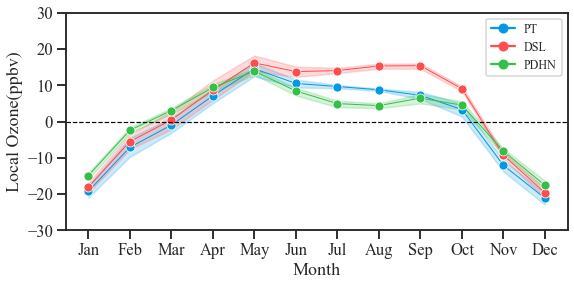

In [20]:
# sitename = 'PDHN'
data_PDHN = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PDHN.csv',parse_dates=['datetime'])
data_PDHN['sitename'] = 'PDHN'
data_DSL = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_DSL.csv',parse_dates=['datetime'])
data_DSL['sitename'] = 'DSL'
data_PT = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT.csv',parse_dates=['datetime'])
data_PT['sitename'] = 'PT'
data = data_PDHN.append(data_DSL)
data = data.append(data_PT)

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx'
        ,parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3_rmw']]
# data_pca

data = data.merge(data_pca,left_on='datetime',right_on='datetime')
data['local'] = data['predicts'] - data['BKGO3_rmw']
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour


data = data.set_index('datetime')
# data = data.resample('M').mean()
data = data.groupby([pd.Grouper(freq='M'),'sitename']).mean()

data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
# ax.plot(data['datetime'],data['predicts'],c='#12B361',label='weather-removed ozone')
# ax.plot(data['datetime'],data['BKGO3_rmw'],c='#1255B3',label='weather-removed background ozone')
# ax.plot(data['datetime'],data['local'],c='#FF6500',label='local ozone')

sns.lineplot(data = data,x='month',y='local',hue='sitename',style='sitename',lw=1,ci=95,err_style='band',dashes=False,markers=['o','o','o'],
    palette=['#0099e5','#ff4c4c','#34bf49'],hue_order=['PT','DSL','PDHN'],
    ax=ax)
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

ax.set_ylim(-30,30)
# ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
# ax.legend(loc='upper center',ncol=4,frameon=False,fontsize=12)
ax.legend(fontsize=12)

ax.set_ylabel('Local Ozone(ppbv)')
ax.set_xlabel('Month')


# import os
# outputPath = r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\本地臭氧移除气象\站点差异_月变化.png'
# dirs = os.path.dirname(outputPath)

# if not os.path.exists(dirs):
#     os.makedirs(dirs)
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\本地浓度站点差异_月变化.png',dpi=400,bbox_inches='tight')

***散点图三站点小时变化

In [ ]:
# sitename = 'PDHN'
data_PDHN = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PDHN.csv',parse_dates=['datetime'])
data_PDHN['sitename'] = 'PDHN'
data_DSL = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_DSL.csv',parse_dates=['datetime'])
data_DSL['sitename'] = 'DSL'
data_PT = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT.csv',parse_dates=['datetime'])
data_PT['sitename'] = 'PT'
data = data_PDHN.append(data_DSL)
data = data.append(data_PT)

# data_rmw_PT

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx'
        ,parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3_rmw']]
# data_pca

data = data.merge(data_pca,left_on='datetime',right_on='datetime')
data['local'] = data['predicts'] - data['BKGO3_rmw']
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour


data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
colors = ['#0099e5','#ff4c4c','#34bf49']
sns.lineplot(data = data,x='hour',y='local',hue='sitename',
    lw=1,
    ci=95,err_style='band',dashes=False,
    style='sitename',hue_order=['PT','DSL','PDHN'],
    palette=colors,
    markers=['o','o','o'],ax=ax)
ax.set_xticks(np.arange(10,19,1))

ax.set_ylim(-15,15)
# ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(fontsize=12)
ax.set_ylabel('Local Ozone(ppbv)')
ax.set_xlabel('Hour')


plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\本地浓度站点差异_日变化.png',dpi=400,bbox_inches='tight')


***三站点年变化趋势图

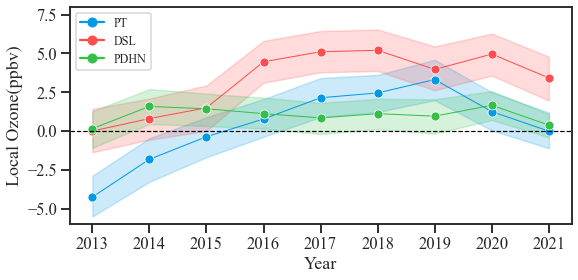

In [21]:
# sitename = 'PDHN'
data_PDHN = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PDHN.csv',parse_dates=['datetime'])
data_PDHN['sitename'] = 'PDHN'
data_DSL = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_DSL.csv',parse_dates=['datetime'])
data_DSL['sitename'] = 'DSL'
data_PT = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\随机森林模型\!!!python重构后训练结果\rmwNormal\O31_PT.csv',parse_dates=['datetime'])
data_PT['sitename'] = 'PT'
data = data_PDHN.append(data_DSL)
data = data.append(data_PT)

# data_rmw_PT

data_pca = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\PCA\PCA_按天_剔除超过6小时的天线性插值填充 _五站点\常规五项\背景浓度最终结果.xlsx'
        ,parse_dates=['datetime'])
data_pca = data_pca[['datetime','BKGO3_rmw']]
# data_pca

data = data.merge(data_pca,left_on='datetime',right_on='datetime')
data['local'] = data['predicts'] - data['BKGO3_rmw']
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour
data['year'] = data['datetime'].dt.year
data = data.set_index('datetime')
data = data.groupby(['sitename',pd.Grouper(freq='D')]).mean()


# data = data.groupby(data.index.month).mean()
data = data.reset_index()
# data
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
# ax.plot(data['datetime'],data['predicts'],c='#12B361',label='weather-removed ozone')
# ax.plot(data['datetime'],data['BKGO3_rmw'],c='#1255B3',label='weather-removed background ozone')
# ax.plot(data['datetime'],data['local'],c='#FF6500',label='local ozone')

sns.lineplot(data = data,x='year',y='local',hue='sitename',style='sitename',lw=1,err_style='band',ci=95,dashes=False,
    # err_kws={'capsize':1},
    hue_order=['PT','DSL','PDHN'],
    palette=['#0099e5','#ff4c4c','#34bf49'],
    markers=['o','o','o'],ax=ax)

# sns.pointplot(data = data,x='year',y='local',hue='sitename',style='sitename',join=False,err_style='band',ci=90,dashes=False,
#     # err_kws={'capsize':1},
#     hue_order=['DSL','PDHN','PT'],
#     palette=['#1255B3','#FF6500','#12B361'],
#     markers=['.','.','.'],ax=ax)

ax.set_ylim(-6,8)
# ax.set_title(sitename)
ax.axhline(0,color='black',ls='--',lw=1.2)
ax.legend(fontsize=12)
ax.set_ylabel('Local Ozone(ppbv)')
ax.set_xlabel('Year')


plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\图片\本地浓度站点差异_年际变化.png',dpi=400,bbox_inches='tight')

# 5 气象数据 

In [ ]:
data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\SH_ERA5_LAND_1997_2021-12-01_8vars_5sites.csv',parse_dates=['time'])
# data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\空气质量数据\!!!带气象的站点数据\2013-2021清洗并填充后\SHdata_5sites_2013_2021_除超过6小时缺值天线性插值.csv',parse_dates=['datetime'])


## 绘制箱线图

In [ ]:
data1 = data.set_index(['time'])
# data1 = data1.loc[(data1.index.month>3)&(data1.index.month<11)]
data1 = data1.loc[data1['sitename'].isin(['PDHN','PT','DSL'])]

# data1 = data1.loc[(data1.index.year>2012)]


data1 = data1.iloc[:,2:]
data1['rh'] = data1.apply(lambda x:cal_RH(x.d2m,x.t2m),axis=1)
data1['t2m'] = data1['t2m'] - 273.15
del data1['d2m']
data1['sp'] = data1['sp']/1000
unit = {'t2m':'℃','sp':'kPa','ssr':'$J/{m^2}$','wd':None,'ws':'m/s','rh':'%','tp':'m','blh':'m'}
# data1 = data1.reset_index()
# data1 = data1.melt(id_vars=['time','sitename'])
# data1
sns.set(font='Times New Roman',context='talk',palette=['#96ceb4','#ffeead','#ffad60'])
# sns.set(font='Times New Roman',context='talk',palette=['#35589A','#F14A16','#FC9918'])

factors= list(data1.columns)
factors.remove('sitename')
data1 = data1[['sitename']+factors]
fig,ax = plt.subplots(1,len(data1.columns[1:]),figsize=(28,12))
plt.subplots_adjust(wspace=0.3)
for num,column in enumerate(data1.columns[1:]):
    # print(column)
    if column == 'wd':
            # sns.boxplot(
            # data = data1,
            # x='sitename',
            # y=column,
            # linewidth=2,
            # width=0.5,
            # showmeans=True,
            # meanprops={"marker":"o",
            #         "markerfacecolor":"white", 
            #         "markeredgecolor":"black",
            #         "markersize":"10"},
            # ax=ax[num]
            # )
            sns.violinplot(
                data = data1,
                x='sitename',
                y=column, 
                # color=".25",
                ax=ax[num]
                )
            ax[num].set_yticks([0,45,90,135,180,225,270,315,360])
            ax[num].set_yticklabels(['N','NE','E','SE','S','SW','W','NW','N'])

            ax[num].set_ylim(0,360)
            ax[num].set_ylabel('%s'%(column))

    else:
        sns.boxplot(data = data1,
                x='sitename',
                linewidth=2,
                width=0.5,
                showmeans=True,
                meanprops={"marker":"o",
                        "markerfacecolor":"white", 
                        "markeredgecolor":"black",
                        "markersize":"10"},
                y=column,
                ax=ax[num]
                )
        ax[num].set_ylabel('%s(%s)'%(column,unit[column]))
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\figure\三站点气象数据对比.png',dpi=400,bbox_inches='tight')

## 风向月份分布

In [ ]:
# data1 = data.loc[data['sitename']=='PT']
data1 = data.groupby('time').mean()
data1 = data1.reset_index()
data1 = data1.loc[(data1['time'].dt.hour>9)&(data1['time'].dt.hour<19)]
data1['month'] = data1['time'].dt.month
import math
from math import atan2
data1['wd'] = data1.apply(lambda x:(180+(180/np.pi)*atan2(x.v10,x.u10))%360,axis=1)

fig,ax  = plt.subplots(figsize =(9,4))
sns.violinplot(data = data1, x='month',y='wd',ax=ax,palette='Set2',lw=0.2)
ax.set_yticks([0,45,90,135,180,225,270,315,360])
ax.set_yticklabels(['N','NE','E','SE','S','SW','W','NW','N'])

ax.set_ylim(0,360)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\背景浓度移除气象\上海市风向月变化.png',bbox_inches='tight',dpi=400)

In [ ]:
# data1 = data.loc[data['sitename']=='PT']
data1 = data.groupby('time').mean()
data1 = data1.reset_index()
data1 = data1.loc[(data1['time'].dt.hour>9)&(data1['time'].dt.hour<19)]
data1['month'] = data1['time'].dt.month
data1 = data1.loc[data1['month']==6]
import math
from math import atan2
data1['wd'] = data1.apply(lambda x:(180+(180/np.pi)*atan2(x.v10,x.u10))%360,axis=1)

fig,ax  = plt.subplots(figsize =(9,4))
sns.histplot(data = data1, x='wd',ax=ax,palette='Set2',lw=0.2)
# ax.set_yticks([0,45,90,135,180,225,270,315,360])
# ax.set_yticklabels(['N','NE','E','SE','S','SW','W','NW','N'])

# ax.set_ylim(0,360)
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\背景浓度移除气象\上海市风向月变化.png',bbox_inches='tight',dpi=400)

## 风速月份分布

In [ ]:
sitename = 'PT'
data1 = data.loc[data['sitename']==sitename]
data1['month'] = data1['time'].dt.month
data1 = data1.loc[(data1['time'].dt.hour>9)&(data1['time'].dt.hour<19)]
fig,ax  = plt.subplots(figsize =(9,4))
sns.boxplot(data = data1, x='month',y='ws',ax=ax,palette='Set2',)
ax.set_title(sitename)
plt.show()

## 各月份雨量

In [ ]:
sitename = 'PT'
data1 = data.loc[data['sitename']==sitename]
data1['month'] = data1['time'].dt.month
data1 = data1.loc[(data1['time'].dt.hour>9)&(data1['time'].dt.hour<19)]
fig,ax  = plt.subplots(figsize =(9,4))
sns.boxplot(data = data1, x='month',y='tp',ax=ax,palette='Set2',)
ax.set_title(sitename)
ax.set_ylim(0,0.005)
plt.show()

### 相对湿度

In [ ]:
# sitename = 'DSL'
# data1 = data.loc[data['sitename']==sitename]
data1 = data.copy()
data1 = data1.loc[data1['time'].dt.month.isin([5,6,7,8,9,10])]
data1 = data1.loc[data1['sitename'].isin(['DSL','PDHN','PT'])]

data1['month'] = data1['time'].dt.month
data1 = data1.loc[(data1['time'].dt.hour>9)&(data1['time'].dt.hour<19)]
fig,ax  = plt.subplots(figsize =(12,5))
sns.set(context='talk',style='ticks',font='Times New Roman')
sns.boxplot(data = data1, x='sitename',y='rh',hue='month',
        # palette=['#FF6500','#1255B3','#12B361'],
        # alpha=0.6,
        showmeans=True,
        meanprops={"marker":"o",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"10"},
        # saturation=0.5,
        ax=ax,
        palette='Set2',
        )
ax.set_ylabel('rh(%)')
ax.legend(loc='upper center',ncol=6,bbox_to_anchor=(0.5,1.15),frameon=False,fontsize=20)


# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\本地臭氧移除气象\相对湿度_月变化.png',dpi=400,bbox_inches='tight')

## 其他月份分布

In [ ]:
# sitename = 'DSL'
# data1 = data.loc[data['sitename']==sitename]
data1 = data.copy()
data1['tp'] = data1['tp']*1000
# data1 = data1.loc[data1['time'].dt.month.isin([5,6,7,8,9,10])]
data1 = data1.loc[data1['sitename'].isin(['PT','DSL','PDHN',])]

# data1 = data1.loc[(data1['time'].dt.year<2013)]


data1['month'] = data1['time'].dt.month
data1 = data1.loc[(data1['time'].dt.hour>9)&(data1['time'].dt.hour<19)]
fig,ax  = plt.subplots(figsize =(12,5))
sns.set(context='talk',style='ticks',font='Times New Roman')
# sns.boxplot(data = data1, x='sitename',y='tp',hue='month',
#         # palette=['#FF6500','#1255B3','#12B361'],
#         # alpha=0.6,
#         showmeans=True,
#         meanprops={"marker":"o",
#                 "markerfacecolor":"white", 
#                 "markeredgecolor":"black",
#                 "markersize":"10"},
#         # saturation=0.5,
#         ax=ax,
#         palette='Set2',
#         )
sns.lineplot(data = data1, x='month',y='tp',hue='sitename',style='sitename',dashes=False,markers=['o','o','o'],palette=['#1255B3','#FF6500','#12B361'])
ax.set_ylabel('rh(%)')
ax.set_xticks(np.arange(1,13,1))

ax.legend(loc='upper center',ncol=6,bbox_to_anchor=(0.5,1.15),frameon=False,fontsize=20)
# ax.set_ylim(0,3.2)

plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\最终结果\本地臭氧移除气象\相对湿度_月变化.png',dpi=400,bbox_inches='tight')

## 5.1 ERA5和NOAA ISD气象数据对比

In [69]:
data_meo = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\虹桥机场1997_2020.csv',encoding='utf_8_sig',parse_dates=['DATE'])
data_meo = data_meo[['STATION','DATE','CALL_SIGN','DEW','SLP','TMP','VIS','WND','MA1']]

data_meo = data_meo.set_index('DATE')
data_meo = data_meo.shift(8, freq='h')
data_meo = data_meo.loc['2013':'2020']
data_meo['d2m'] = data_meo['DEW'].str.split(',',n=-1,expand=False).apply(lambda x:float(x[0])/10 if x[1]=='1' else np.nan)
data_meo['sp'] = data_meo['SLP'].str.split(',',n=-1,expand=False).apply(lambda x:x[0] if x[1]=='1' else np.nan)
data_meo['t2m'] = data_meo['TMP'].str.split(',',n=-1,expand=False).apply(lambda x:float(x[0])/10 if x[1]=='1' else np.nan)
data_meo['wd'] = data_meo['WND'].str.split(',',n=-1,expand=False).apply(lambda x:float(x[0]) if x[1]=='1' else np.nan)
data_meo['ws'] = data_meo['WND'].str.split(',',n=-1,expand=False).apply(lambda x:float(x[3])/10 if x[4]=='1' else np.nan)
data_meo['rh'] = data_meo.apply(lambda row:cal_RH(row.d2m,row.t2m,method='method2'),axis=1)

data_meo = data_meo.asfreq(freq='1h')
data_meo.index.name = 'time'
data_meo = data_meo.reset_index()
data_meo['sitename'] = 'HQ1'
data_meo = data_meo[['sitename','time','d2m','sp','t2m','wd','ws','rh']]
data_meo

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (4,6,7,8,9,10,11,14,15,18,19,20,22,24,27,32,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,sitename,time,d2m,sp,t2m,wd,ws,rh
0,HQ1,2013-01-01 00:00:00,-5.0,NaN,0.0,200.0,3.0,69.058868
1,HQ1,2013-01-01 01:00:00,-5.0,NaN,0.0,200.0,2.0,69.058868
2,HQ1,2013-01-01 02:00:00,-5.0,NaN,0.0,200.0,1.0,69.058868
3,HQ1,2013-01-01 03:00:00,-4.0,NaN,0.0,210.0,2.0,74.458392
4,HQ1,2013-01-01 04:00:00,-4.0,NaN,-1.0,220.0,3.0,80.082633
...,...,...,...,...,...,...,...,...
70123,HQ1,2020-12-31 19:00:00,-13.0,NaN,-1.0,300.0,3.0,39.724427
70124,HQ1,2020-12-31 20:00:00,-13.0,NaN,-1.0,290.0,2.0,39.724427
70125,HQ1,2020-12-31 21:00:00,-12.0,NaN,-1.0,260.0,2.0,43.058637
70126,HQ1,2020-12-31 22:00:00,-11.0,NaN,-2.0,240.0,2.0,50.193595


In [70]:
from math import atan2
era5 = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\上海臭氧课题\气象数据\SH_ERA5_LAND_2012_2021_includeHQ.csv',parse_dates=['time'])
# isd = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\SC&YRD_data\original data\YRD\上海市气象数据2013_2020.csv')
era5['t2m'] = era5['t2m'] - 273.15
era5['d2m'] = era5['d2m'] - 273.15
era5['rh'] = era5.apply(lambda row:cal_RH(row.d2m,row.t2m,method='method2'),axis=1)
era5['wd'] = era5.apply(lambda x:(270-(180/np.pi)*atan2(x.v10,x.u10))%360,axis=1)
'''
https://stackoverflow.com/questions/8673137/calculating-wind-direction-from-u-and-v-components-of-the-wind-using-lapply-or-i
https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398
http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv
'''
era5

,Unnamed: 0,time,u10,v10,d2m,t2m,tp,sp,ssr,sitename,wd,ws,rh
0,0,2012-01-01 08:00:00,0.800426,-0.677034,2.04530,2.55250,0.0,102984.414,10472146.0,DSL,310.225939,1.048359,96.454812
1,1,2012-01-01 09:00:00,0.804914,-0.994226,2.29388,5.45672,0.0,103069.720,445492.0,DSL,321.006753,1.279208,80.072985
2,2,2012-01-01 10:00:00,0.793943,-1.740046,1.16757,7.21545,0.0,103061.660,1388766.0,DSL,335.473876,1.912617,65.448679
3,3,2012-01-01 11:00:00,0.884707,-3.222086,-0.28547,8.25436,0.0,102997.120,2672968.0,DSL,344.646336,3.341339,54.899755
4,4,2012-01-01 12:00:00,1.070725,-3.477509,-0.62900,8.45153,0.0,102901.586,3919825.0,DSL,342.886401,3.638615,52.833121
...,...,...,...,...,...,...,...,...,...,...,...,...,...
526027,526027,2022-01-01 03:00:00,-1.753036,-0.130016,-1.04264,0.89364,0.0,103075.980,10336254.0,HQ,85.758346,1.757851,86.891906
526028,526028,2022-01-01 04:00:00,-2.027250,-0.168127,-1.00434,0.76300,0.0,102995.664,10336254.0,HQ,85.259106,2.034210,87.959416
526029,526029,2022-01-01 05:00:00,-2.109670,-0.220823,-0.77375,0.99010,0.0,102960.290,10336254.0,HQ,84.024497,2.121195,88.002901
526030,526030,2022-01-01 06:00:00,-2.421205,-0.173303,-1.16170,0.61562,0.0,102954.240,10336254.0,HQ,85.905921,2.427400,87.881475


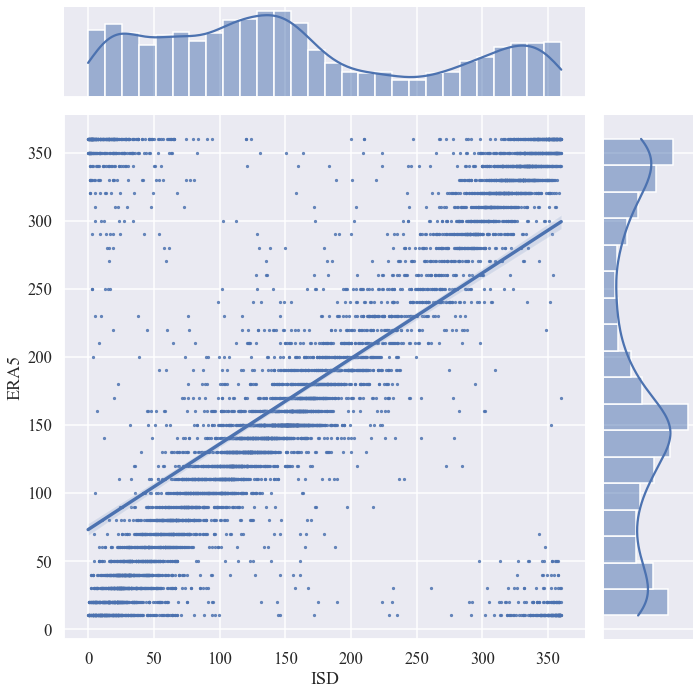

mae:43.76557994397493
r:0.621864381140567
rmse:97.48312828292431


In [93]:
from sklearn.metrics import r2_score,mean_squared_error,median_absolute_error,\
                    mean_absolute_error,explained_variance_score
factor = 'wd'
met = era5.append(data_meo)
met = met.set_index('time')
met = met.loc['2020':]
met = met.loc[met['sitename'].isin(['HQ1','HQ'])]

# sns.boxplot(data = met, x='sitename',y=factor,hue='sitename',)
met1 = met[[factor,'sitename']].reset_index().pivot_table(index='time',columns='sitename',values=factor)
met1.columns = ['ISD','ERA5']
sns.set(font='times new roman',context='talk')
sns.jointplot(data=met1, x='ISD', y='ERA5',kind="reg",height=10,scatter_kws={'s':5})
plt.show()
print('mae:%s'%mae(met1['ISD'].values,met1['ERA5'].values))
print('r:%s'%correlation(met1['ISD'].values,met1['ERA5'].values))
print('rmse:%s'%rmse(met1['ISD'].values,met1['ERA5'].values))